## Story Time!

My inspiration from this project stems from a hobby of mine--fantasy writing. More worldbuilding: I'm telling the story of a world and its people over millions of years, and as part of that I enjoy thinking about what life would be like on the world, as it orbits around two solar masses, one bright and the other dim. This system is much different from Earth's, and it could carry with it strange climate effects and trends (much like our very own Milankovich Cycle).

The characters in the story might not notice the detailed eccentricity of their planet's orbit around the baricenter of the star system, but they would notice if, for example, the winters lasted ten years and the sun was ecclipsed every week! These things could shape cultures and motives, beliefs and religions, and I want a semi-realistic origin for such things in my story.

So, here goes...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3
from tqdm import tqdm
import imageio as im
from IPython.display import Image
import cv2

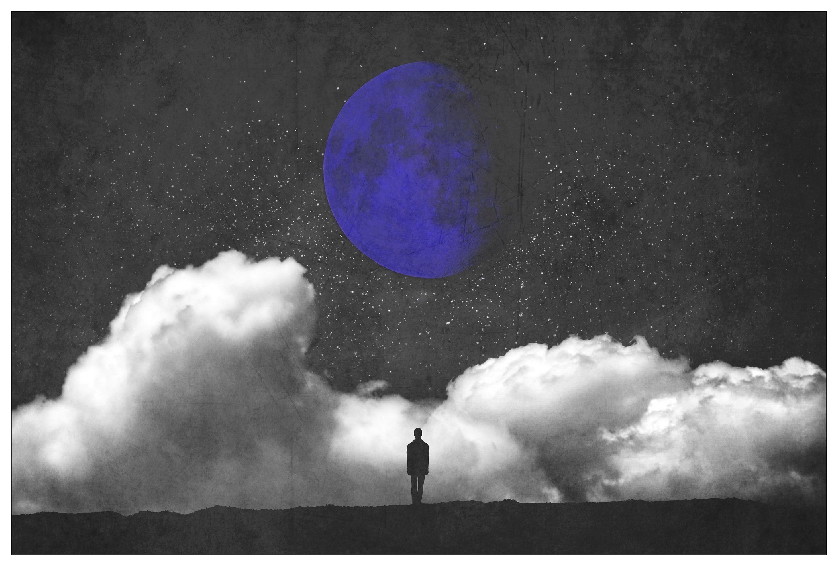

In [2]:
img = cv2.imread('red.jpg')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)

So...what characteristics would a system like that have? What kind of climatal effects would the orbit have on the planet?

## Goal:

Set up a restricted three-body system and see how the orbit of the planet effects the amount of light hitting it.

## Initial Conditions -----------------------------------------------------------------------

I went about this in an admittedly non-generalized way. I explicitely defined the masses, radii, and initial positions of each of my three bodies (the planet mass, the bright mass, and the dark mass).

Much of what I do to calculate the forces between the three objects and to determine when ecclipses happen comes down to a significant amount of vector work, so that comes next (denoted by the VECTORS comment below).

More on the ecclipse detection: this stumped me for a while. Eventually, though, I was able to impliment a new set of vectors to take care of the problem. Both of the solar masses are continuously projected onto some central plane through the baricenter and perpendicular to the vector pointing from the baricenter to the planet. This narrows the scope of the problem--I'm no longer looking at two dimensional motion, only the horizontal motion of the large masses to see if they overlap at any point in time.

Finally, I calculate the initial velocity that the planet must orbit to be stable using:

$$\sqrt{\frac{GMm}{r}}$$

This incorporates an important assumption I'm making: that, when far enough away, the two large masses can be approximated as one combined mass for determining the orbit of the planet.

I go on to initialize the momentum of each body and the luminosity and brightness of the bright star. The brightness is given by:

$$\frac{L}{4\pi r^2}$$

where L is the luminosity and r is the distance vector between the planet and the star.

In [20]:
G = 6.7e-11 # Newton gravitational constant


#Define Initial Properties of the objects--------------------------------------------------
starPos = np.array([7.48e10,0,0]) #initial position array for star; x,y,z components
starR = 7e8 #radius in meters
starM = 2e30 #mass of sun in kg

darkPos = np.array([-7.48e10,0,0]) #initial position array for dark object; x,y,z components
darkR = 2e6 #radius of dark obect in meters
darkM = 2e30 #mass of dark object in kg

planPos = np.array([0,3*(-150e9),0]) #initial position array for star; x,y,z components
planR = 6e6 #radius in meters
planM = 6e24 #mass of sun in kg
#------------------------------------------------------------------------------------------


#VECTORS!
#First, store the vectors that point between each of the three bodies and normalize them--
rds = darkPos - starPos
rdp = darkPos - planPos
rsp = starPos - planPos
rdshat = rds/np.linalg.norm(rds)
rdphat = rdp/np.linalg.norm(rdp)
rsphat = rsp/np.linalg.norm(rsp)
rdsmag = np.sqrt(sum([x**2 for x in rds]))
rdpmag = np.sqrt(sum([x**2 for x in rdp]))
rspmag = np.sqrt(sum([x**2 for x in rsp]))

#Baricenter vectors and Projection vectors---------------------------------------------
baricenter = np.array([0,0,0])
rpb = planPos - baricenter
rpbhat = rpb/np.linalg.norm(rpb)
PROPLANE = np.cross(rpbhat,np.array([0,0,1]))
PROPLANEmag = np.sqrt(sum([x**2 for x in PROPLANE]))

rsb = starPos - baricenter
rsbhat = rsb/np.linalg.norm(rsb)
rdb = darkPos - baricenter
rdbhat = rdb/np.linalg.norm(rdb)

project_star = (np.dot(rsb,PROPLANE)/PROPLANEmag)*PROPLANE
project_dark = (np.dot(rdb,PROPLANE)/PROPLANEmag)*PROPLANE

rp_ps = planPos - project_star
rp_pshat = rp_ps/np.linalg.norm(rp_ps)
rp_psmag = np.sqrt(sum([x**2 for x in rp_ps]))

rp_pd = planPos - project_dark
rp_pdhat = rp_pd/np.linalg.norm(rp_pd)
rp_pdmag = np.sqrt(sum([x**2 for x in rp_pd]))
#--------------------------------------------------------------------------------------

#Initial velocities for the two stellar masses are found by guess-and-check
#initial velocity for the planetary object is found by using Kepler's Third Law
initialVstar = -9e3
initialVdark = -initialVstar #initial velocity of dark object in m/s
initialVplan = np.sqrt((G*(starM+darkM))/(rdpmag))

#Finally, get each object's initial momentum------------------------------------------
planP = np.array([initialVplan,0,0])*planM
darkP = np.array([0,initialVdark,0])*darkM
starP = np.array([0,initialVstar,0])*starM
#-------------------------------------------------------------------------------------

#Define the luminocity and brightness for the bright stellar body---------------------
L = 1 #Watts
B = L/(4*np.pi*rspmag**2)
#-------------------------------------------------------------------------------------

## Integration Step -------------------------------------------------------------------

Next comes the fun part: the integration. I utilize an implicit Euler / Leap-Frog sort of integration for this, calculating the force between each body and every other body using the classic equation:

$$F = \frac{GMm}{r^2}$$

Using that I'm able to calculate the new momentum of each body, and using the momentum I'm able to calculate the change in position.

Throughout the integration process I constantly update many of the vectors I initialized above for the purposes of the force calculations and the ecclipsing behavior.

In [21]:
starPosA = []
starPA = []
darkPosA = []
darkPA = []
planPosA = []
planPA = []
BA = []
projectionmag = []

dt = 1e4
t=0
tA = []



plt.figure(figsize=[20,10])
while t < 20*np.pi*1e7:
    
    starPosA.append(starPos)
    starPA.append(starP)
    darkPosA.append(darkPos)
    darkPA.append(darkPA)
    planPosA.append(planPos)
    planPA.append(planP)
    BA.append(B)
    tA.append(t)
    
    rds = darkPos - starPos
    rdp = darkPos - planPos
    rsp = planPos - starPos
    rdsmag = np.sqrt(sum([x**2 for x in rds]))
    rdpmag = np.sqrt(sum([x**2 for x in rdp]))
    rspmag = np.sqrt(sum([x**2 for x in rsp]))

    #Baricenter vectors and Projection vectors-------------------
    baricenter = np.array([0,0,0])
    rpb = planPos - baricenter
    rpbhat = rpb/np.linalg.norm(rpb)
    PROPLANE = np.cross(rpbhat,np.array([0,0,1]))
    PROPLANEmag = np.sqrt(sum([x**2 for x in PROPLANE]))

    rsb = starPos - baricenter
    rsbhat = rsb/np.linalg.norm(rsb)
    rdb = darkPos - baricenter
    rdbhat = rdb/np.linalg.norm(rdb)

    project_star = (np.dot(rsb,PROPLANE)/PROPLANEmag)*PROPLANE
    project_dark = (np.dot(rdb,PROPLANE)/PROPLANEmag)*PROPLANE
    project_starmag = np.sqrt(sum([x**2 for x in project_star]))
    project_darkmag = np.sqrt(sum([x**2 for x in project_dark]))
    
    
    rp_ps = planPos - project_star
    rp_pshat = rp_ps/np.linalg.norm(rp_ps)
    rp_psmag = np.sqrt(sum([x**2 for x in rp_ps]))

    rp_pd = planPos - project_dark
    rp_pdhat = rp_pd/np.linalg.norm(rp_pd)
    rp_pdmag = np.sqrt(sum([x**2 for x in rp_pd]))
    #------------------------------------------------------------
    
    #B = L/(4*np.pi*rspmag**2)
    if((project_starmag+project_darkmag)<=(darkR+starR) and rdpmag < rspmag):
        B = 0
    else:
        B = L/(4*np.pi*rspmag**2)
    
    
    Fds = G * starM*darkM*(rds/np.linalg.norm(rds))/(np.linalg.norm(rds)**2)
    Fdp = G * planM*darkM*(rdp/np.linalg.norm(rdp))/(np.linalg.norm(rdp)**2)
    Fsp = G * planM*starM*(rsp/np.linalg.norm(rsp))/(np.linalg.norm(rsp)**2)
    
    starP = starP + Fds*dt + Fsp*dt
    darkP = darkP - Fds*dt - Fdp*dt
    planP = planP - Fsp*dt + Fdp*dt
    
    starPos = starPos + (starP/starM) * dt
    darkPos = darkPos + (darkP/darkM) * dt
    planPos = planPos + (planP/planM) * dt
    
    t = t+dt

starPlot = np.asarray(starPosA)
darkPlot = np.asarray(darkPosA)
planPlot = np.asarray(planPosA)
BPlot = np.asarray(BA)

<Figure size 1440x720 with 0 Axes>

## Results-------------------------------------------------------------------------------

First off, here is a plot of (one instance of) the orbital system! I chose a slightly-more-eccentric binary orbit simply to see what the resulting brightness curve would look like. You can see that the planetary orbit is almost perfectly circular--meaning that the approximation of the two solar masses as a single combined mass was valid.

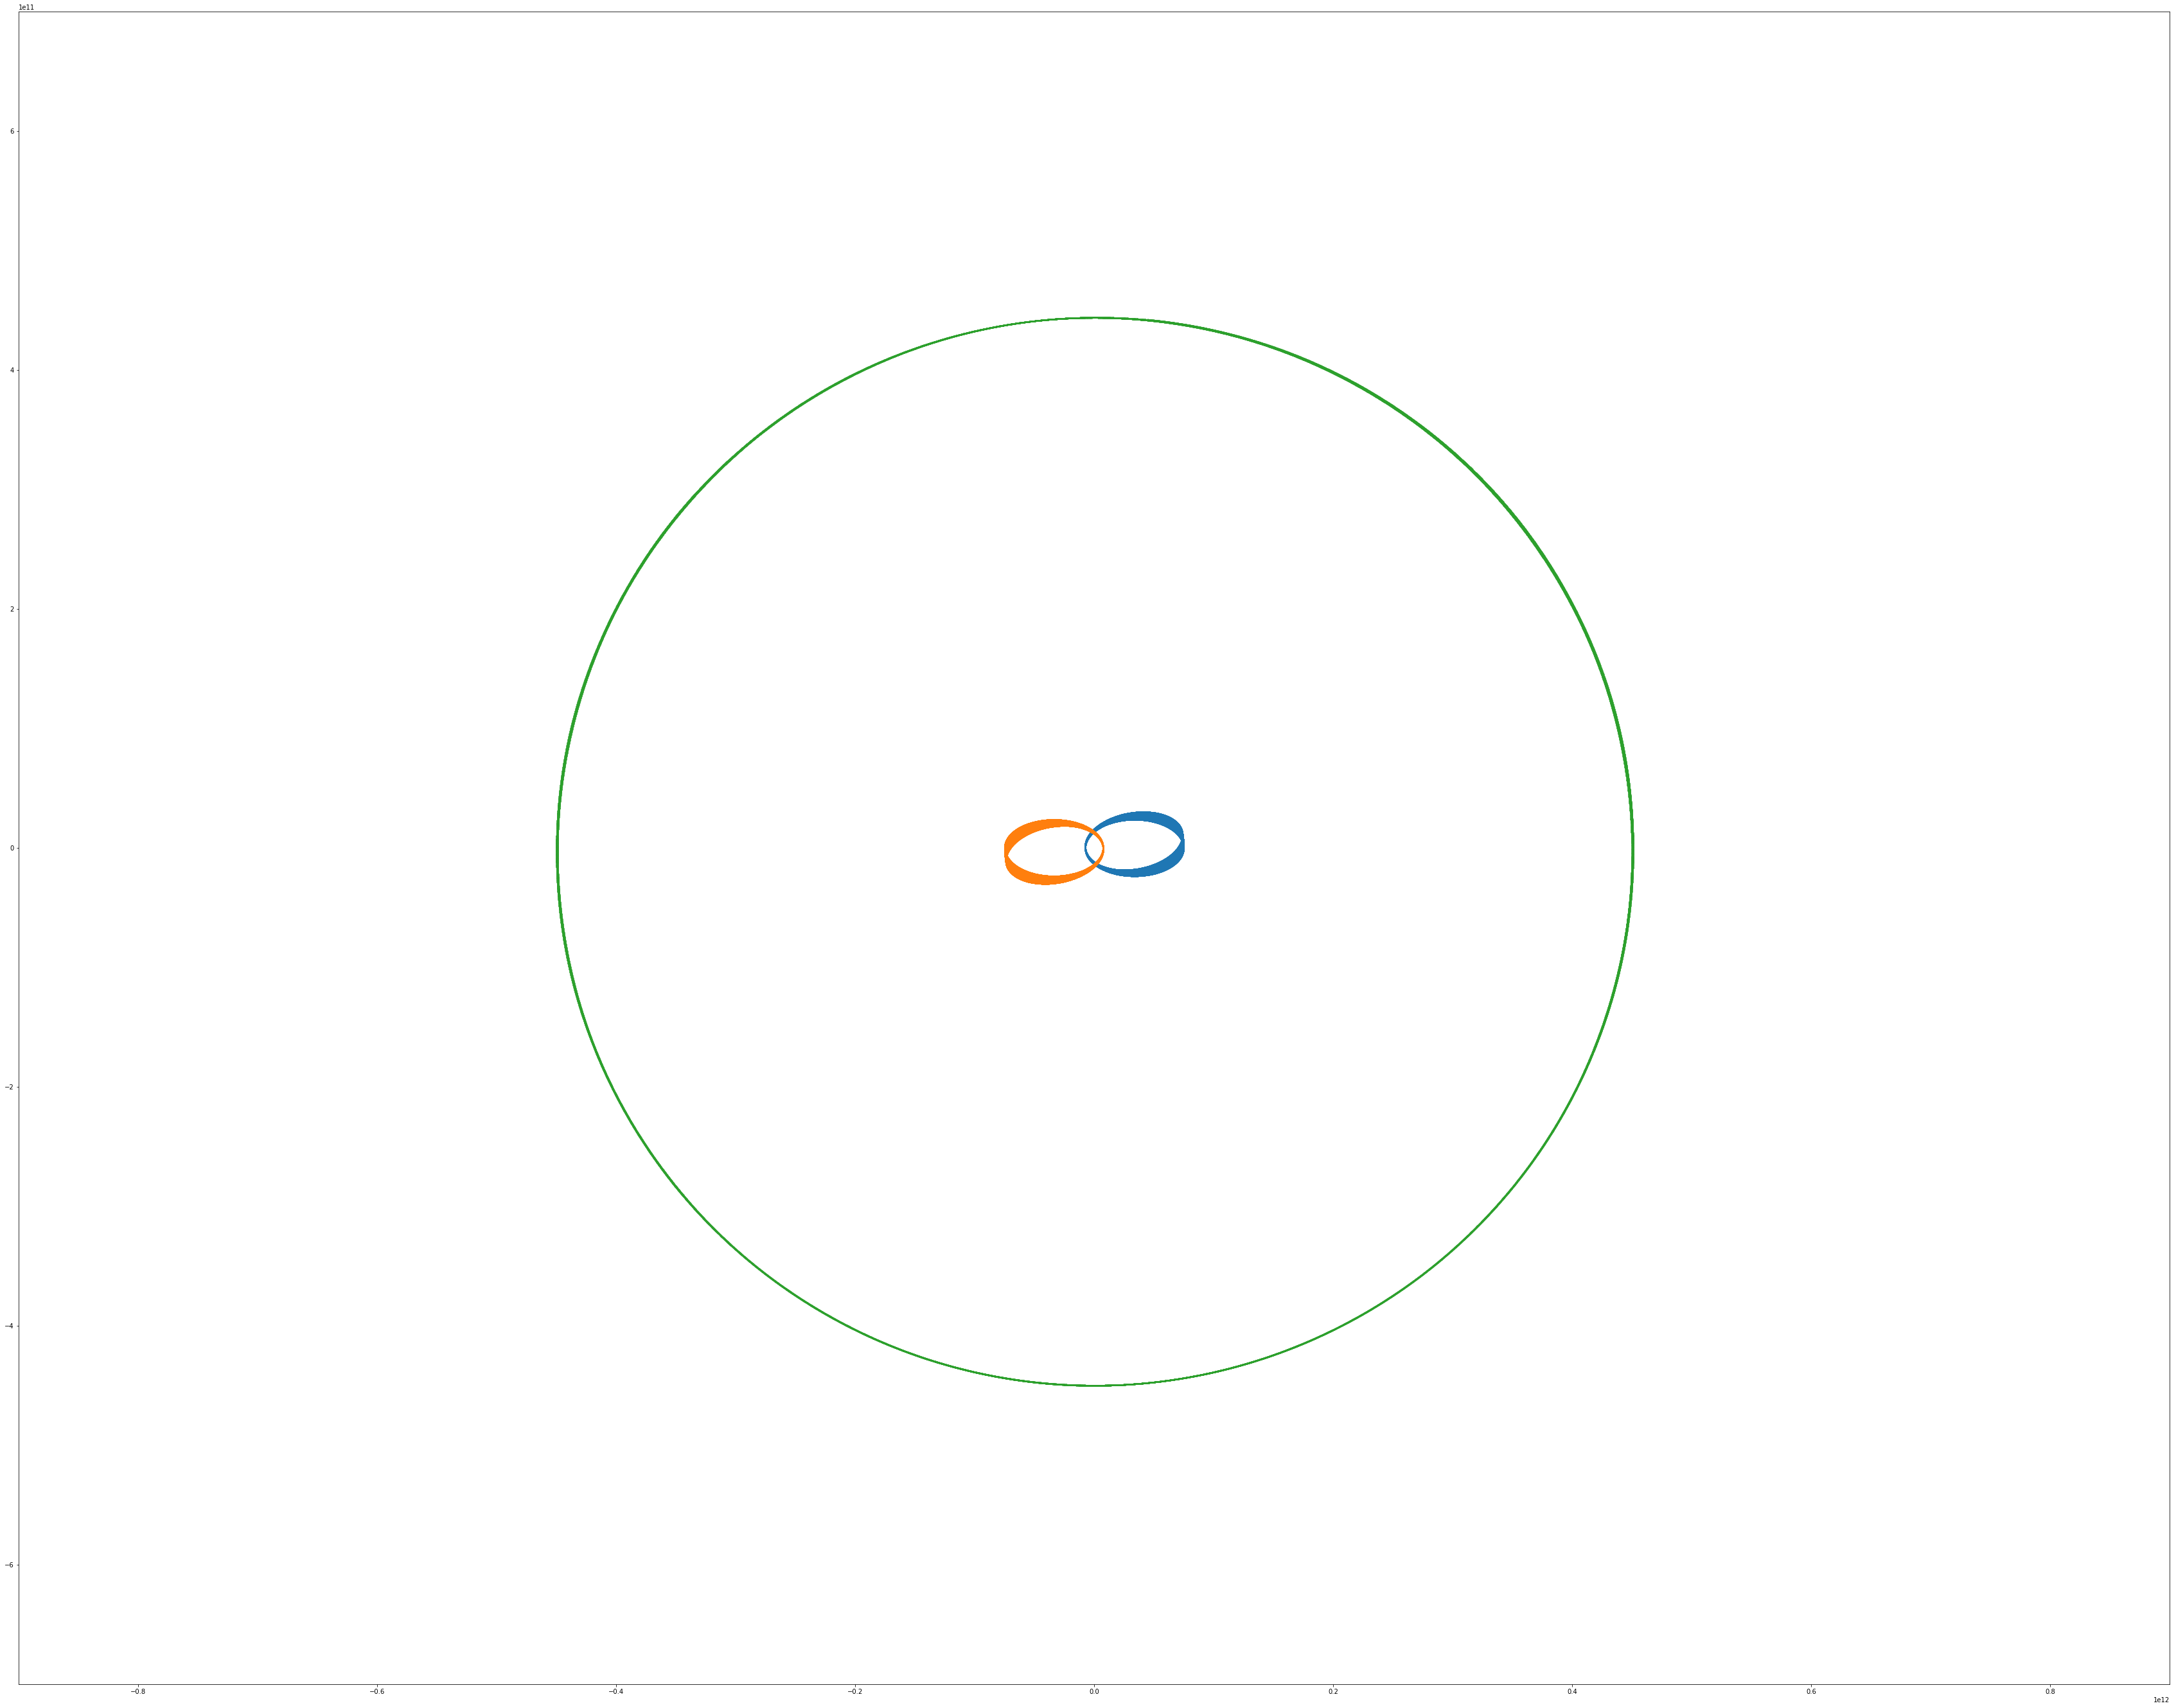

In [22]:
plt.figure(figsize=[60,50])

xbound = 0.9e12
ybound = 0.7e12
plt.scatter(starPlot[:,0],starPlot[:,1],s=2)
plt.scatter(darkPlot[:,0],darkPlot[:,1],s=2)
plt.scatter(planPlot[:,0],planPlot[:,1],s=1)
#plt.xlim(-1e12,0.7e12)
#plt.ylim(-0.7e12,0.7e12)
plt.xlim(-xbound,xbound)
plt.ylim(-ybound,ybound)
ax=plt.gca()
ax.set_aspect(1)

Now for some possible climate effect results: Below is plotted the apparent brightness of the bright body to the planet over time. The apparent brightness changes with the distance the planet is from the bright body, and in this system it has some interesting fluctuations!

The plots are in the following order:
A plot of brightness over one year
A plot of brightness over the next one year
A plot of brightness over ten years

You can see that the brightness of the star changes significantly over just one year, and that pattern changes year to year! In total, the star fluctuates in brightness by over 260% from one extreme to the other--basically, it gets grows to be extremely bright and extremely dim over the course of a ten-year cycle. So much so that it would be uninhabitable! A change in brightness like that on Earth would cause the planet to boil at the star's closest point and freeze at its farthest point.

On ecclipsing, the behavior is shown to cause frequent full ecclipses! Around 3 - 4 each year. While the exact nature of these ecclipses is not fully fleshed out--it's only in two dimensions right now, and the planet doesn't rotate--the frequency of them is enlightening. It is also notable that there appears to be an absence of ecclipsing at about 5 years in. More strange behavior!

0.0
5.647470115293634e-25
1.38886141745333
4.066258911309563e-25


Text(0,0.5,'Apparent Brightness')

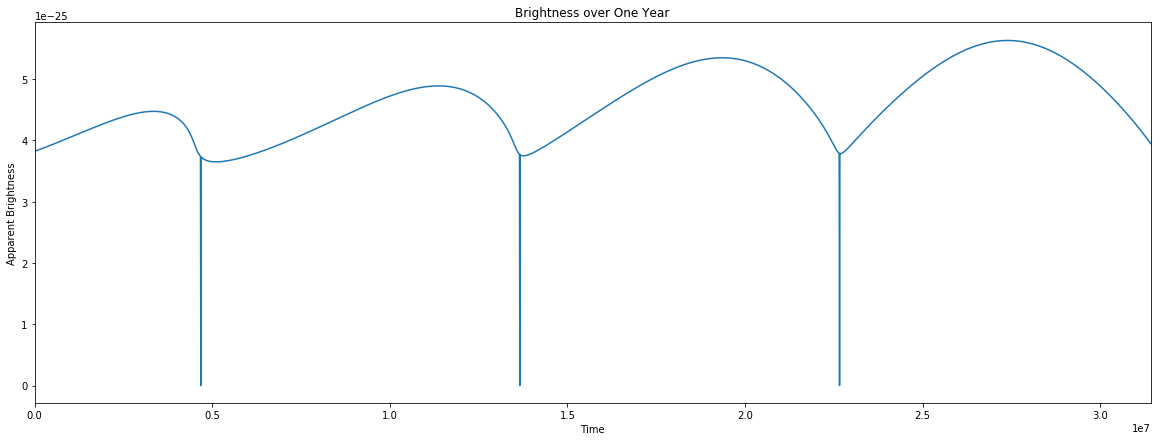

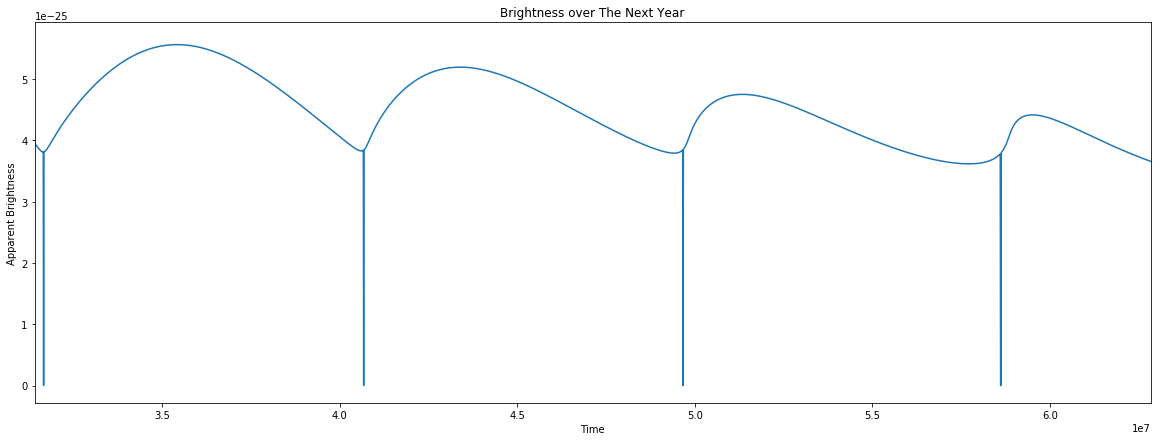

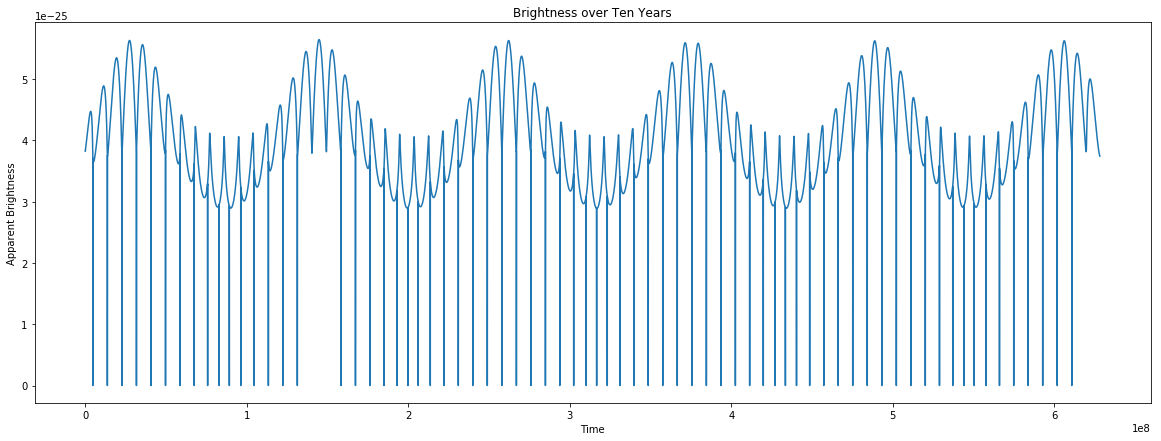

In [23]:
print(np.min(BPlot))
print(np.max(BPlot))
print(np.max(BPlot)/np.average(BPlot))
print(np.average(BPlot))

plt.figure(figsize=[20,7])
plt.plot(tA,BPlot)
plt.xlabel('Time')
plt.ylabel('Apparent Brightness')
plt.title('Brightness over One Year')
plt.xlim(0,1*np.pi*10**7)
#plt.ylim(100,250)

plt.figure(figsize=[20,7])
plt.plot(tA,BPlot)
plt.xlabel('Time')
plt.ylabel('Apparent Brightness')
plt.title('Brightness over The Next Year')
plt.xlim(1*np.pi*10**7,2*np.pi*10**7)
#plt.ylim(100,250)


plt.figure(figsize=[20,7])
plt.plot(tA,BPlot)
plt.xlabel('Time')
plt.title('Brightness over Ten Years')
plt.ylabel('Apparent Brightness')#
#plt.xlim(0,1*np.pi*10**7)

In [24]:
print(100*np.max(BPlot)/np.average(BPlot))

138.886141745333


## Conclusion

Well, I'm going to have to think out the dynamics of this system a bit more. As it stands, all of the characters might catch on fire every month.

Below are some cool images of planets being flung into space.

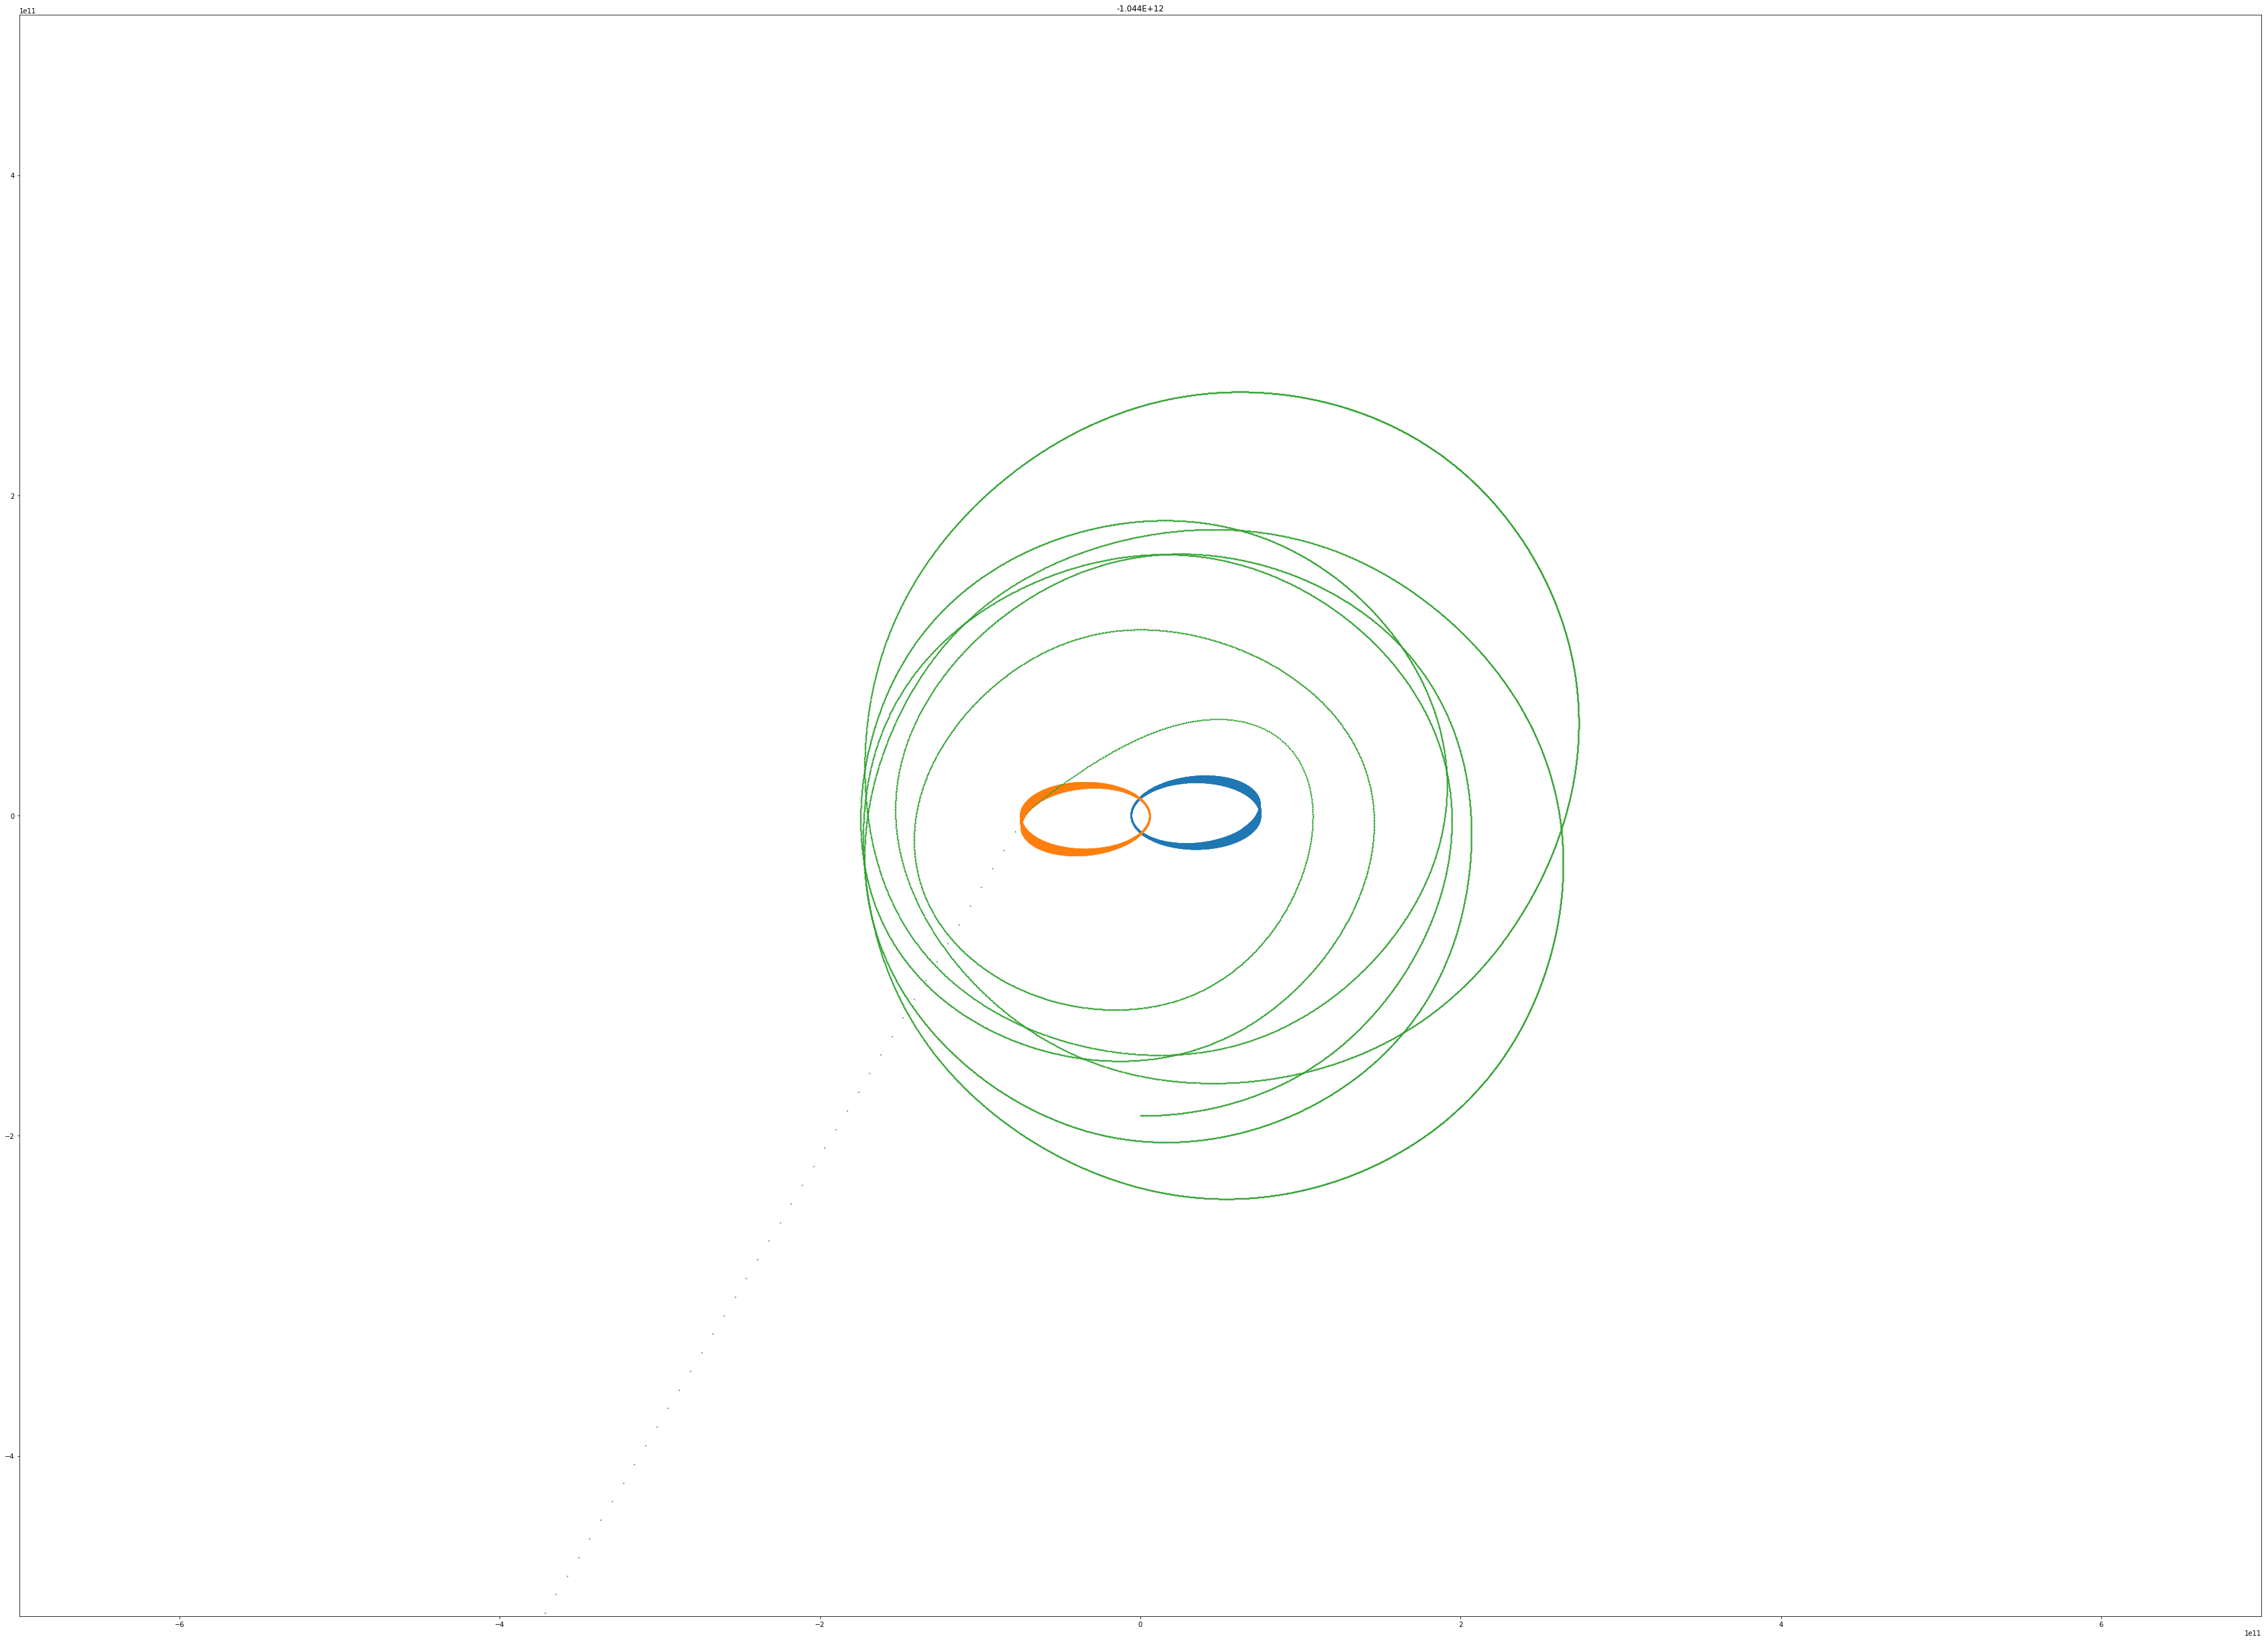

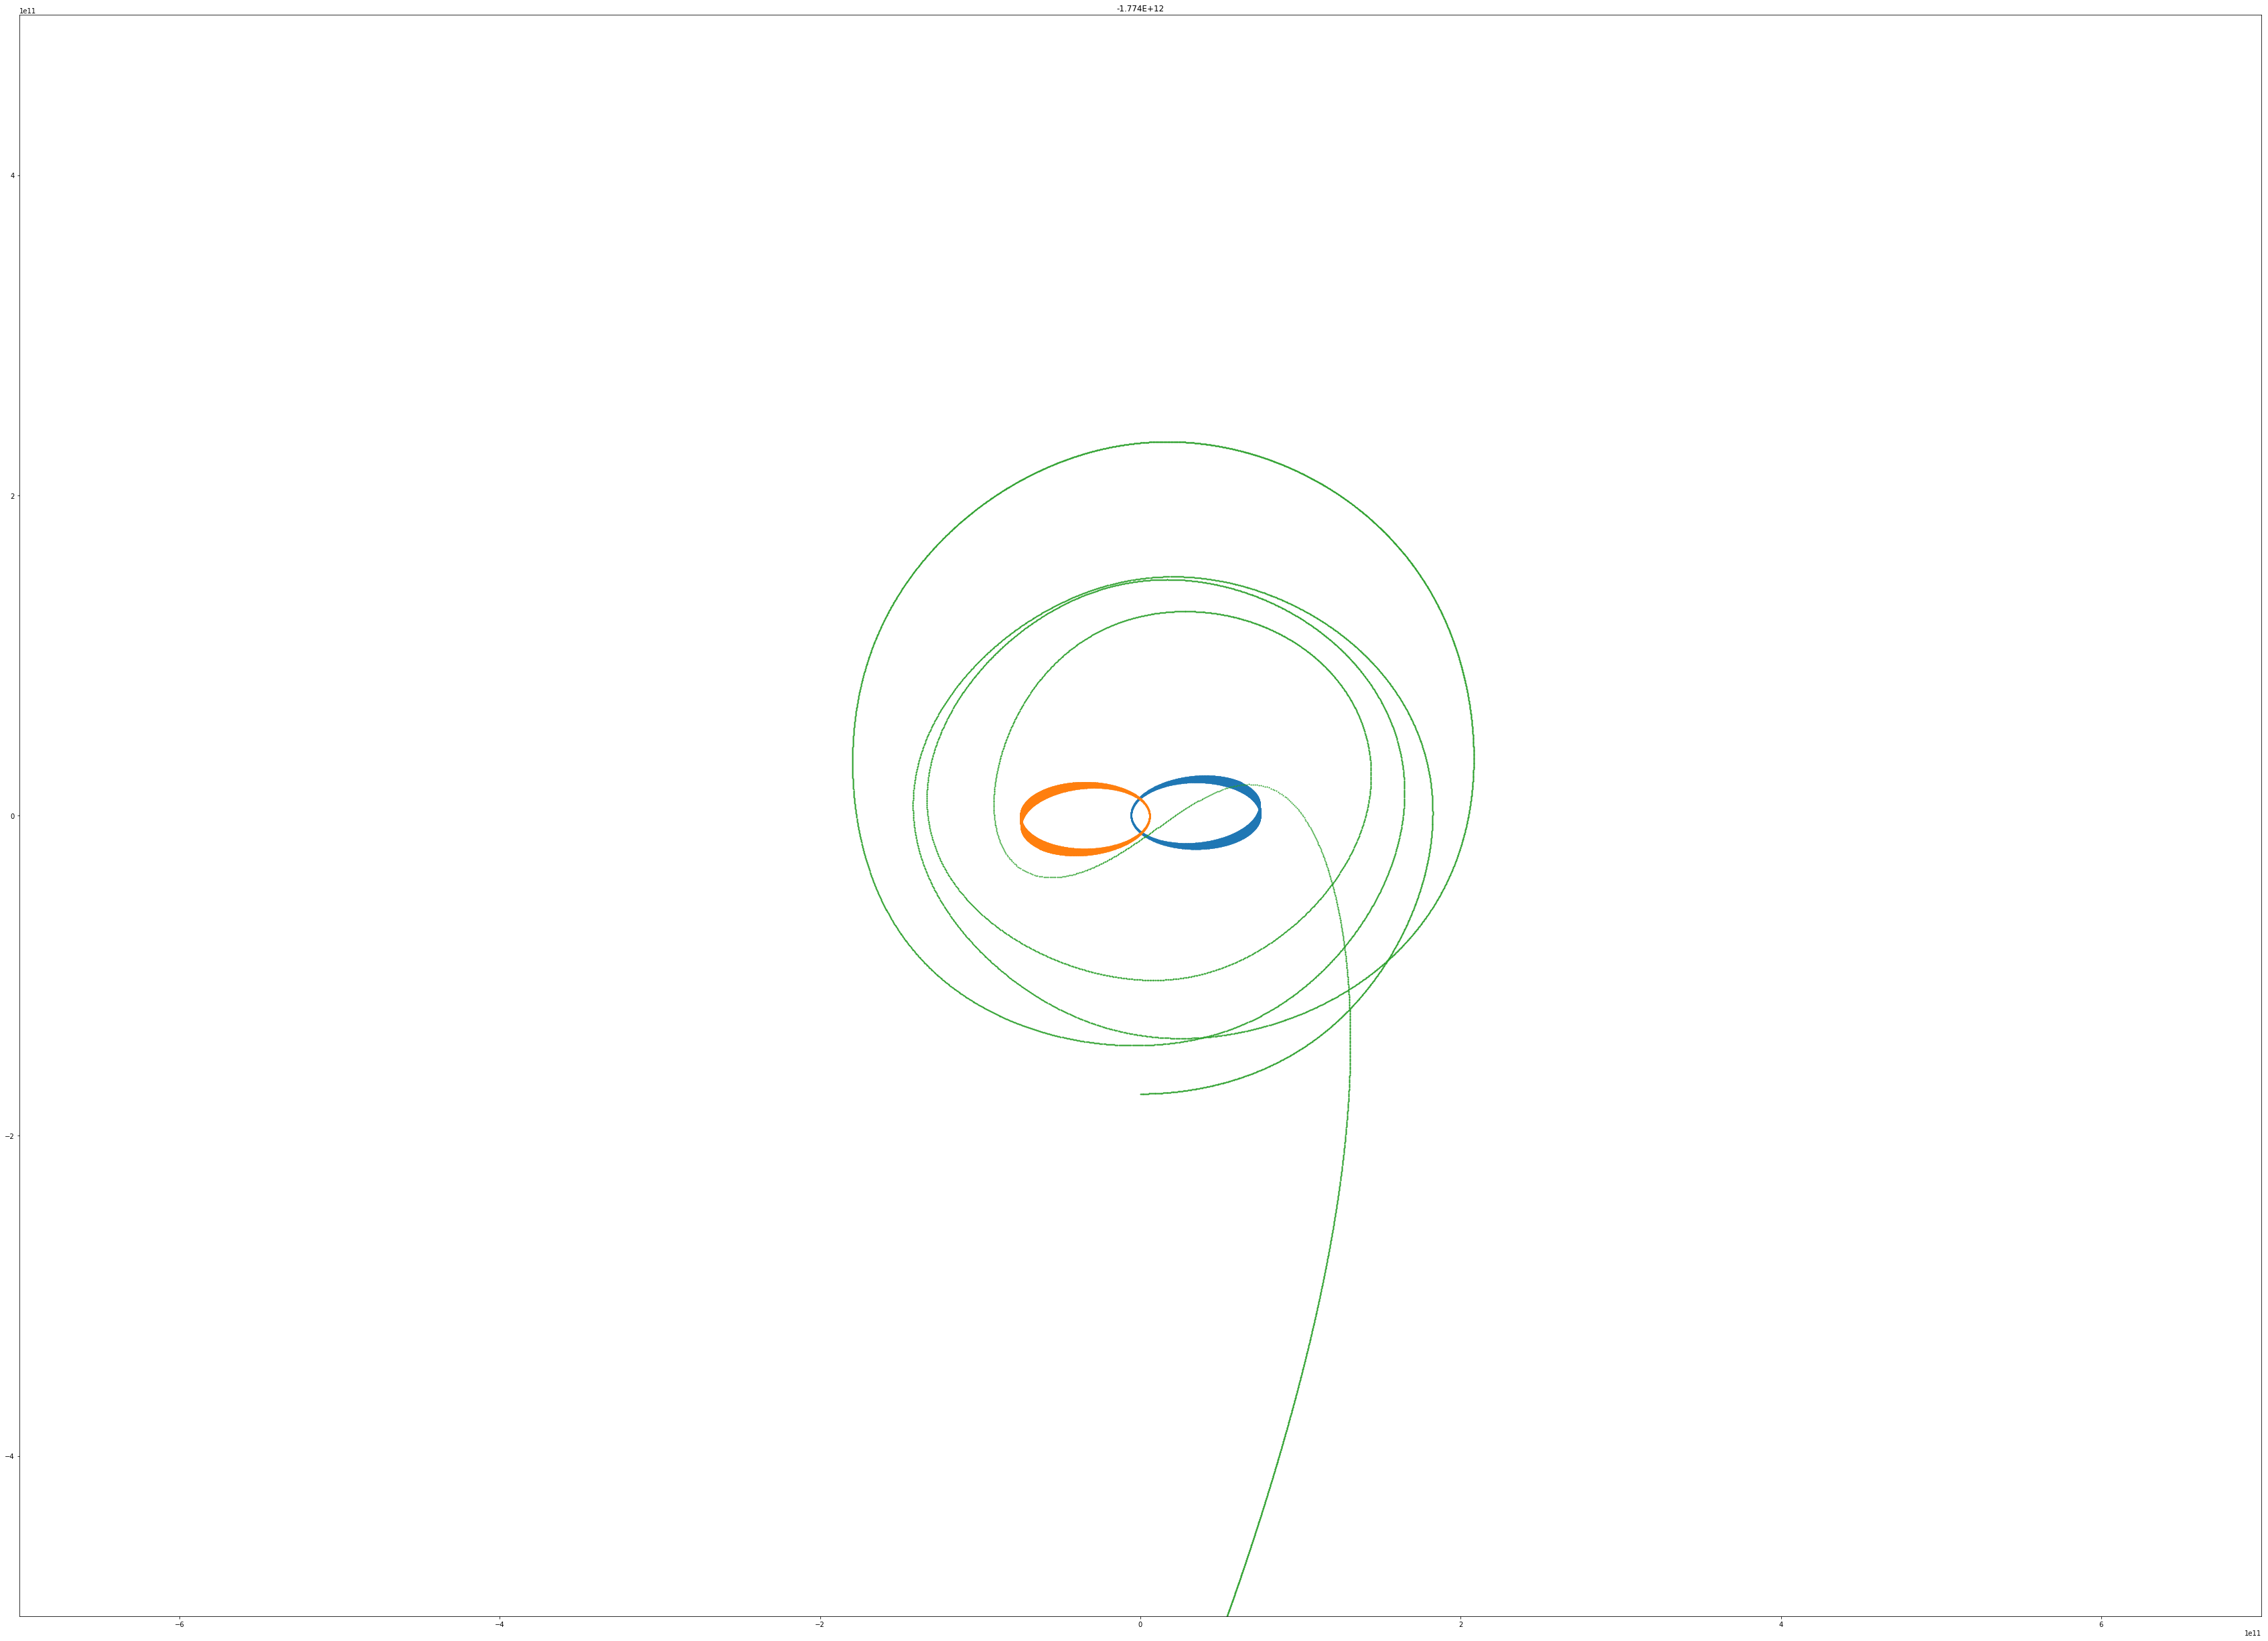

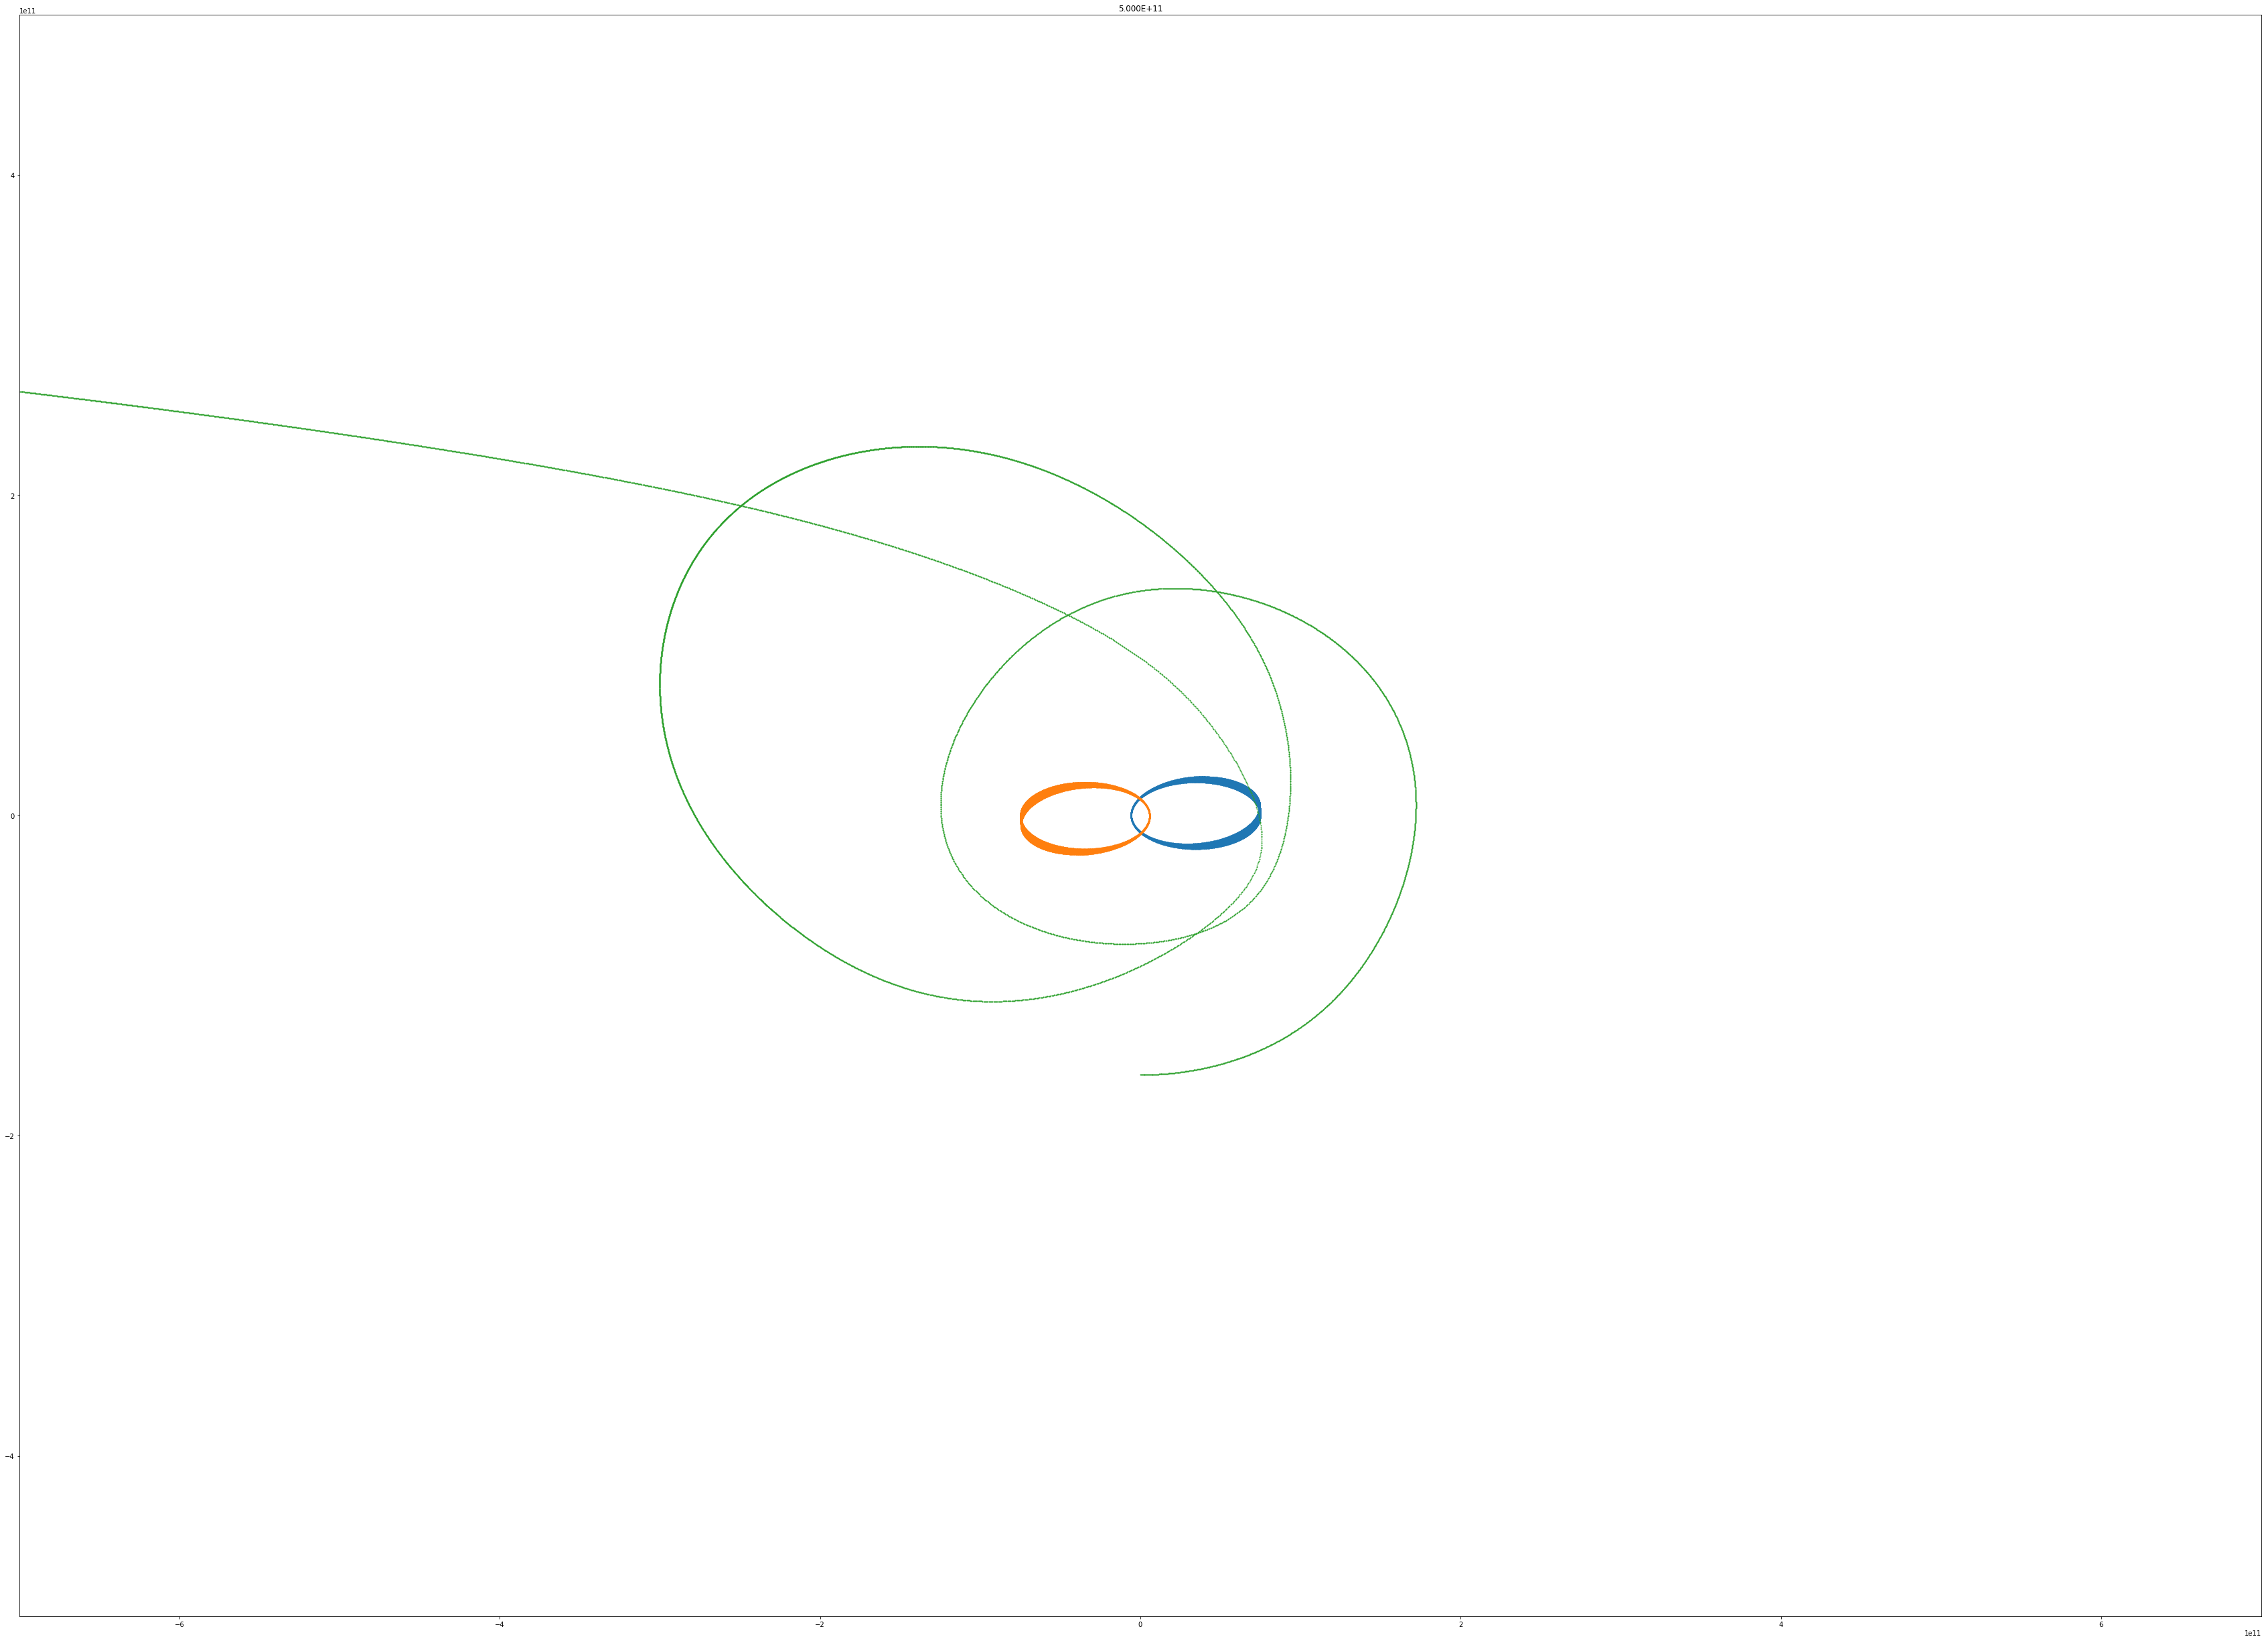

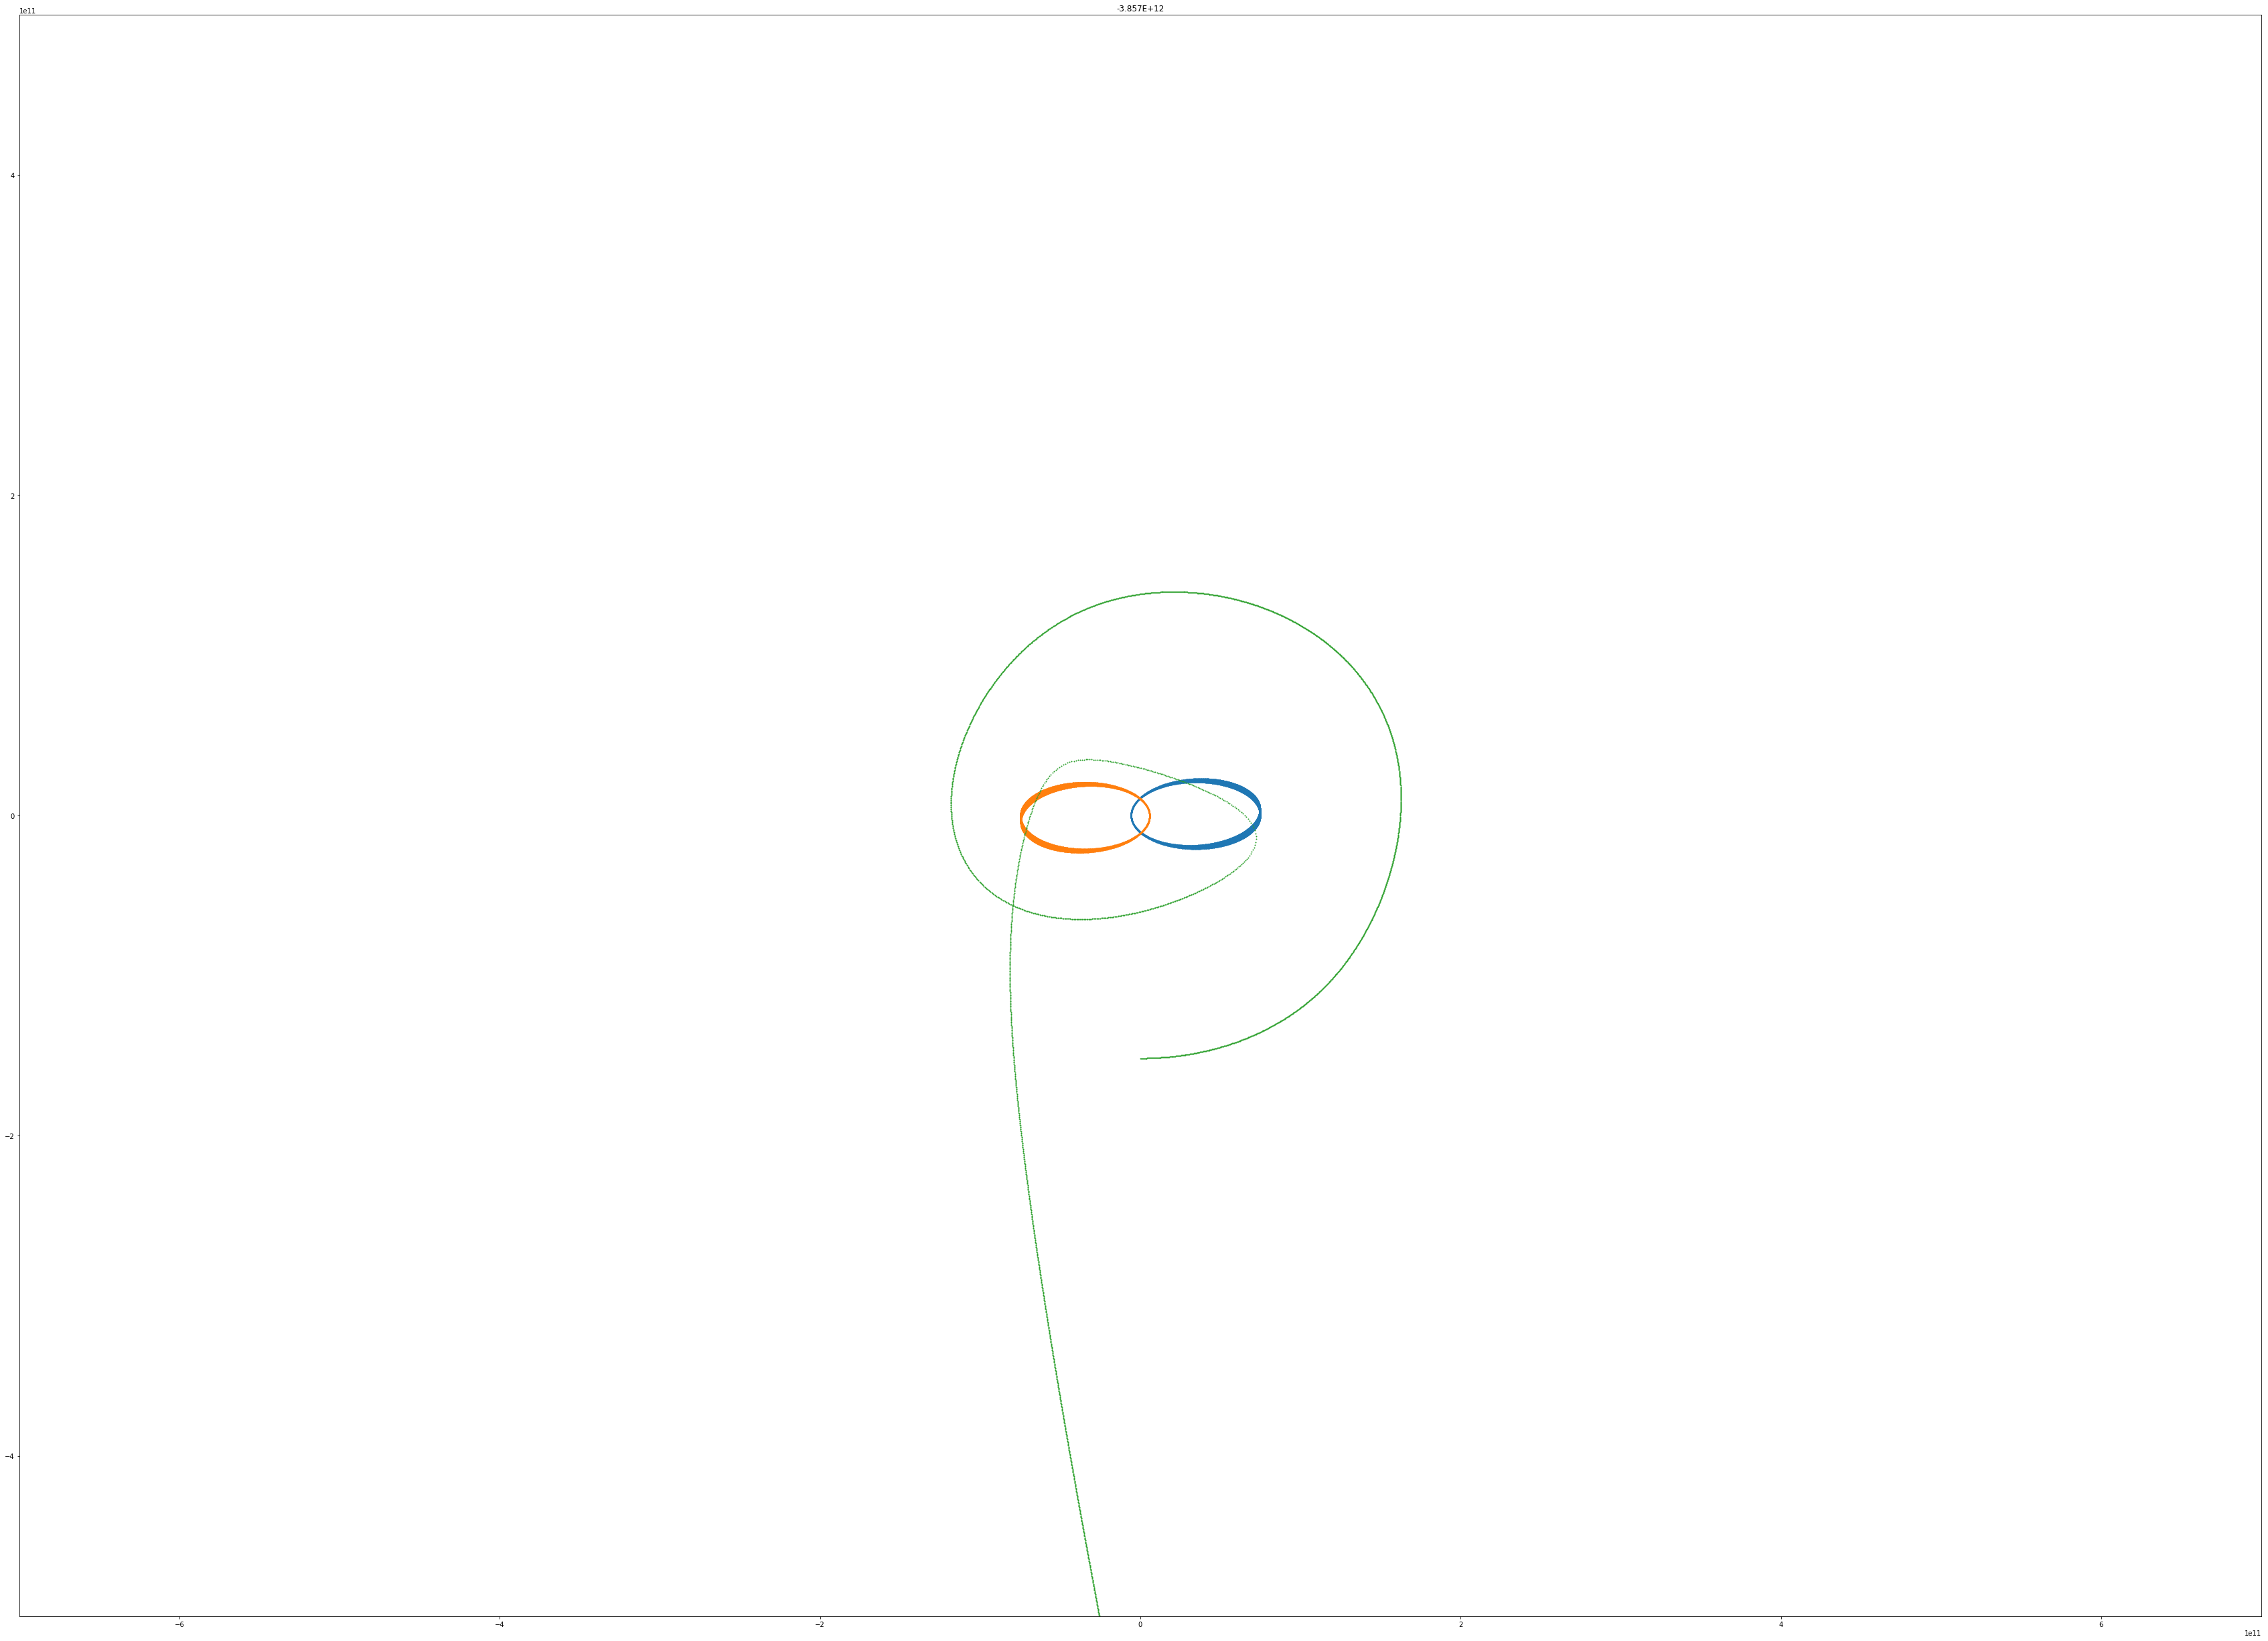

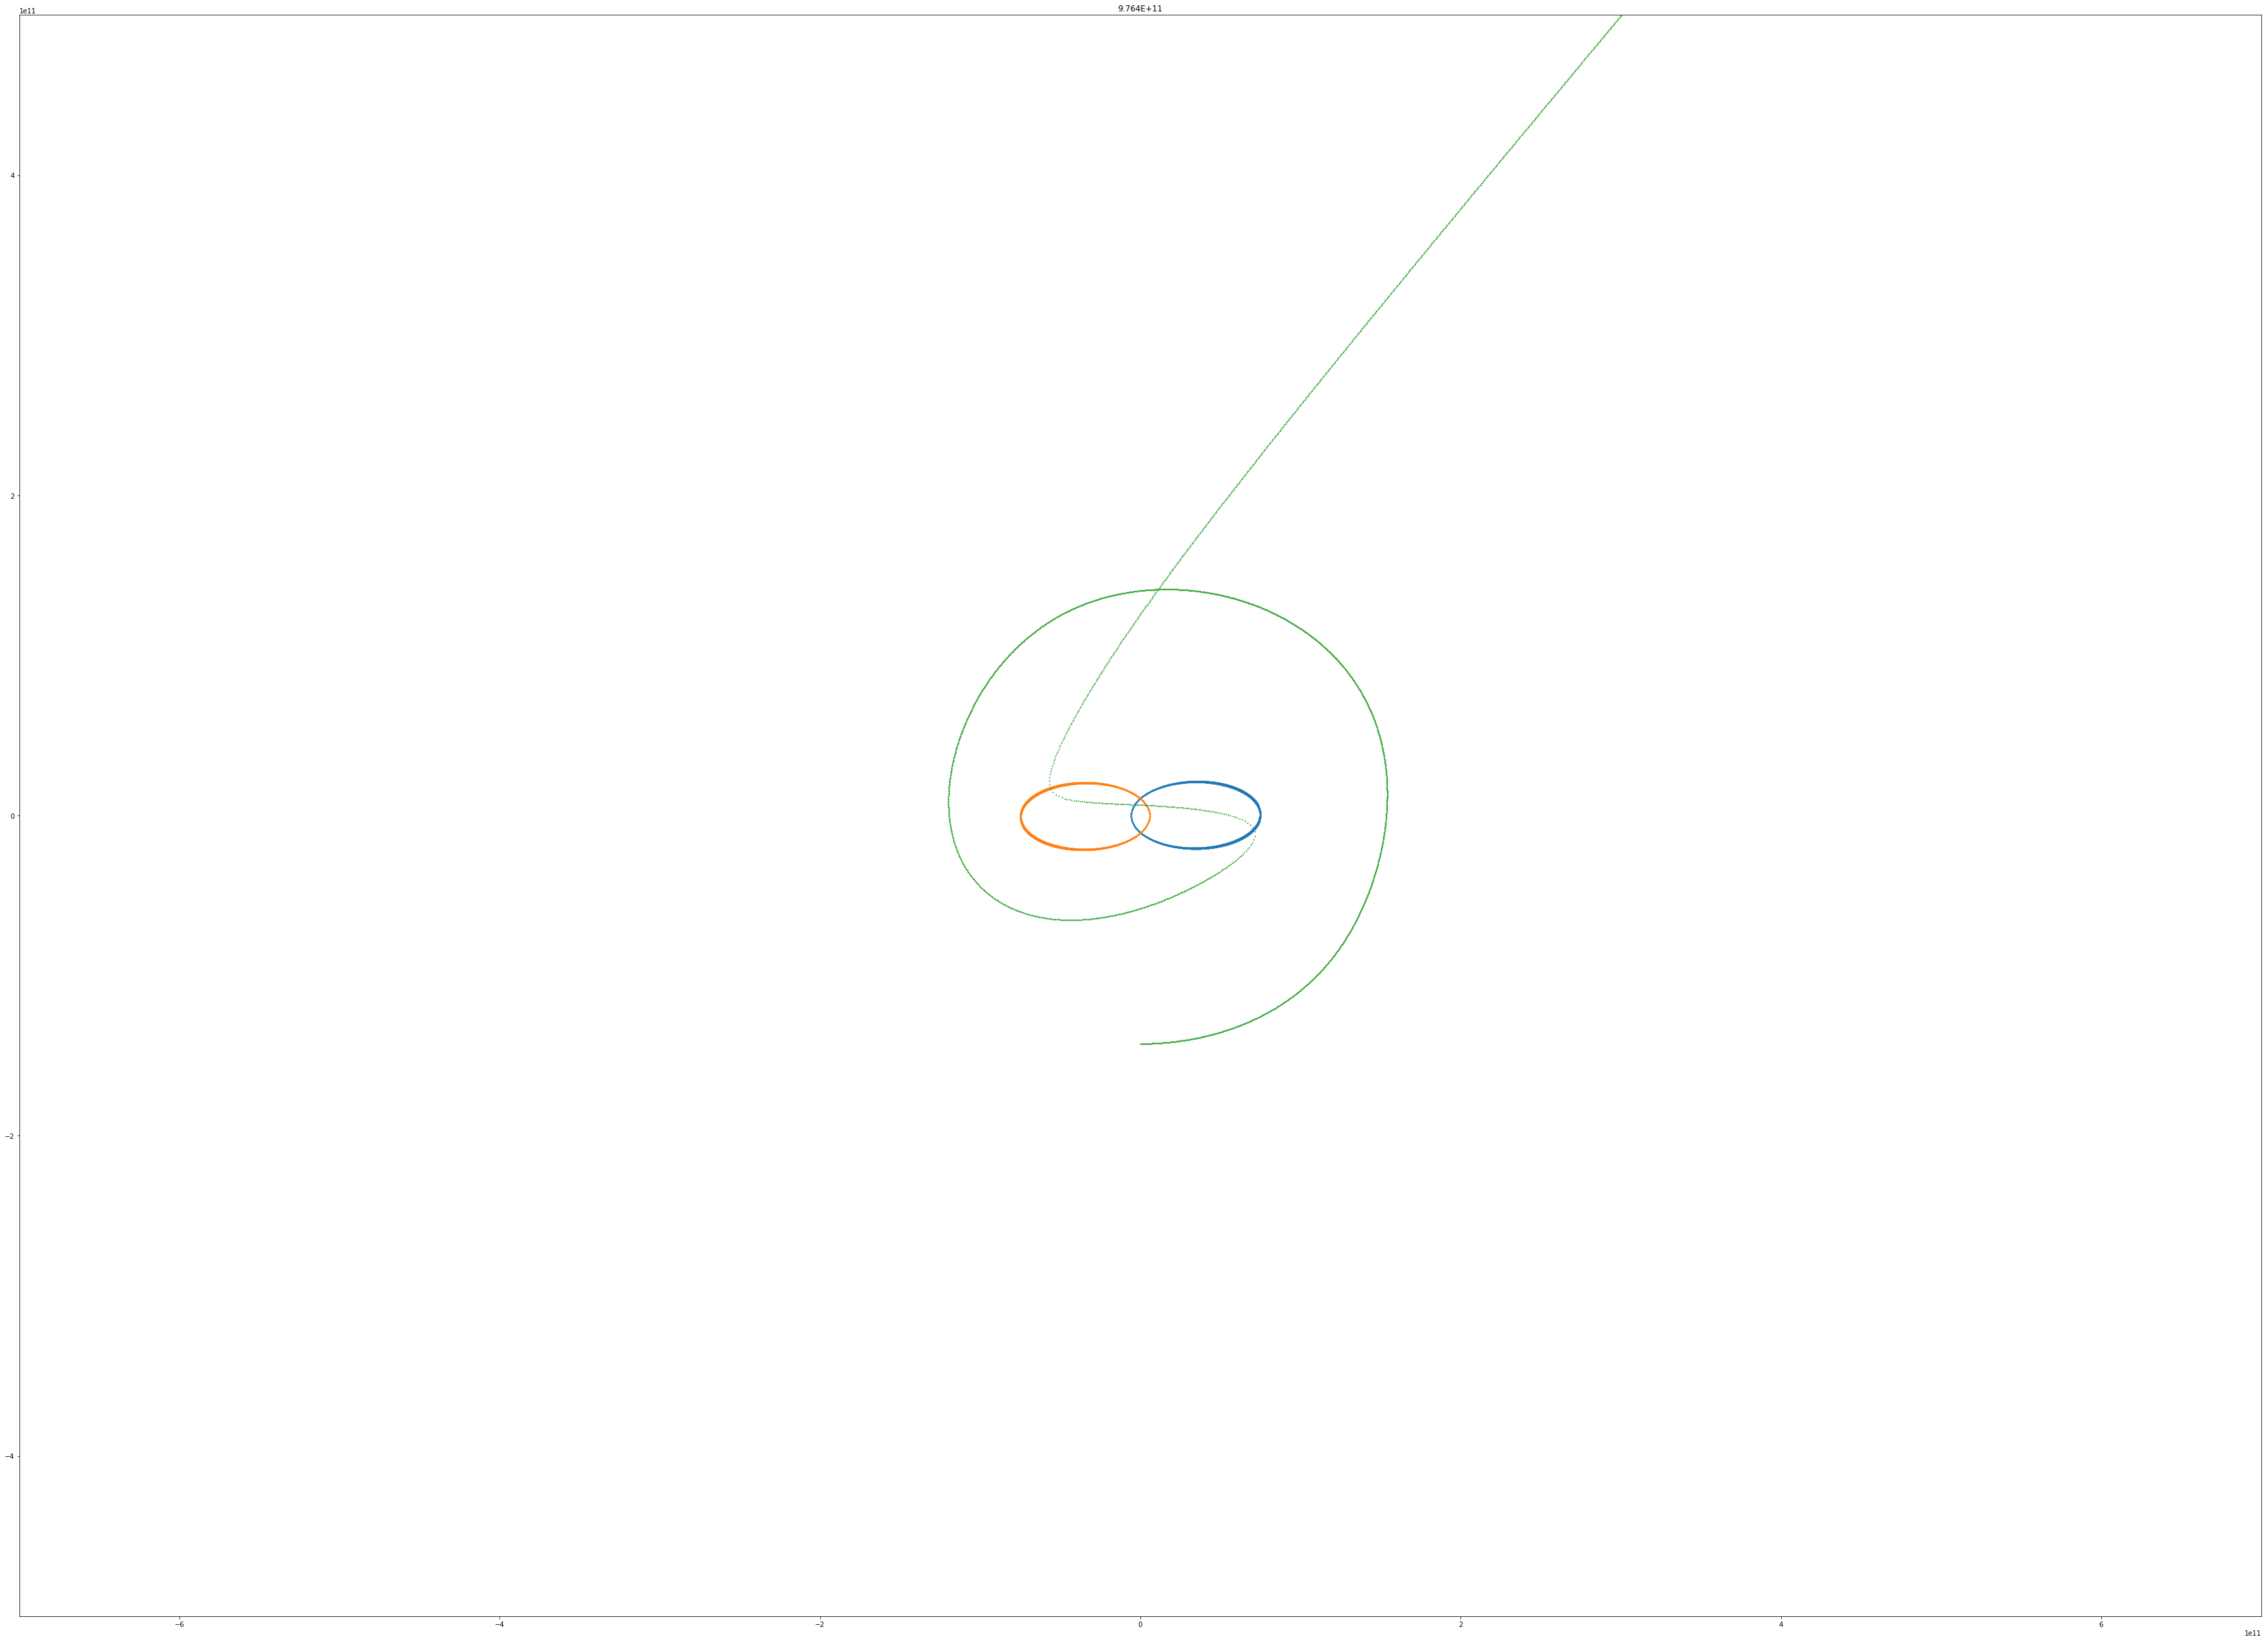

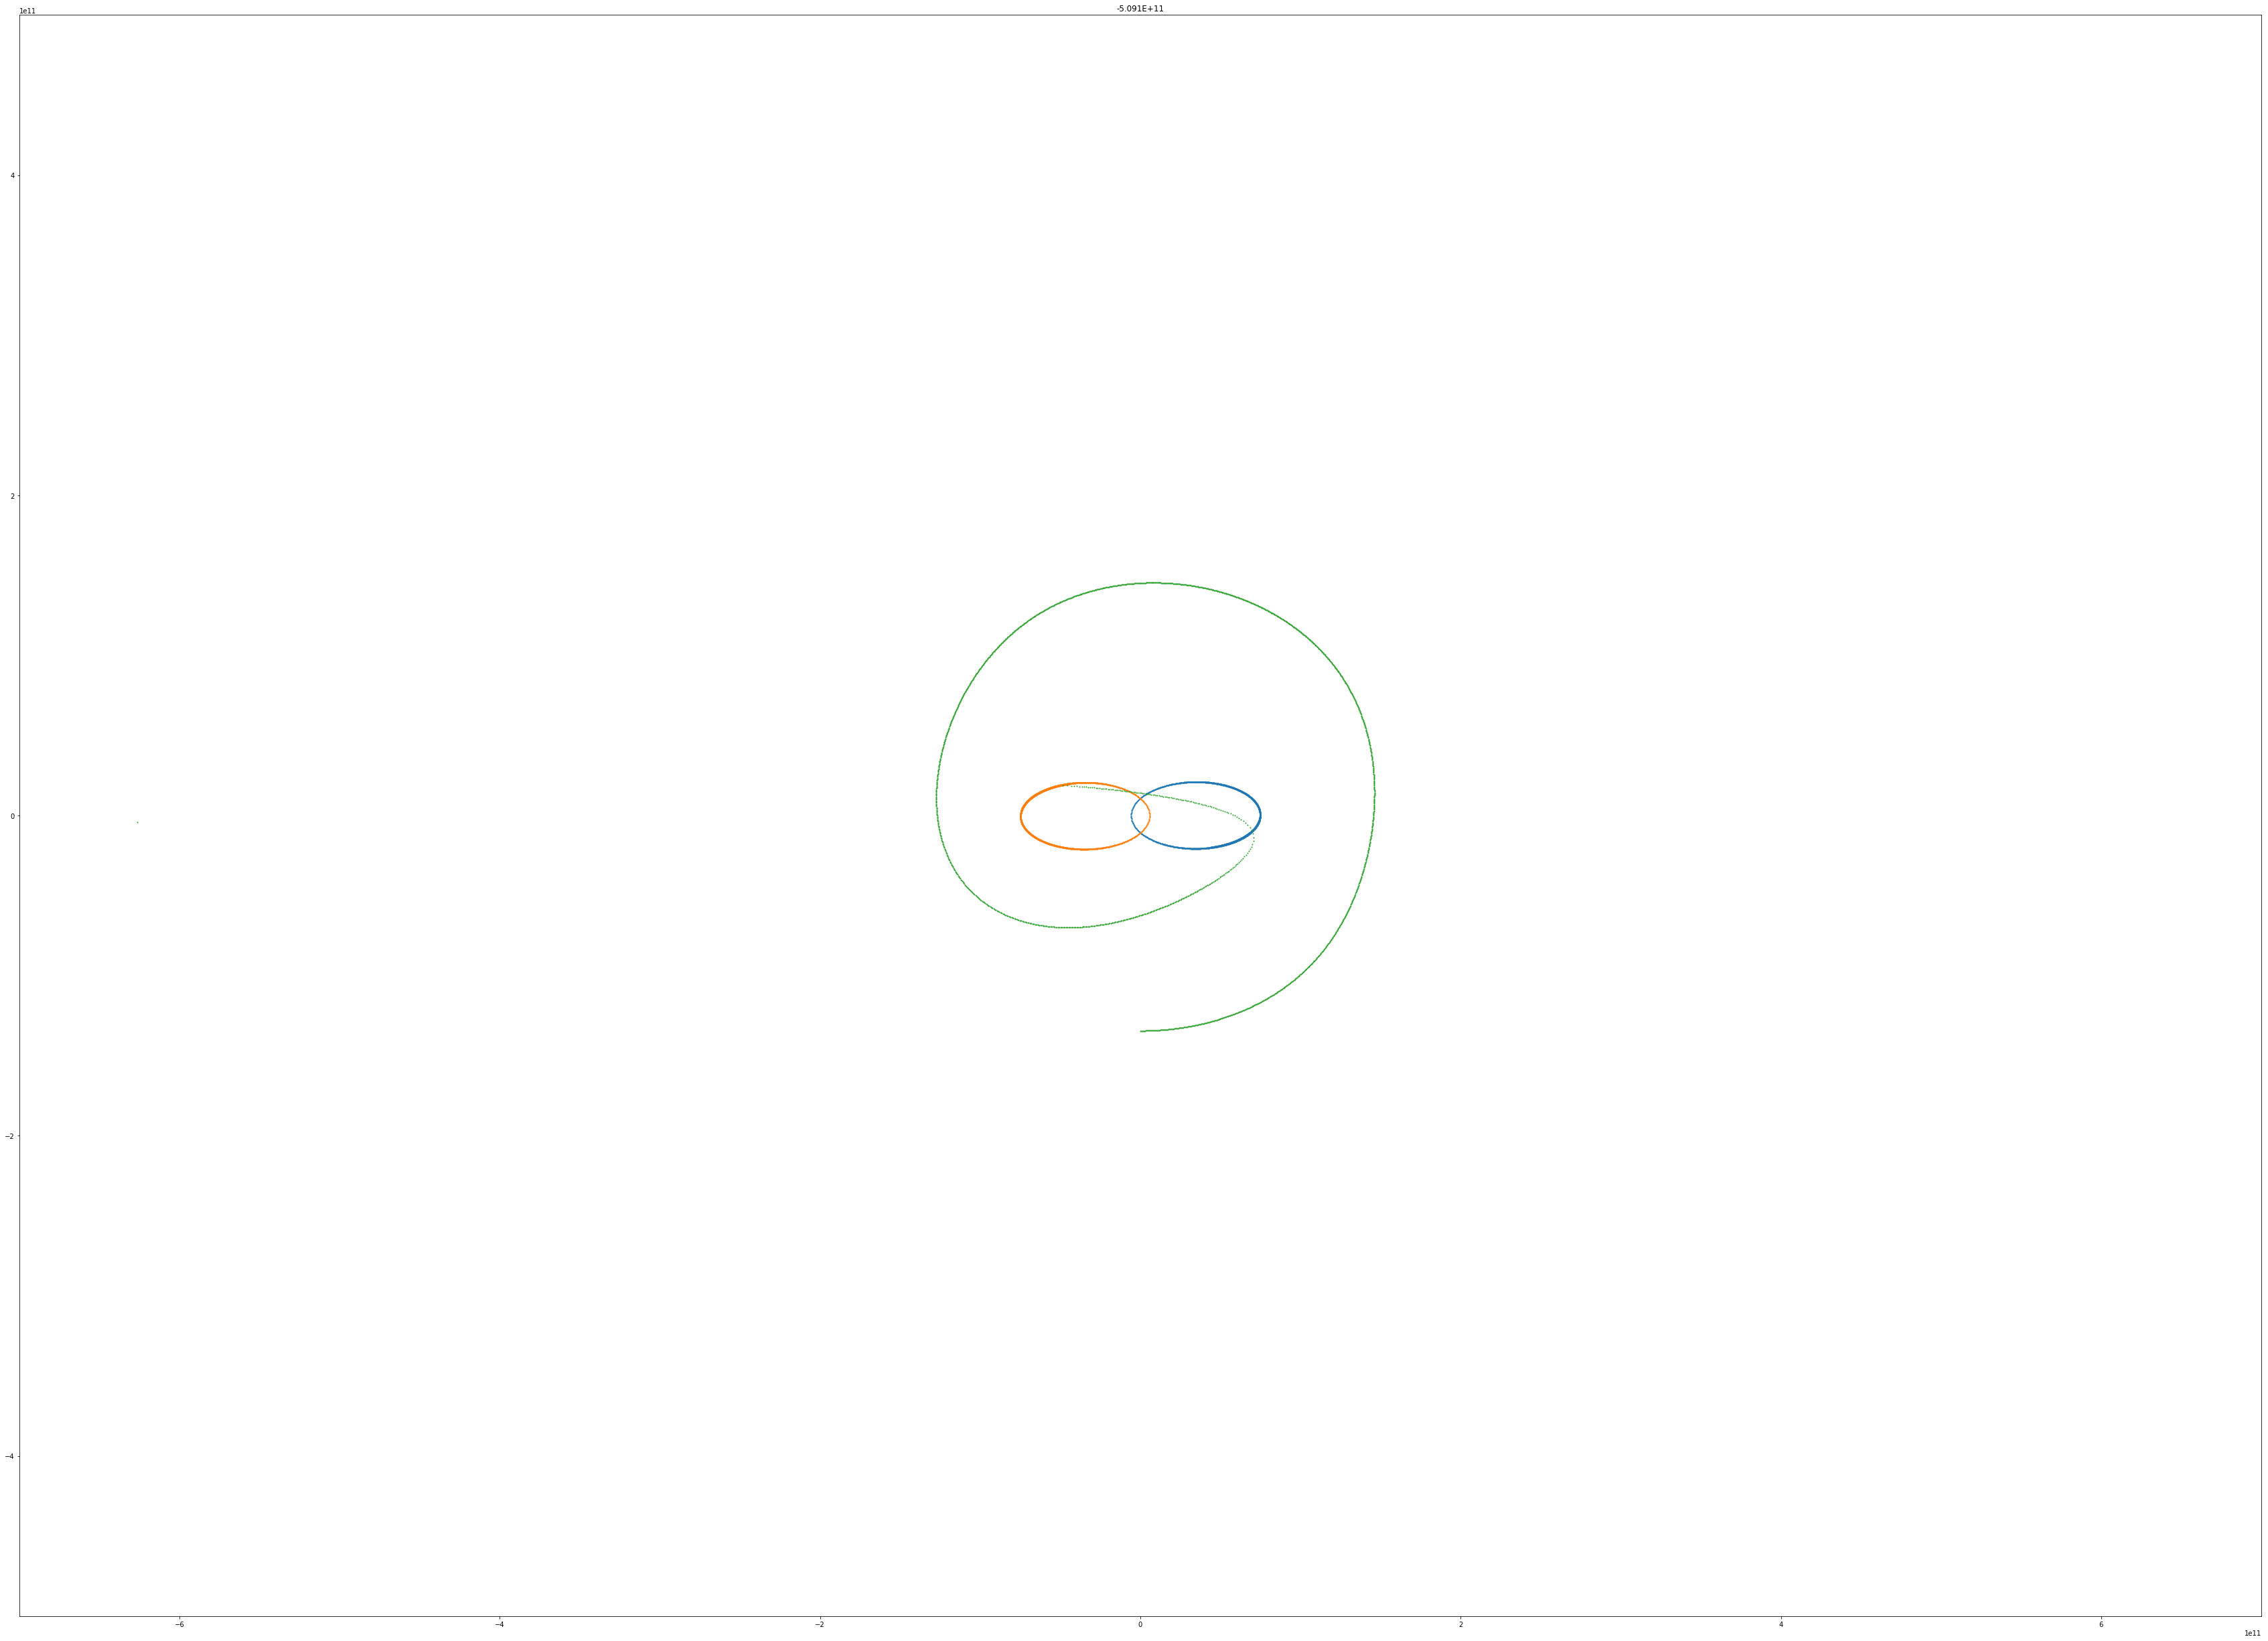

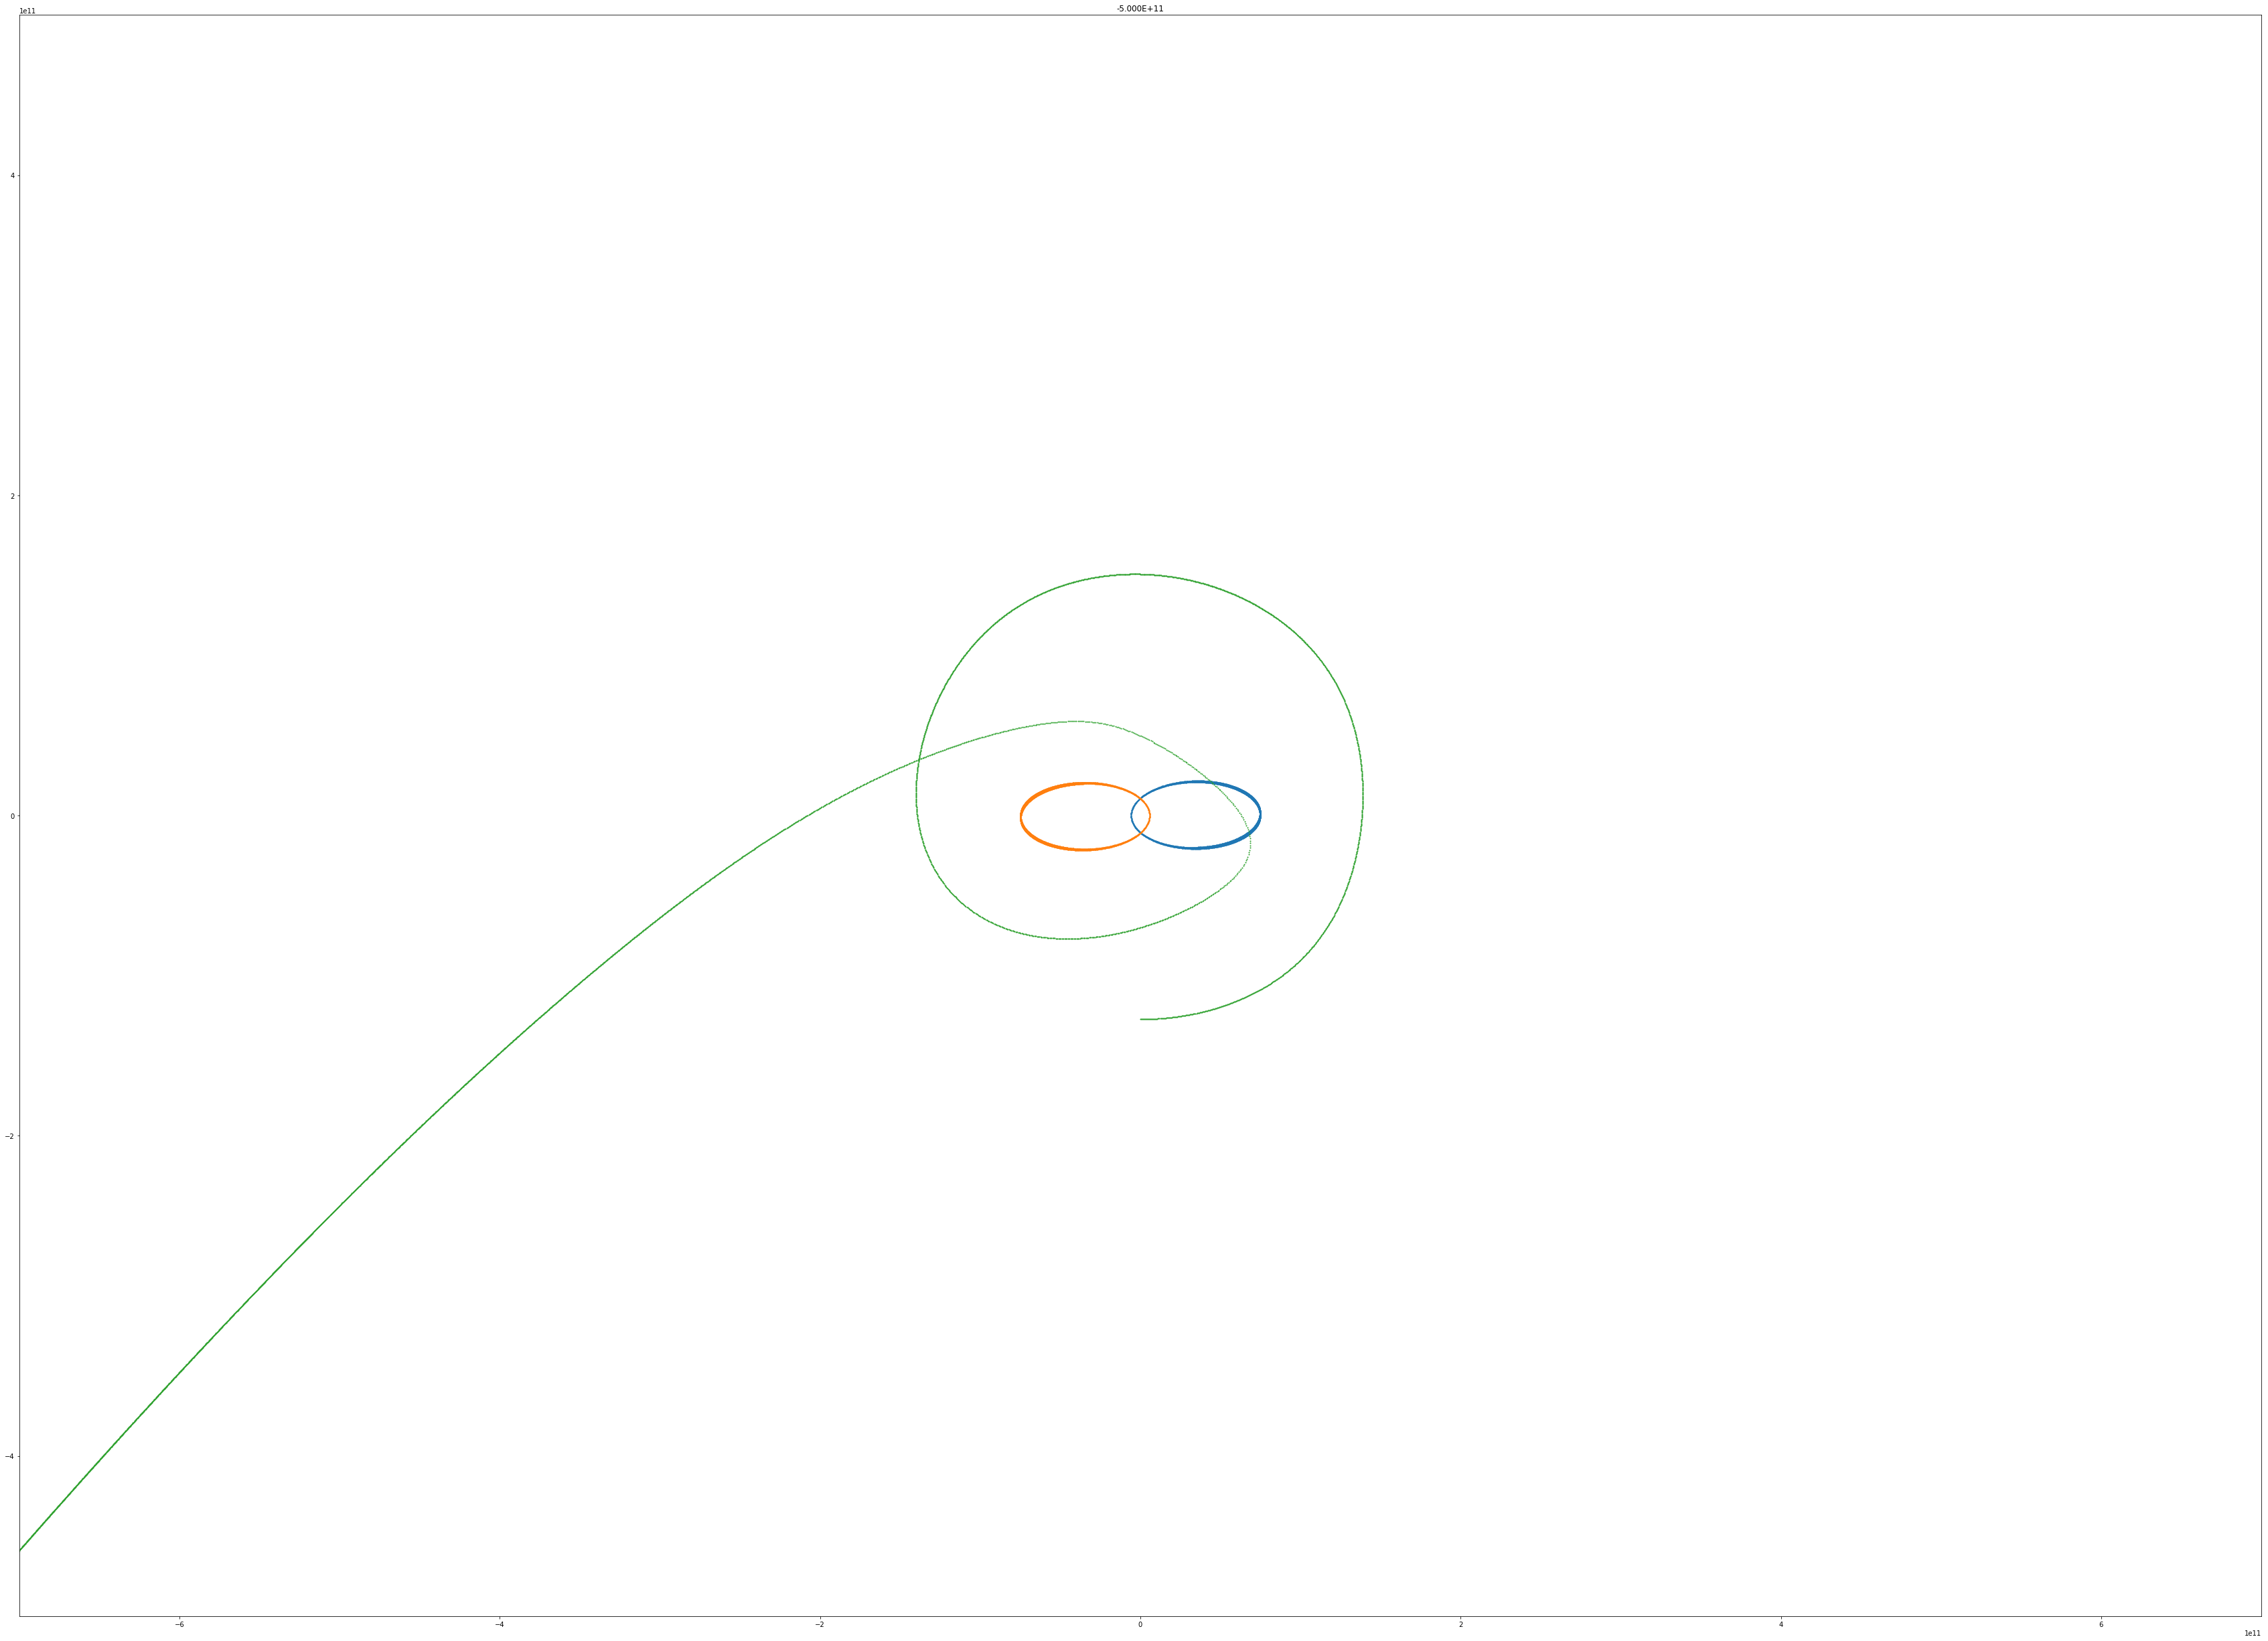

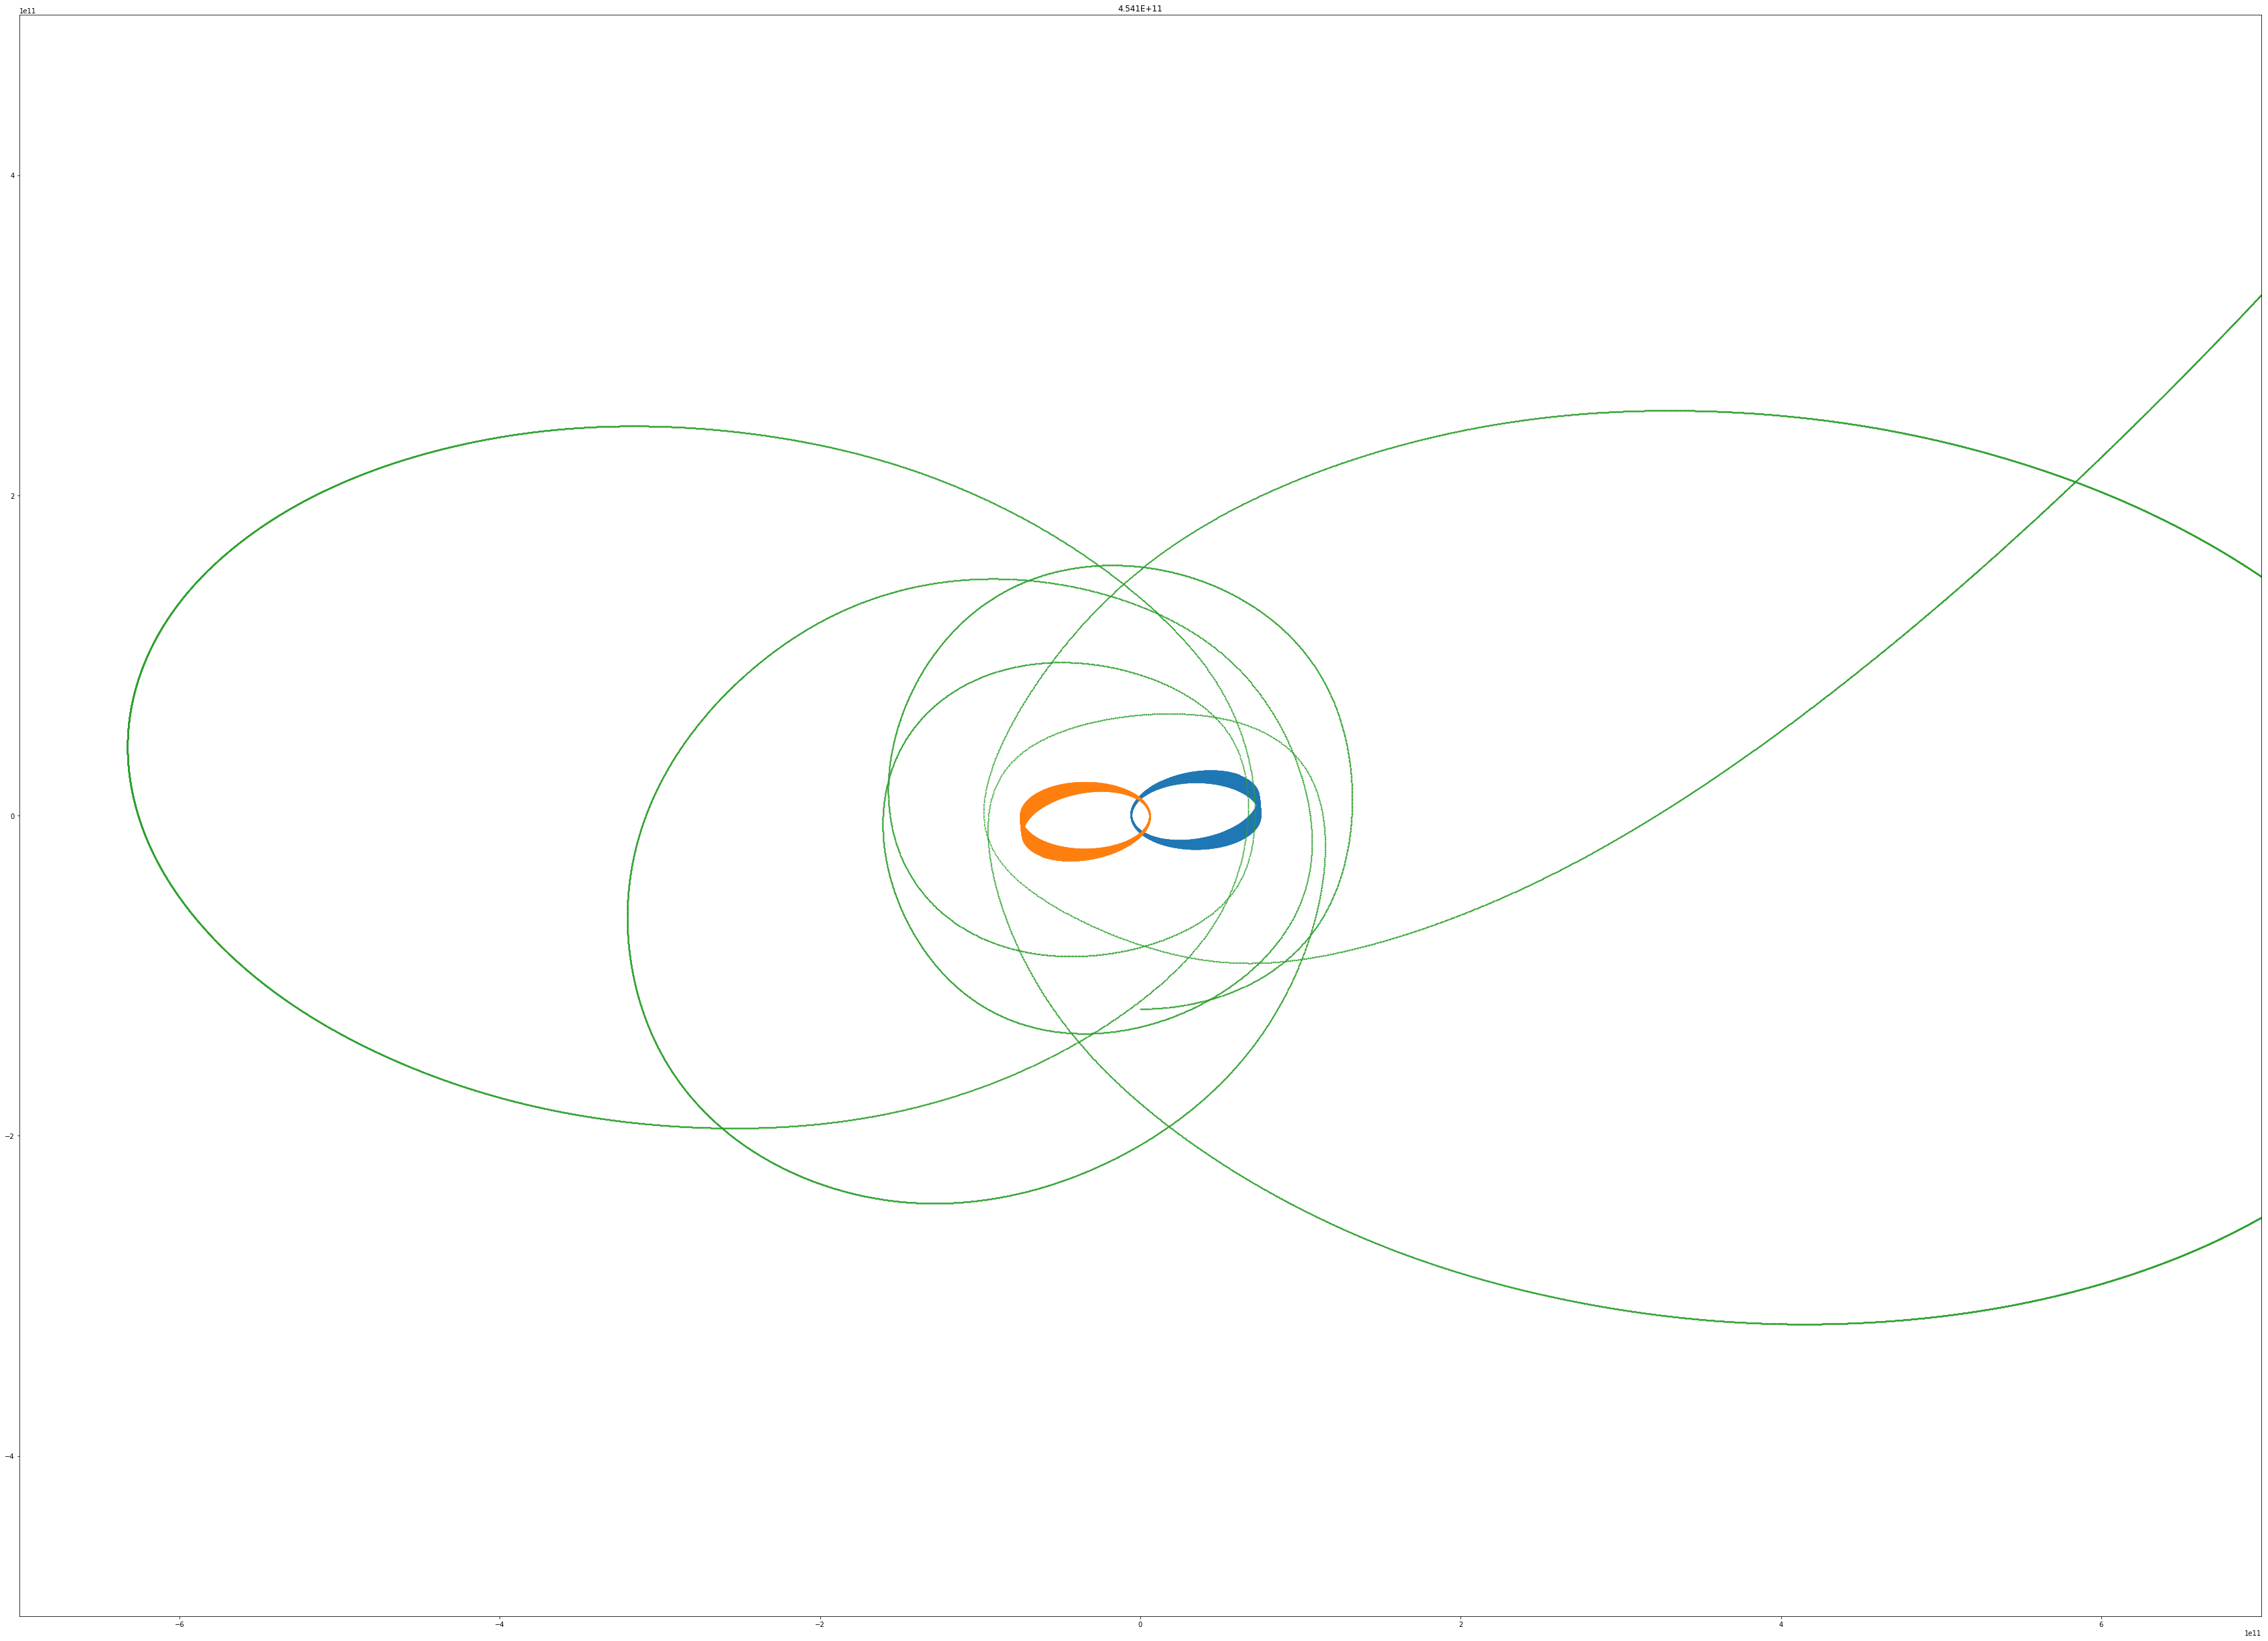

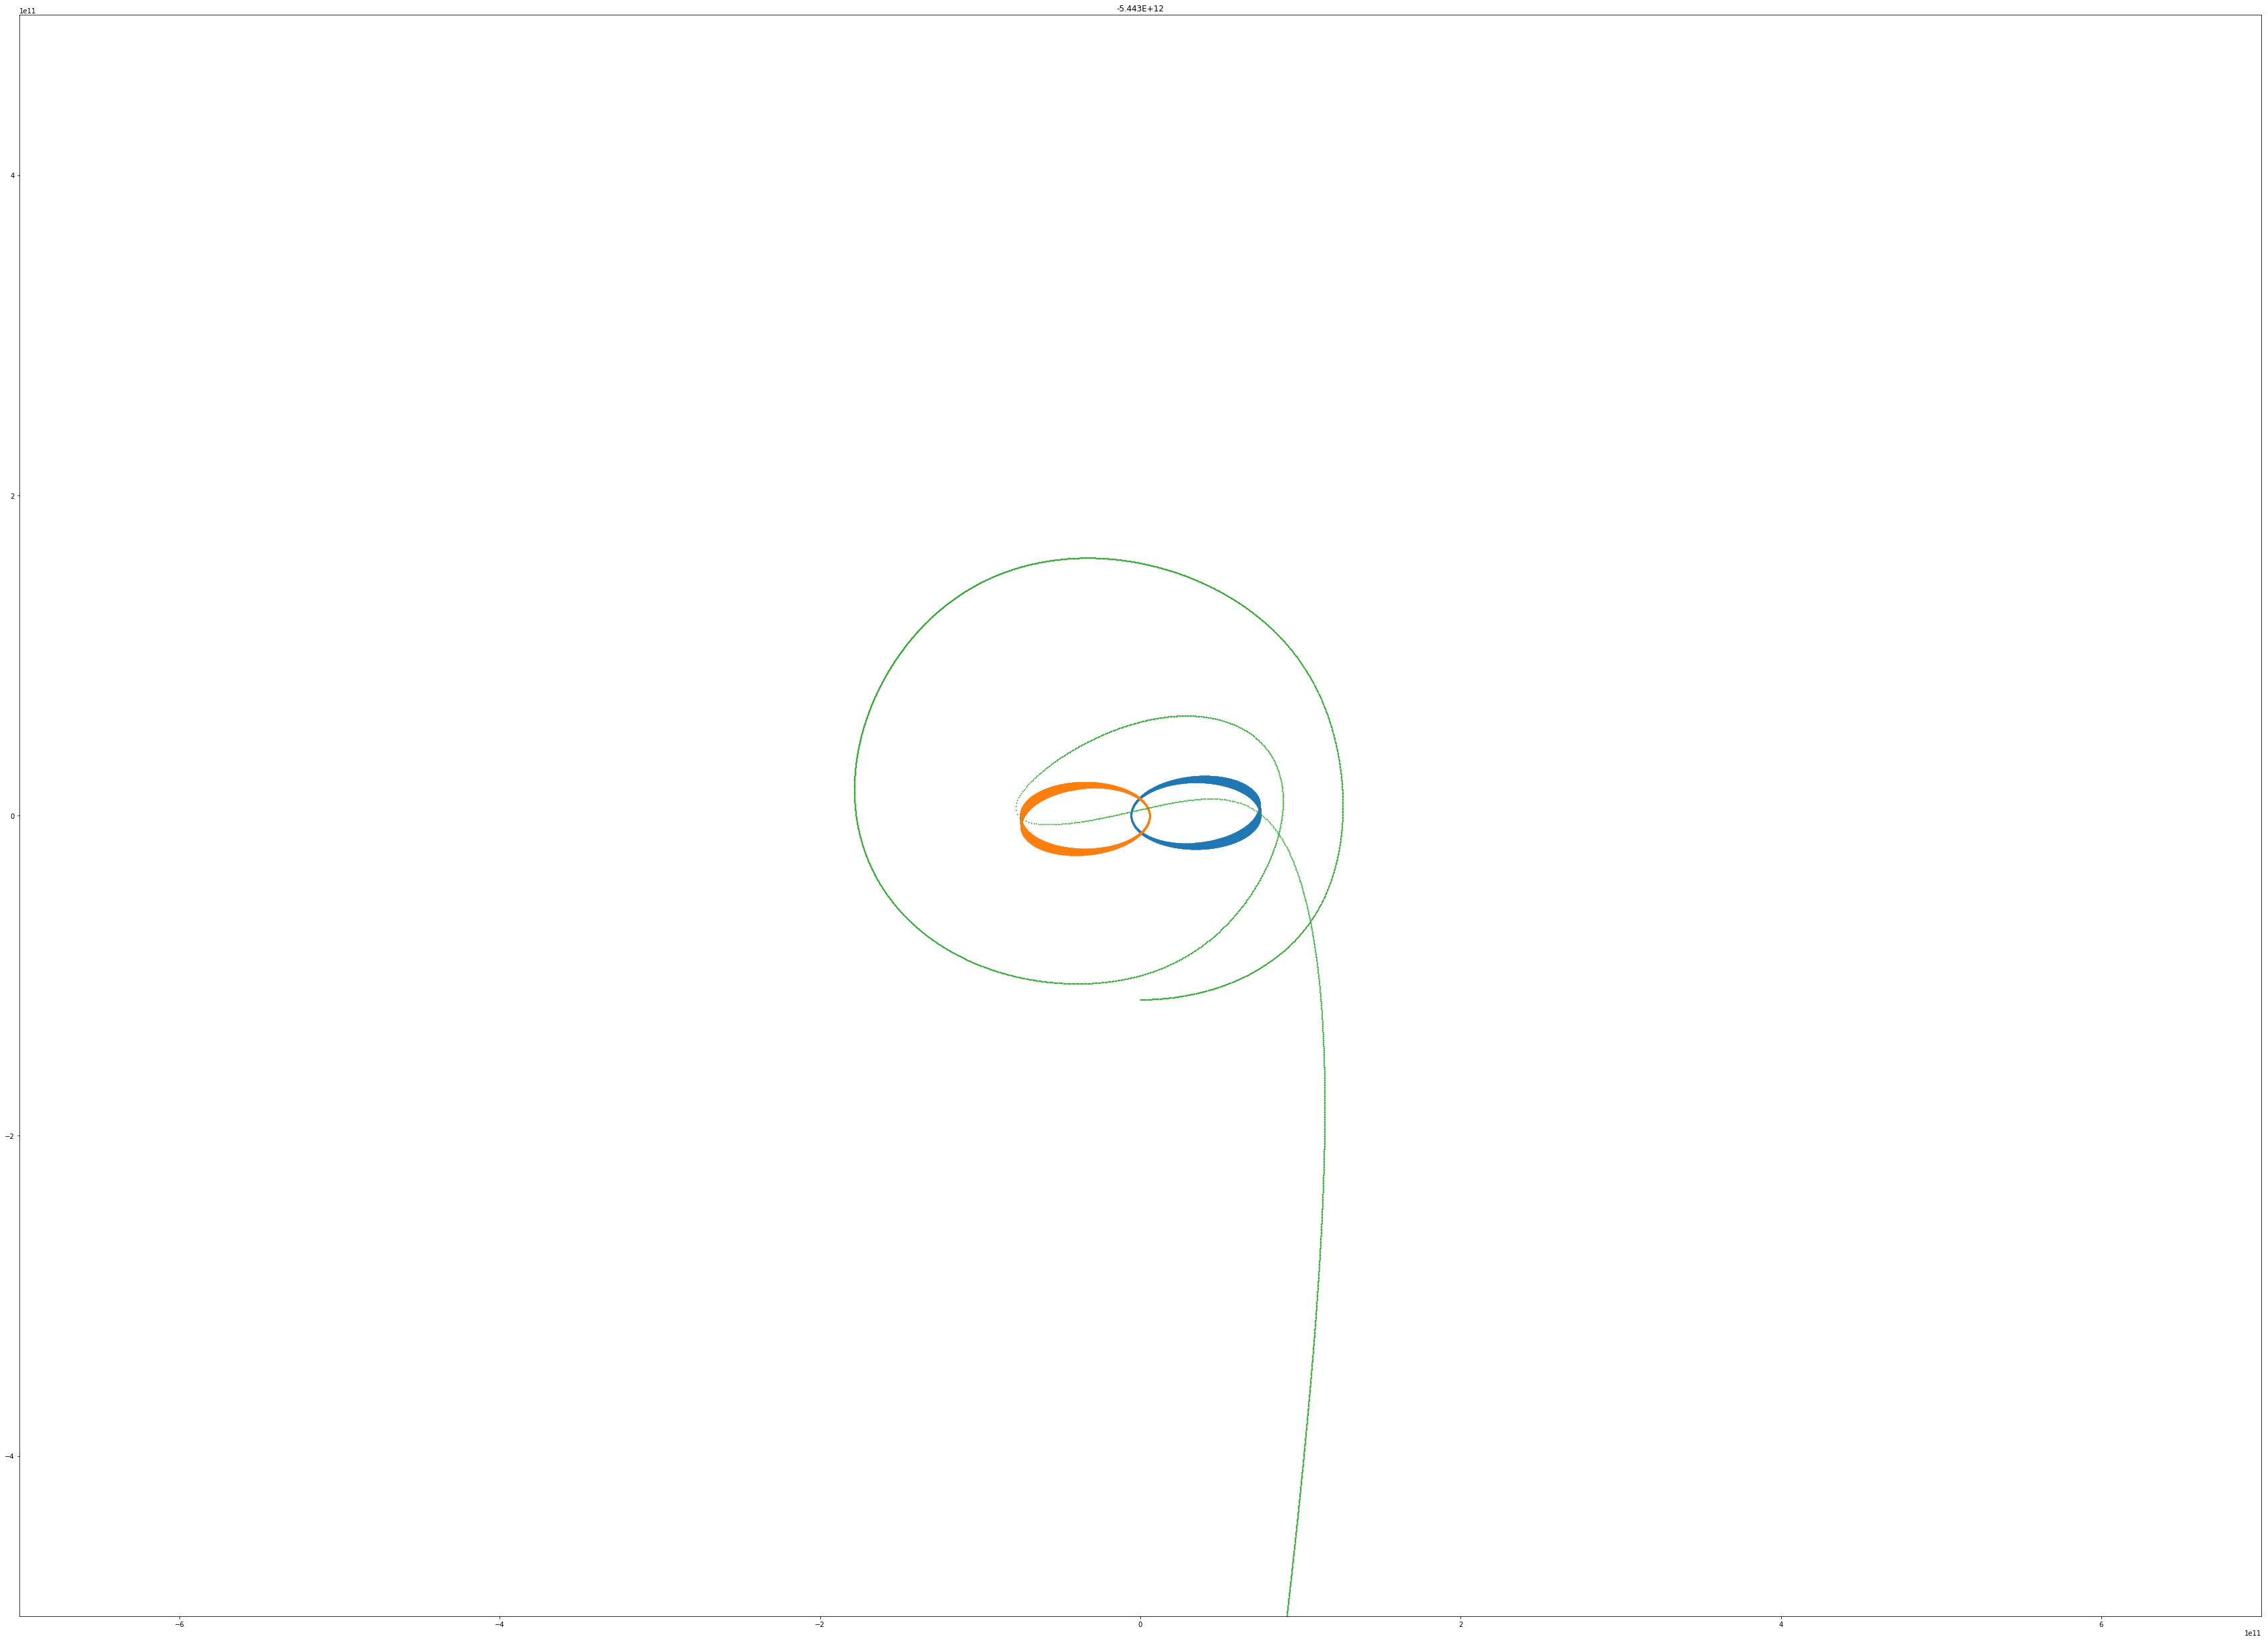

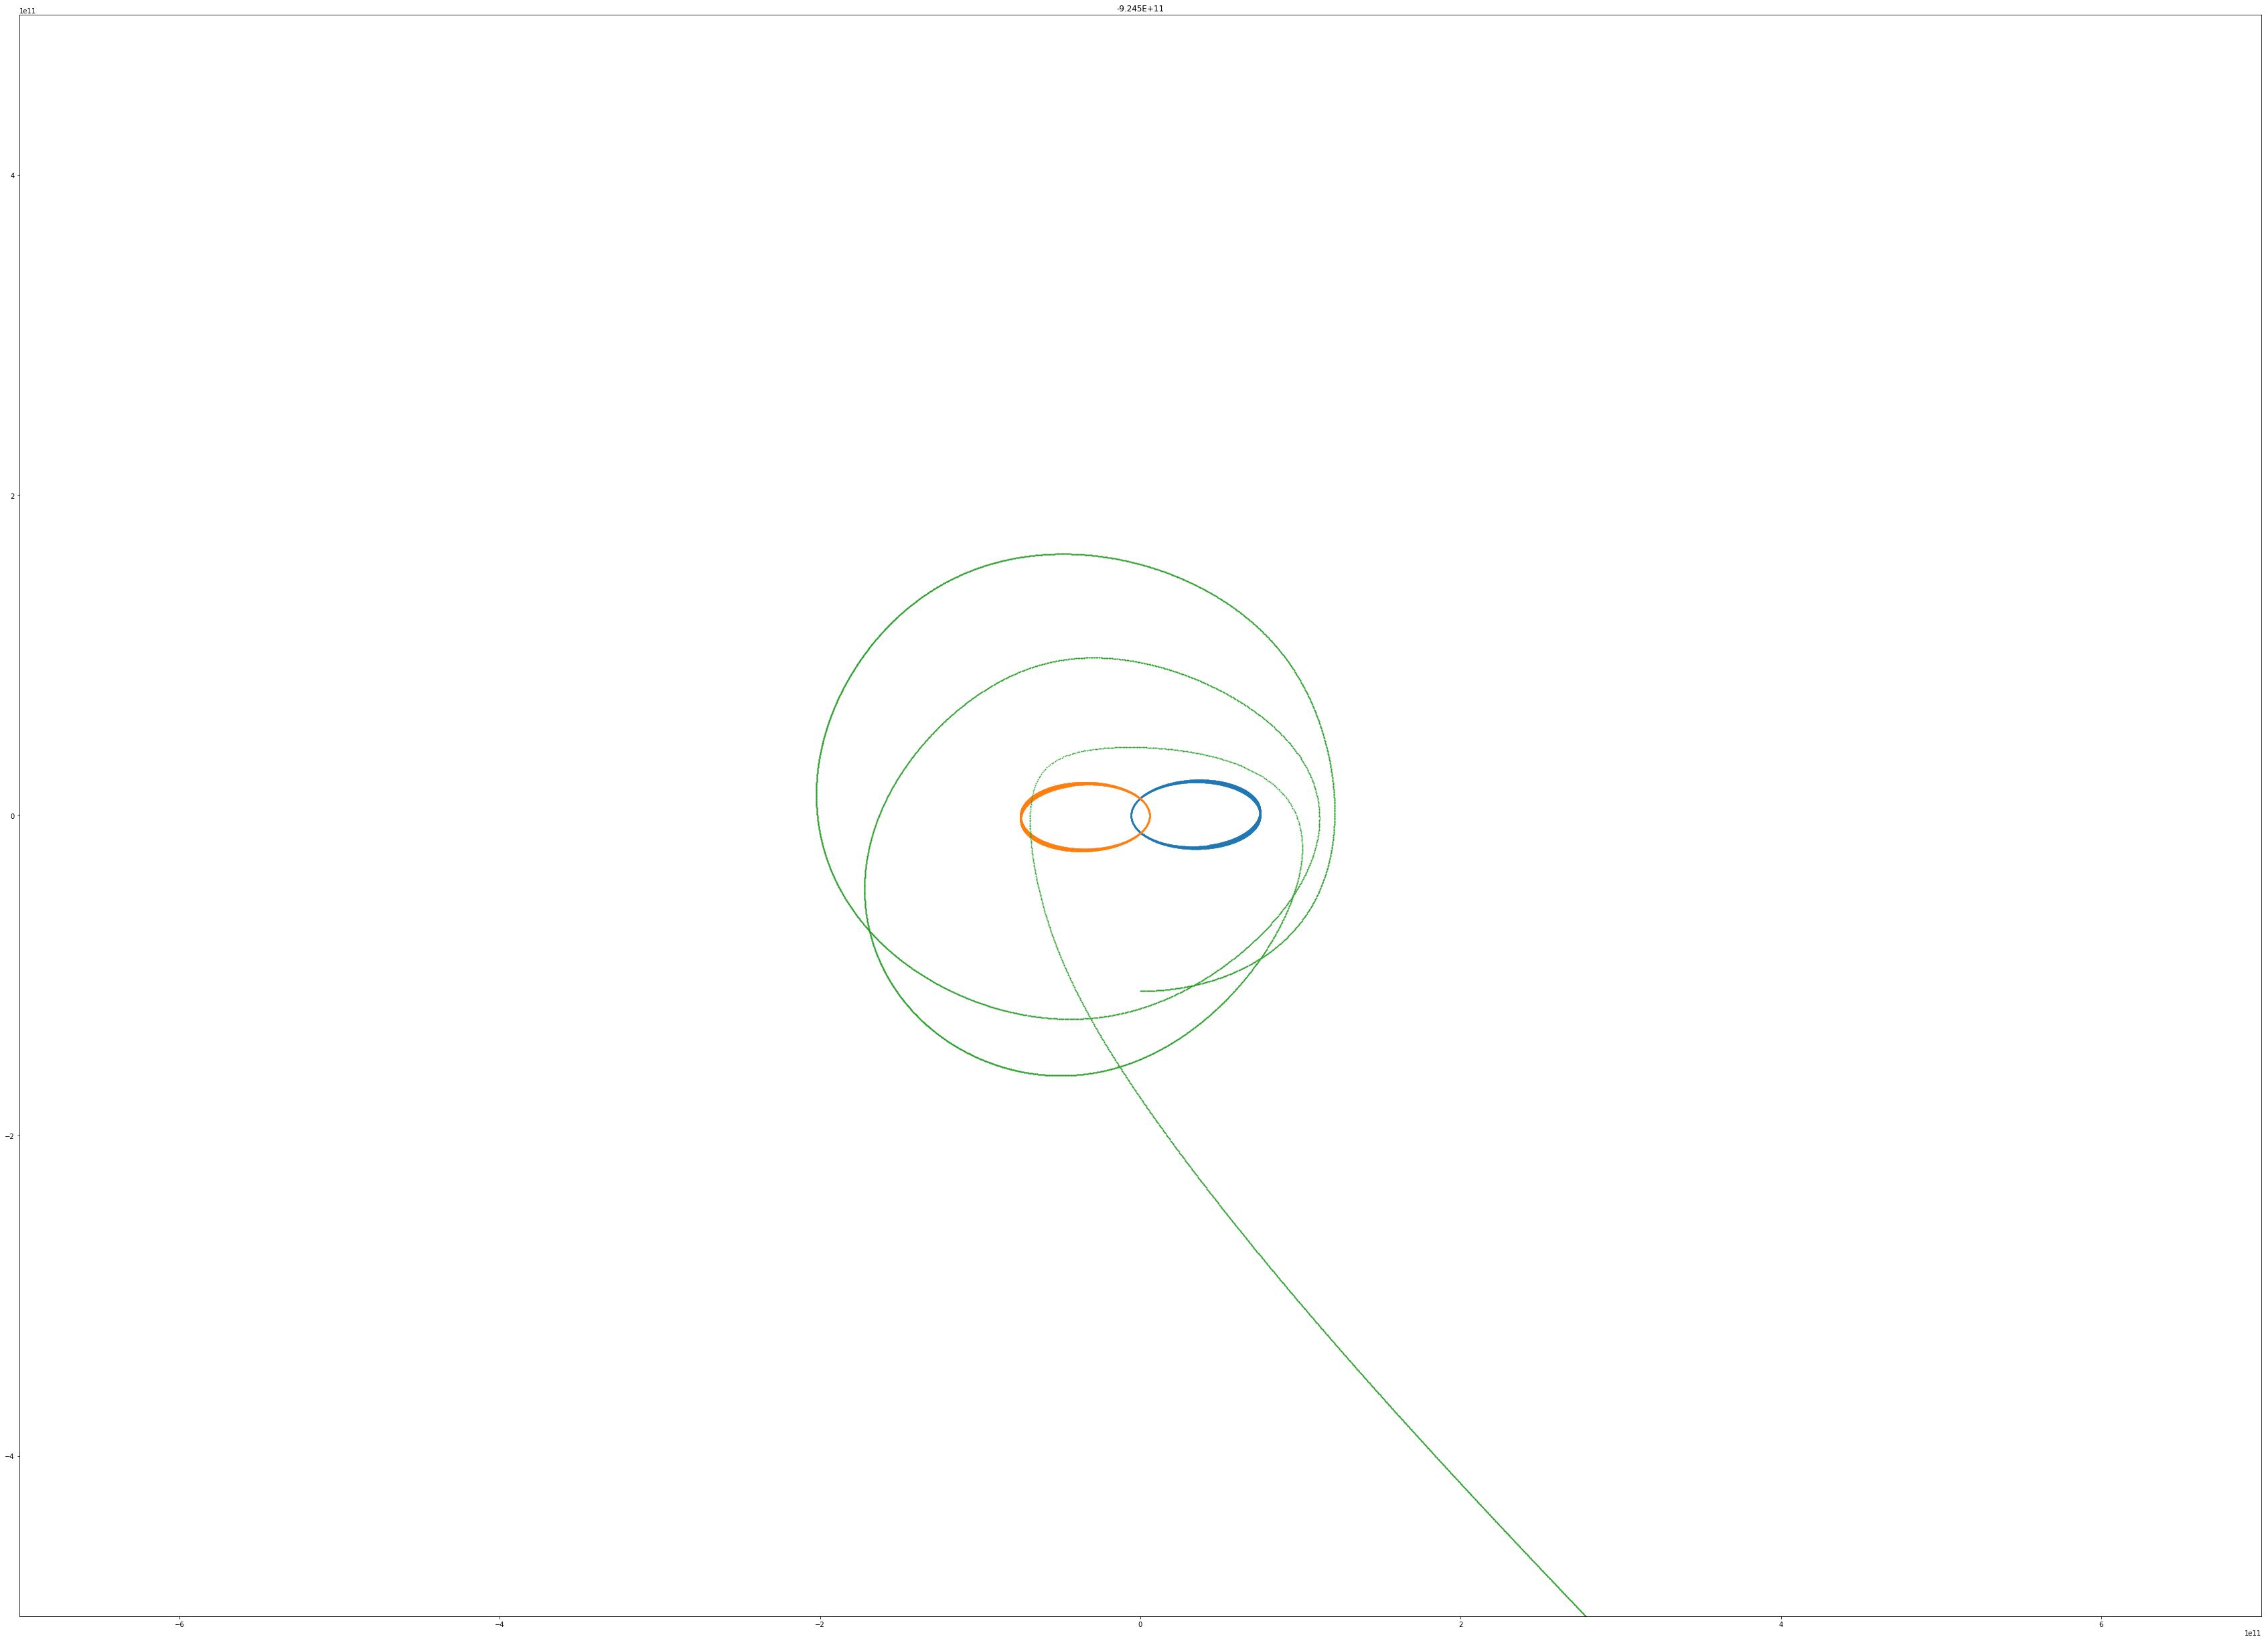

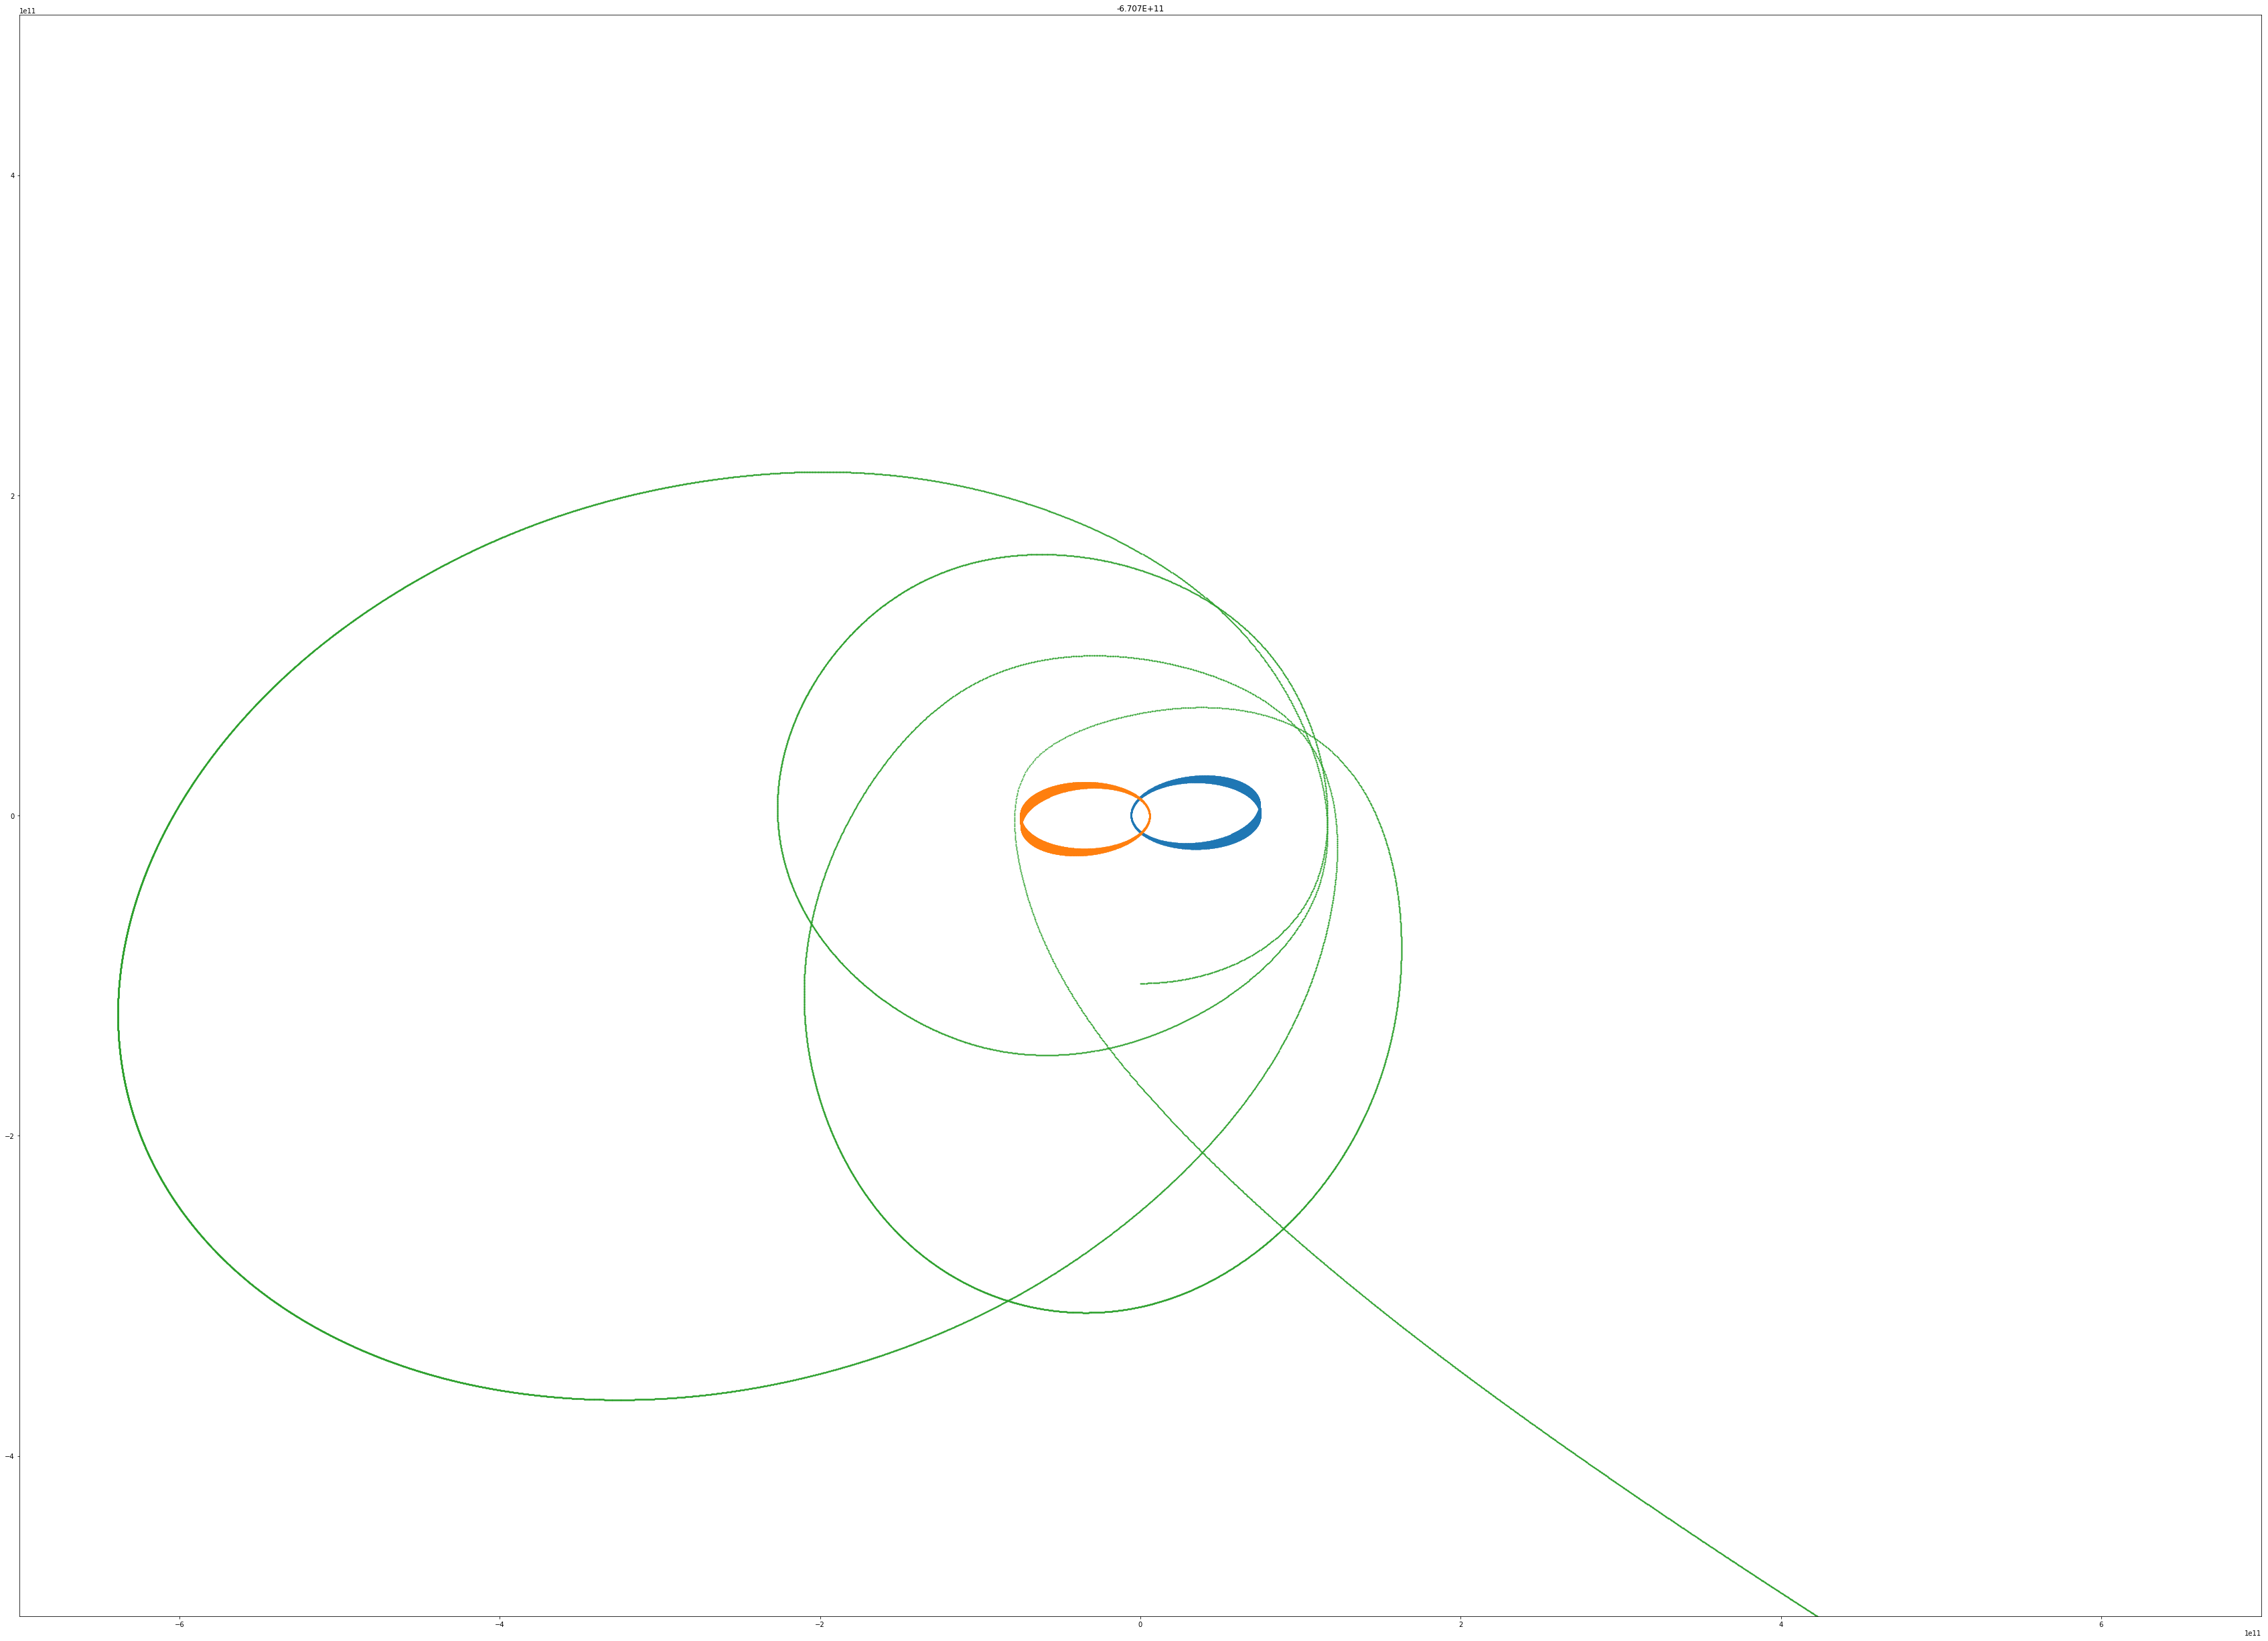

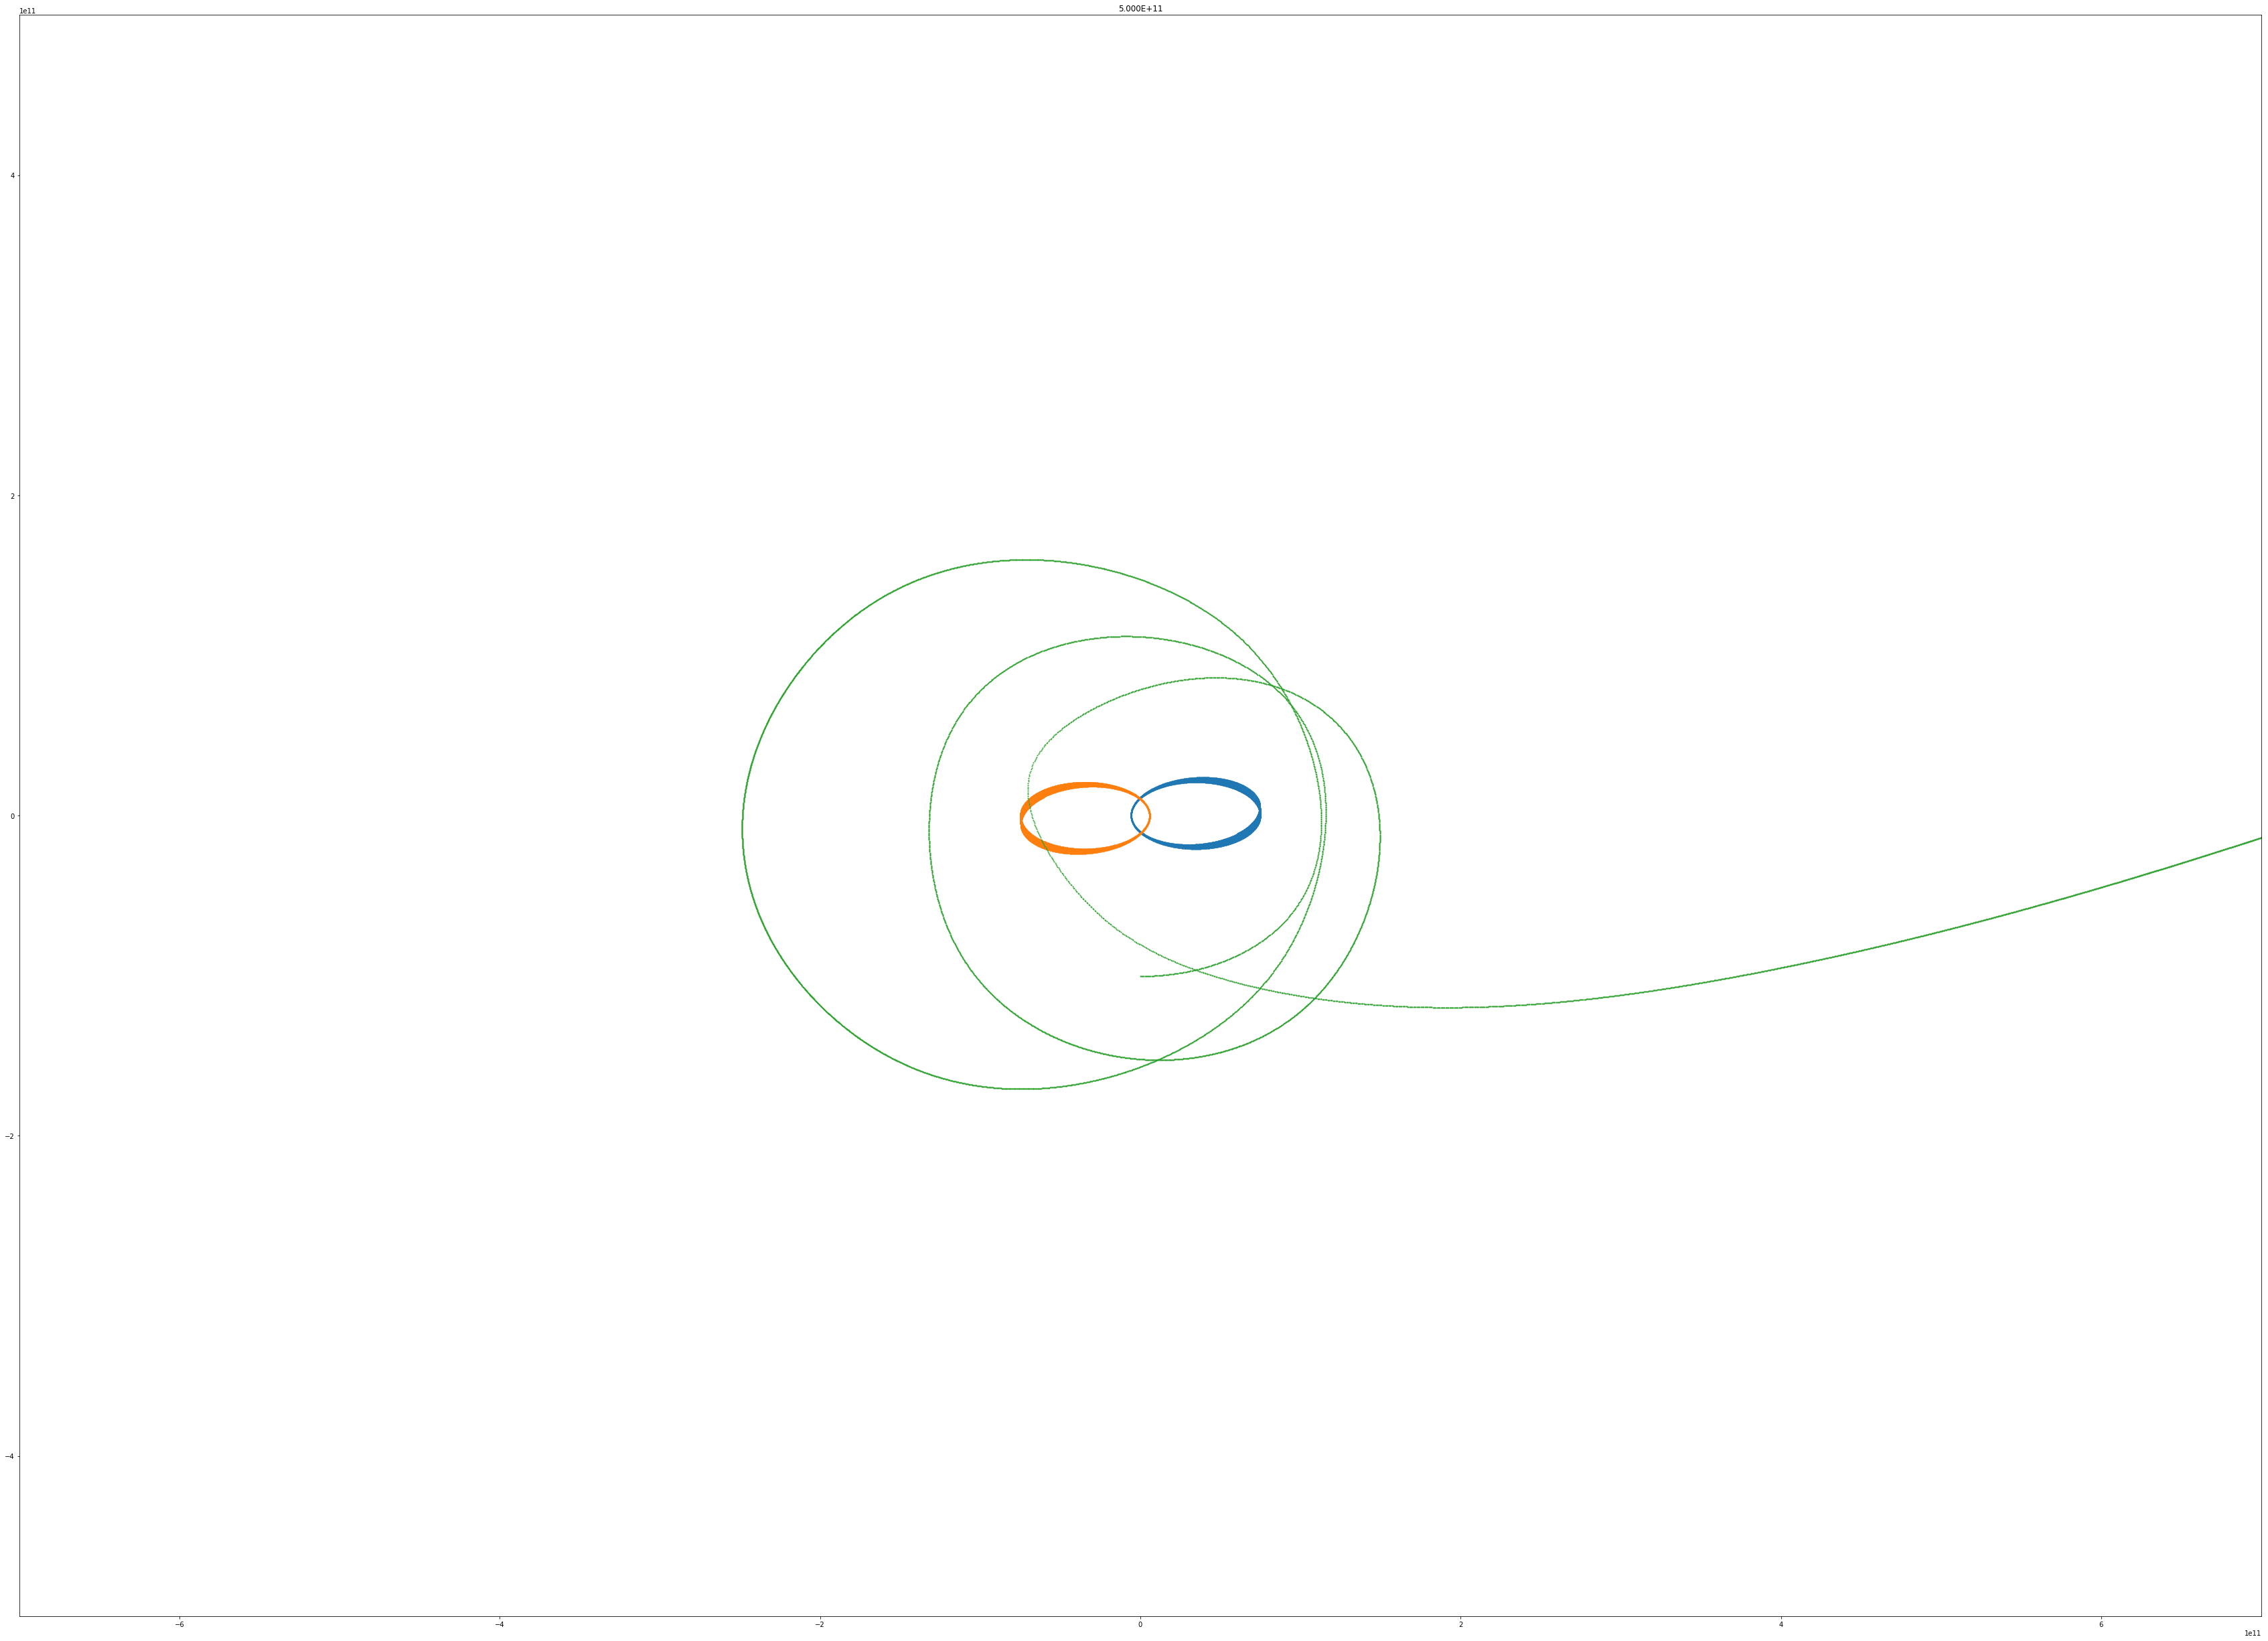

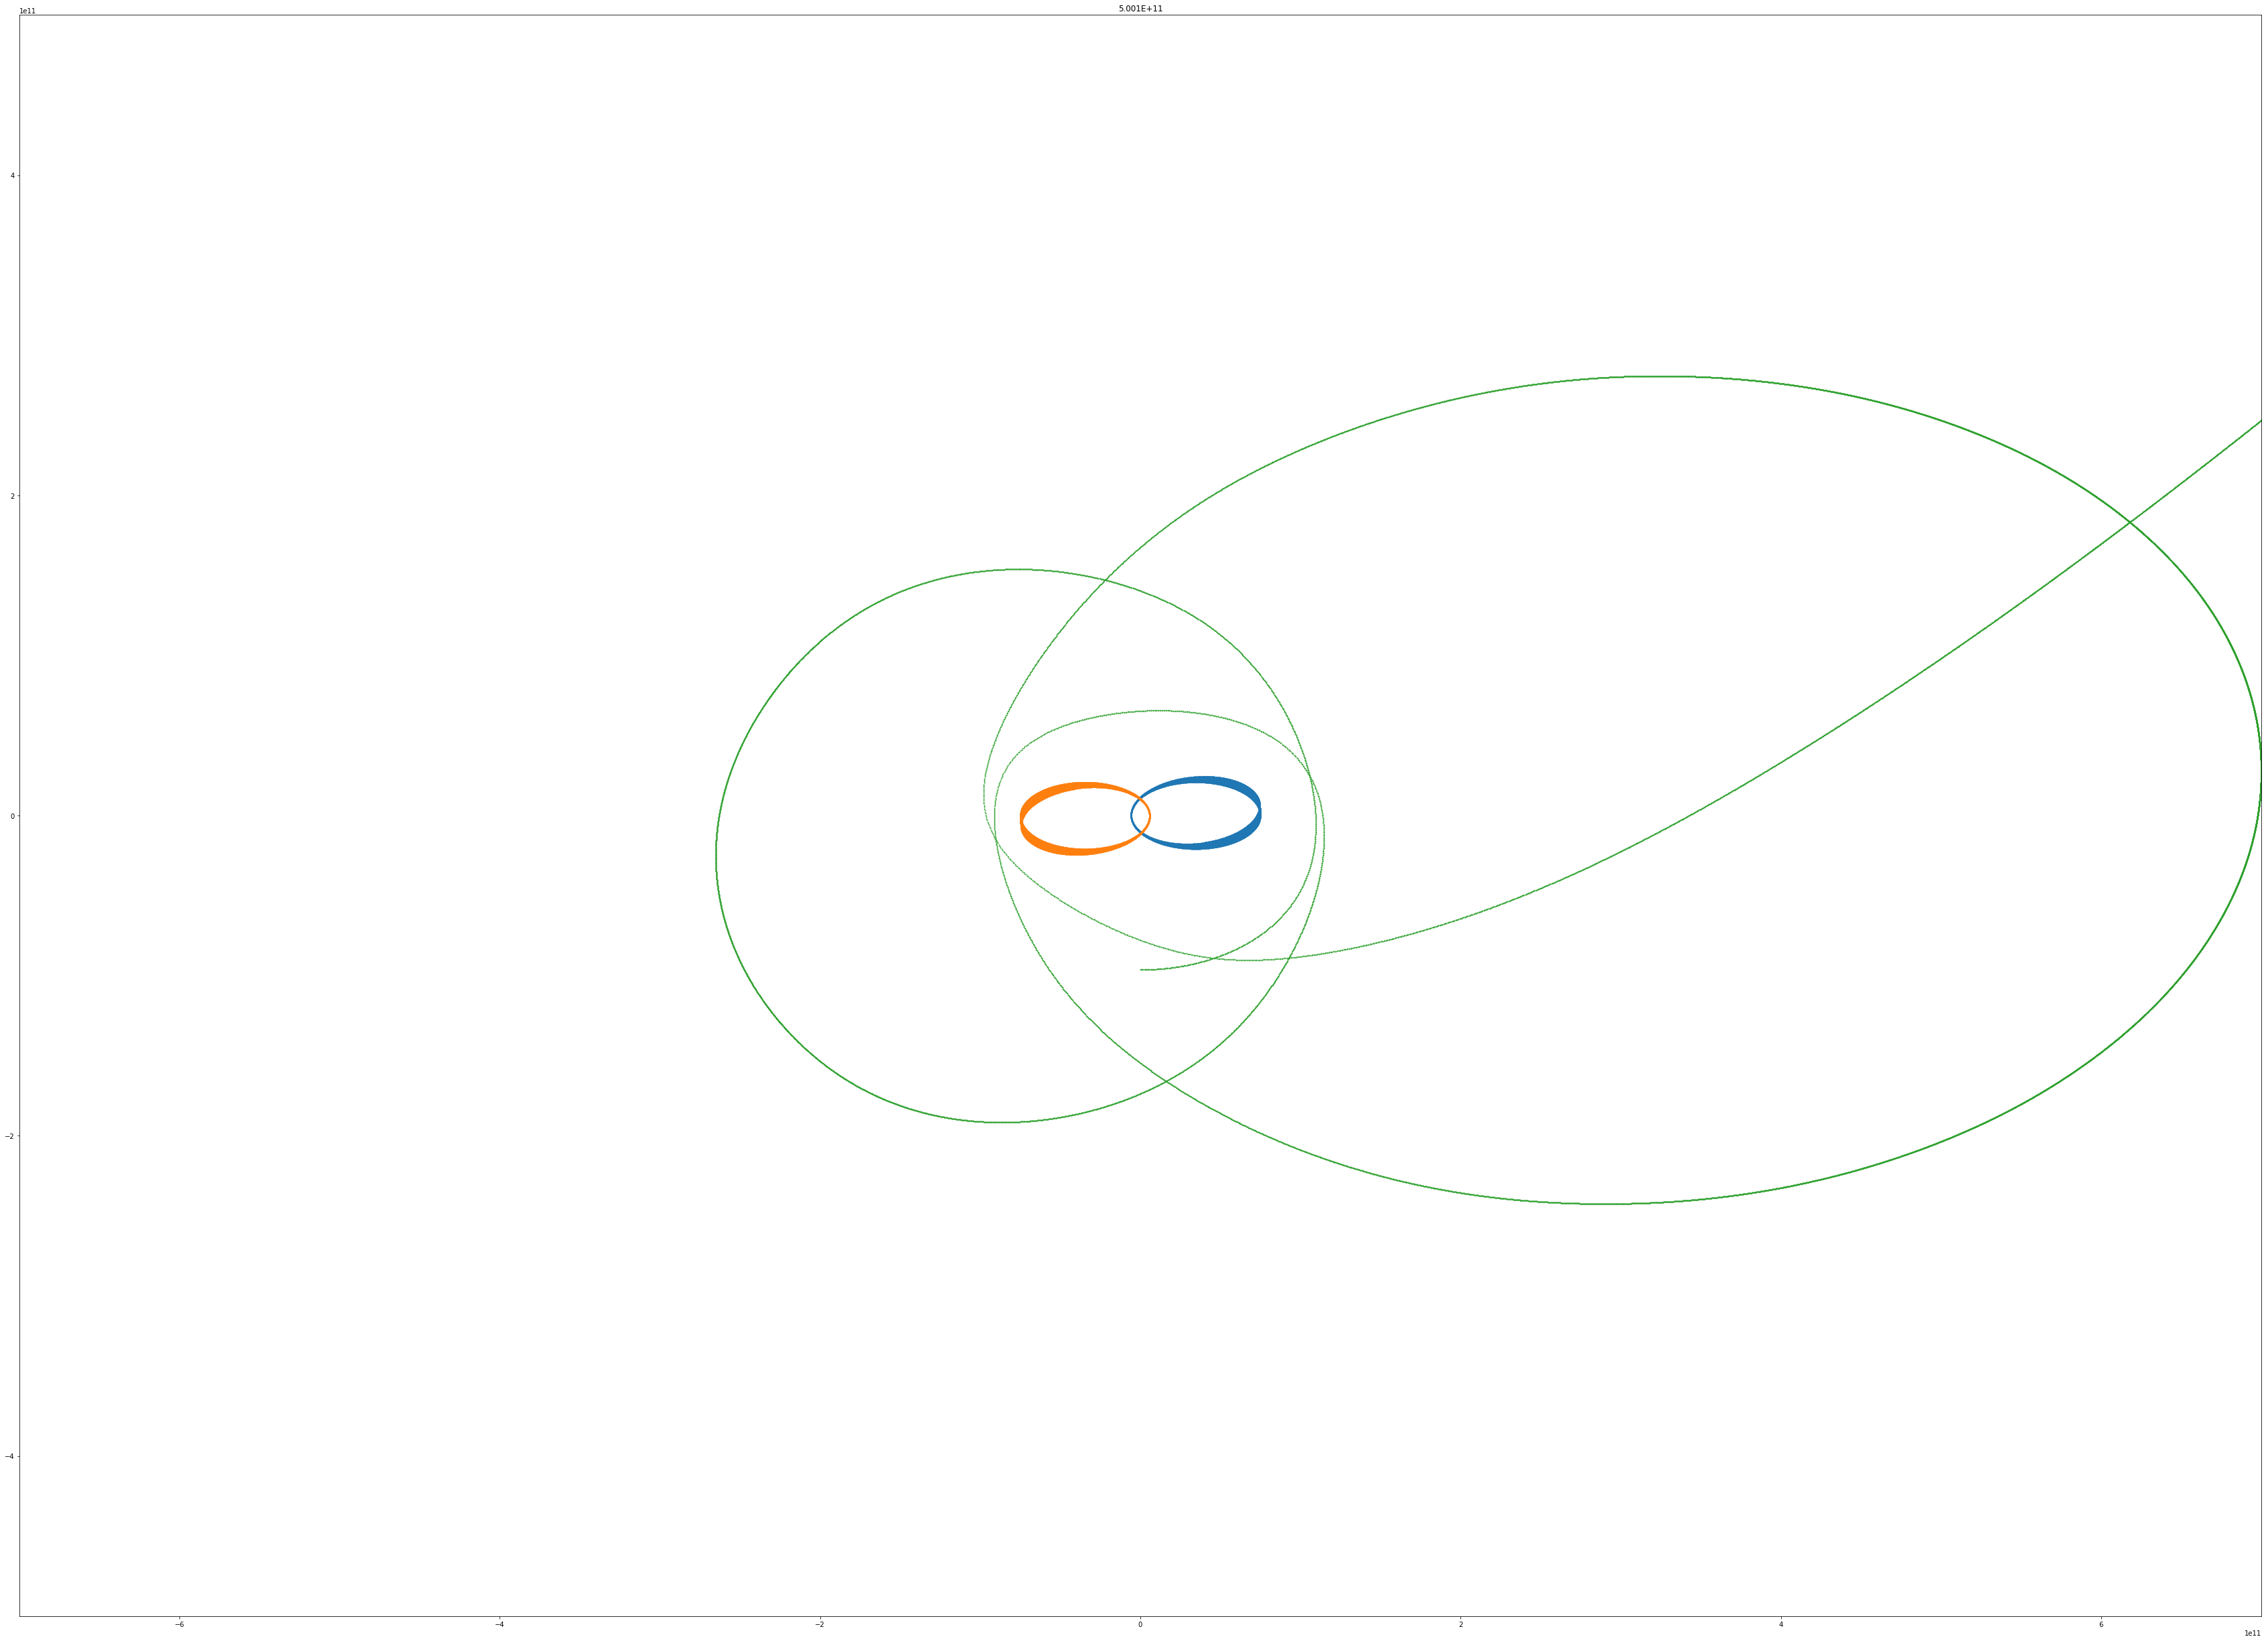

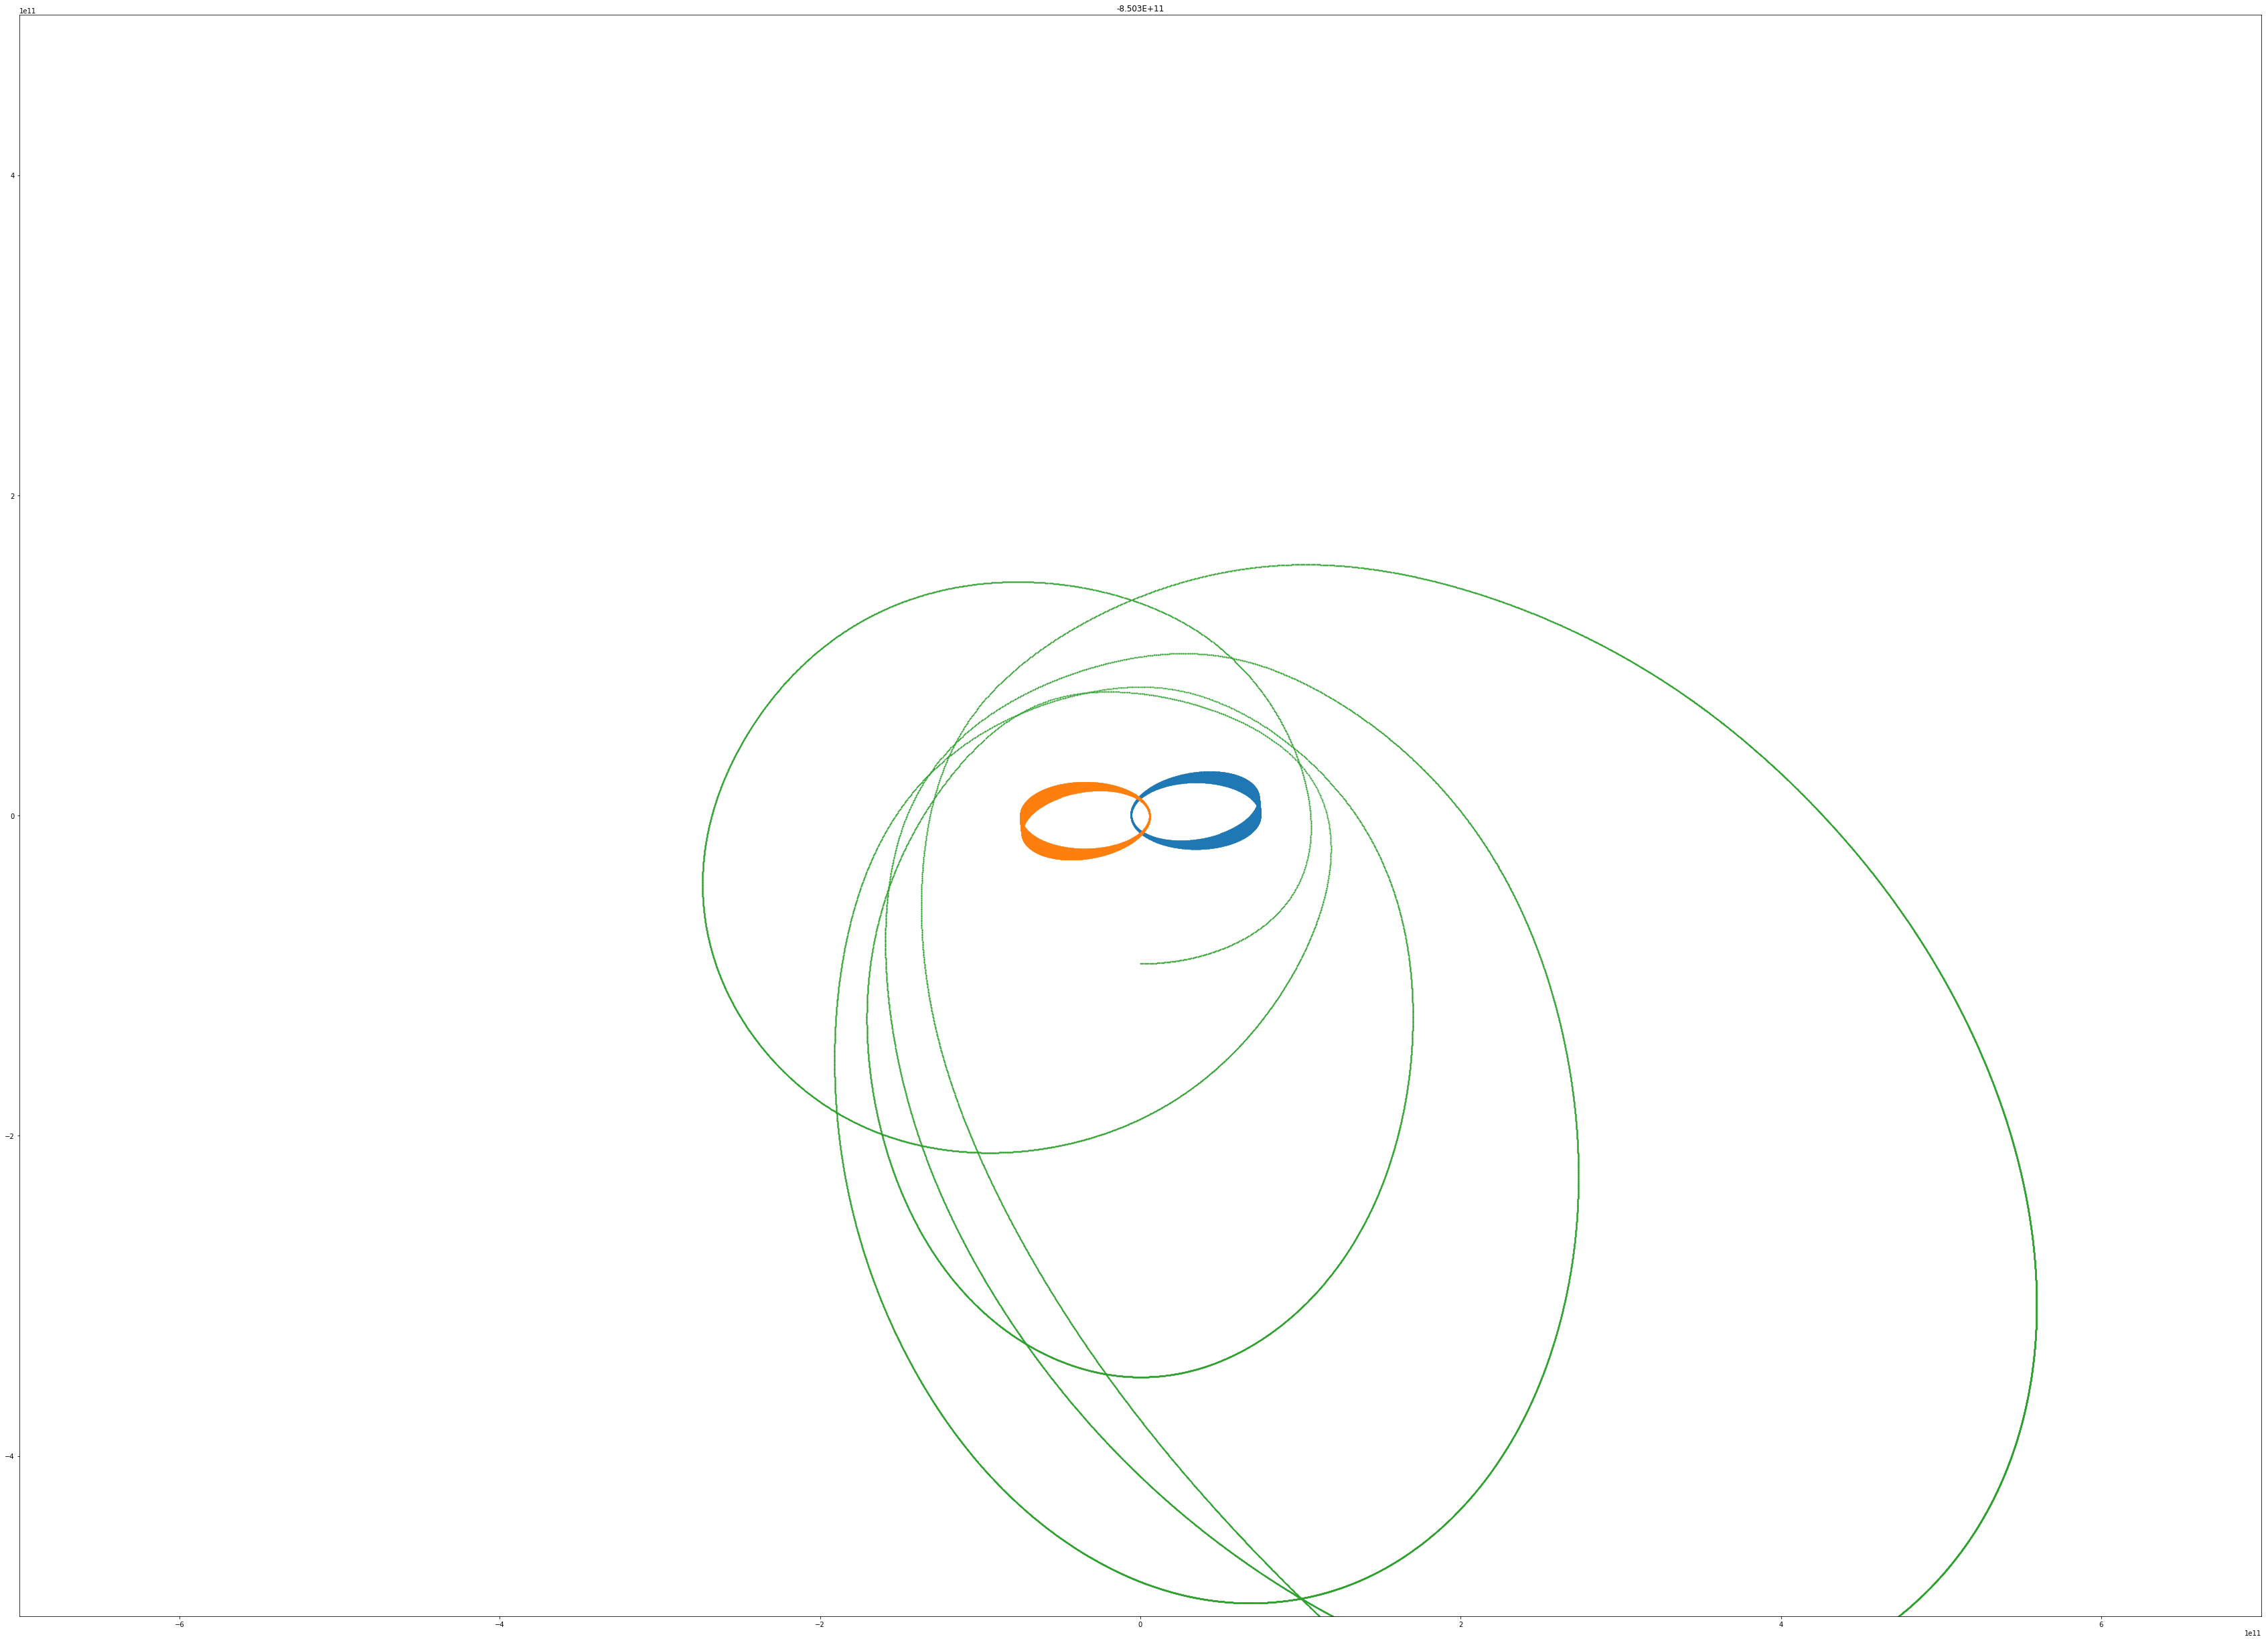

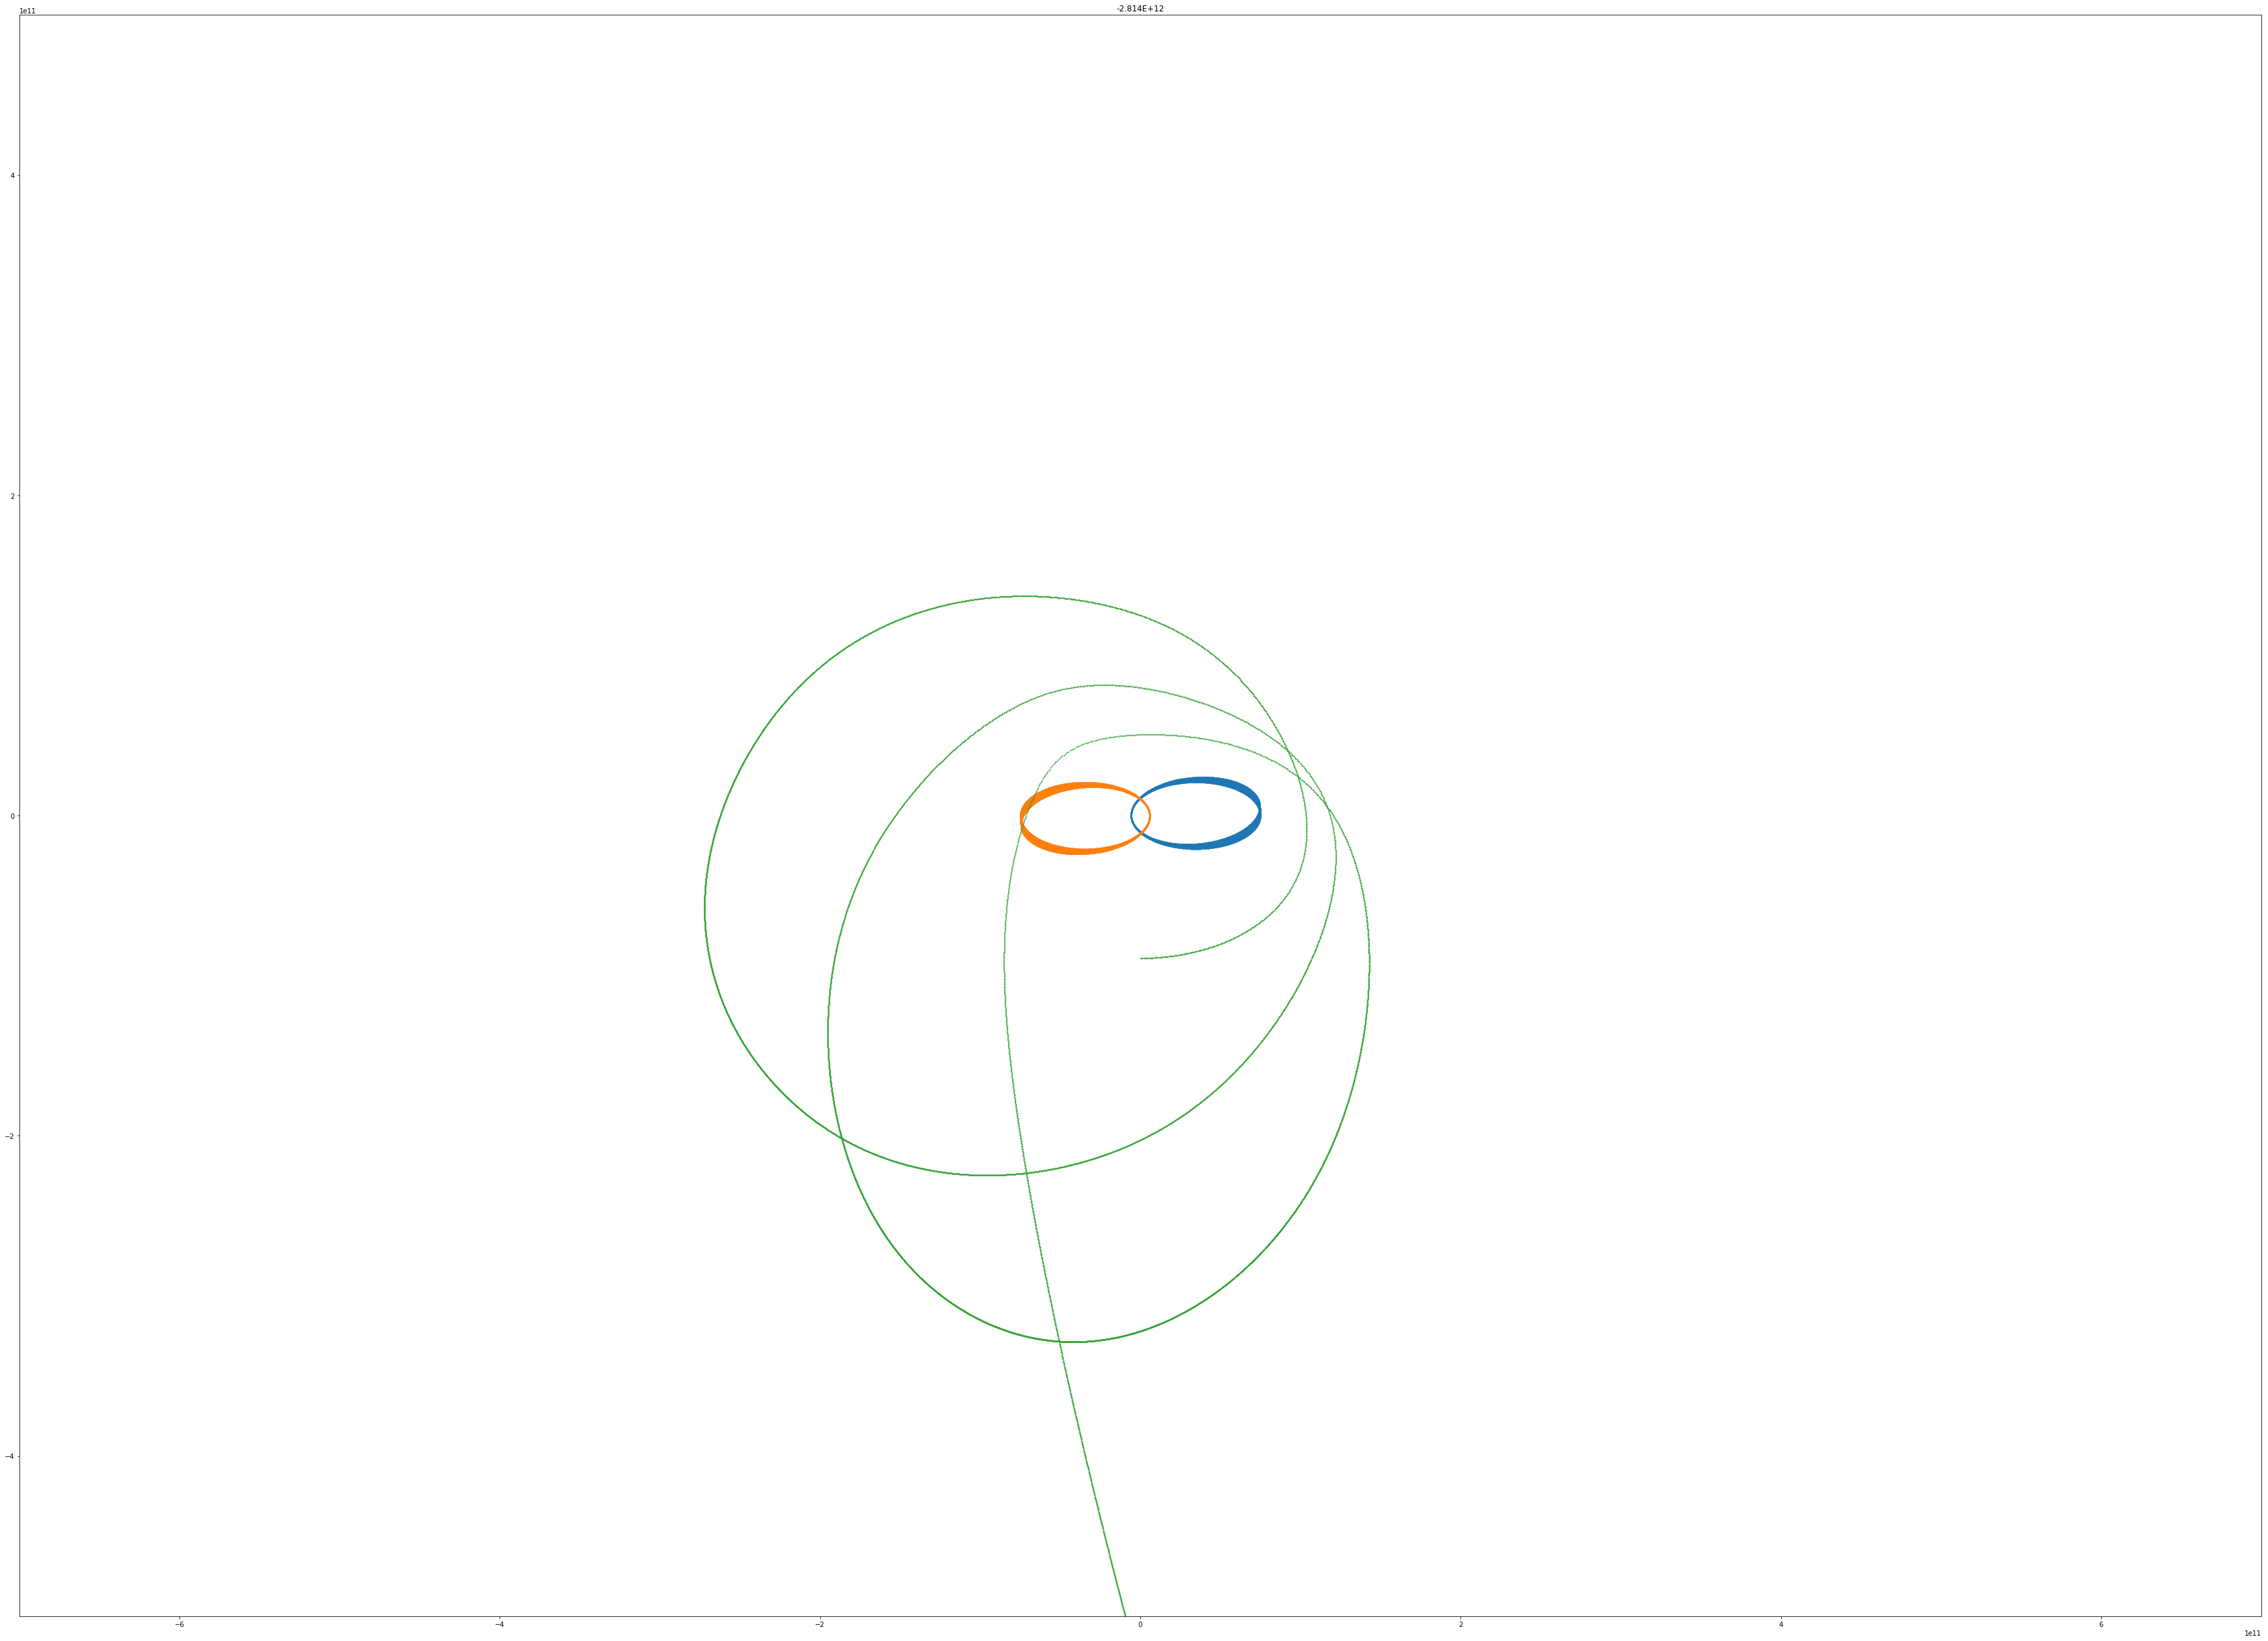

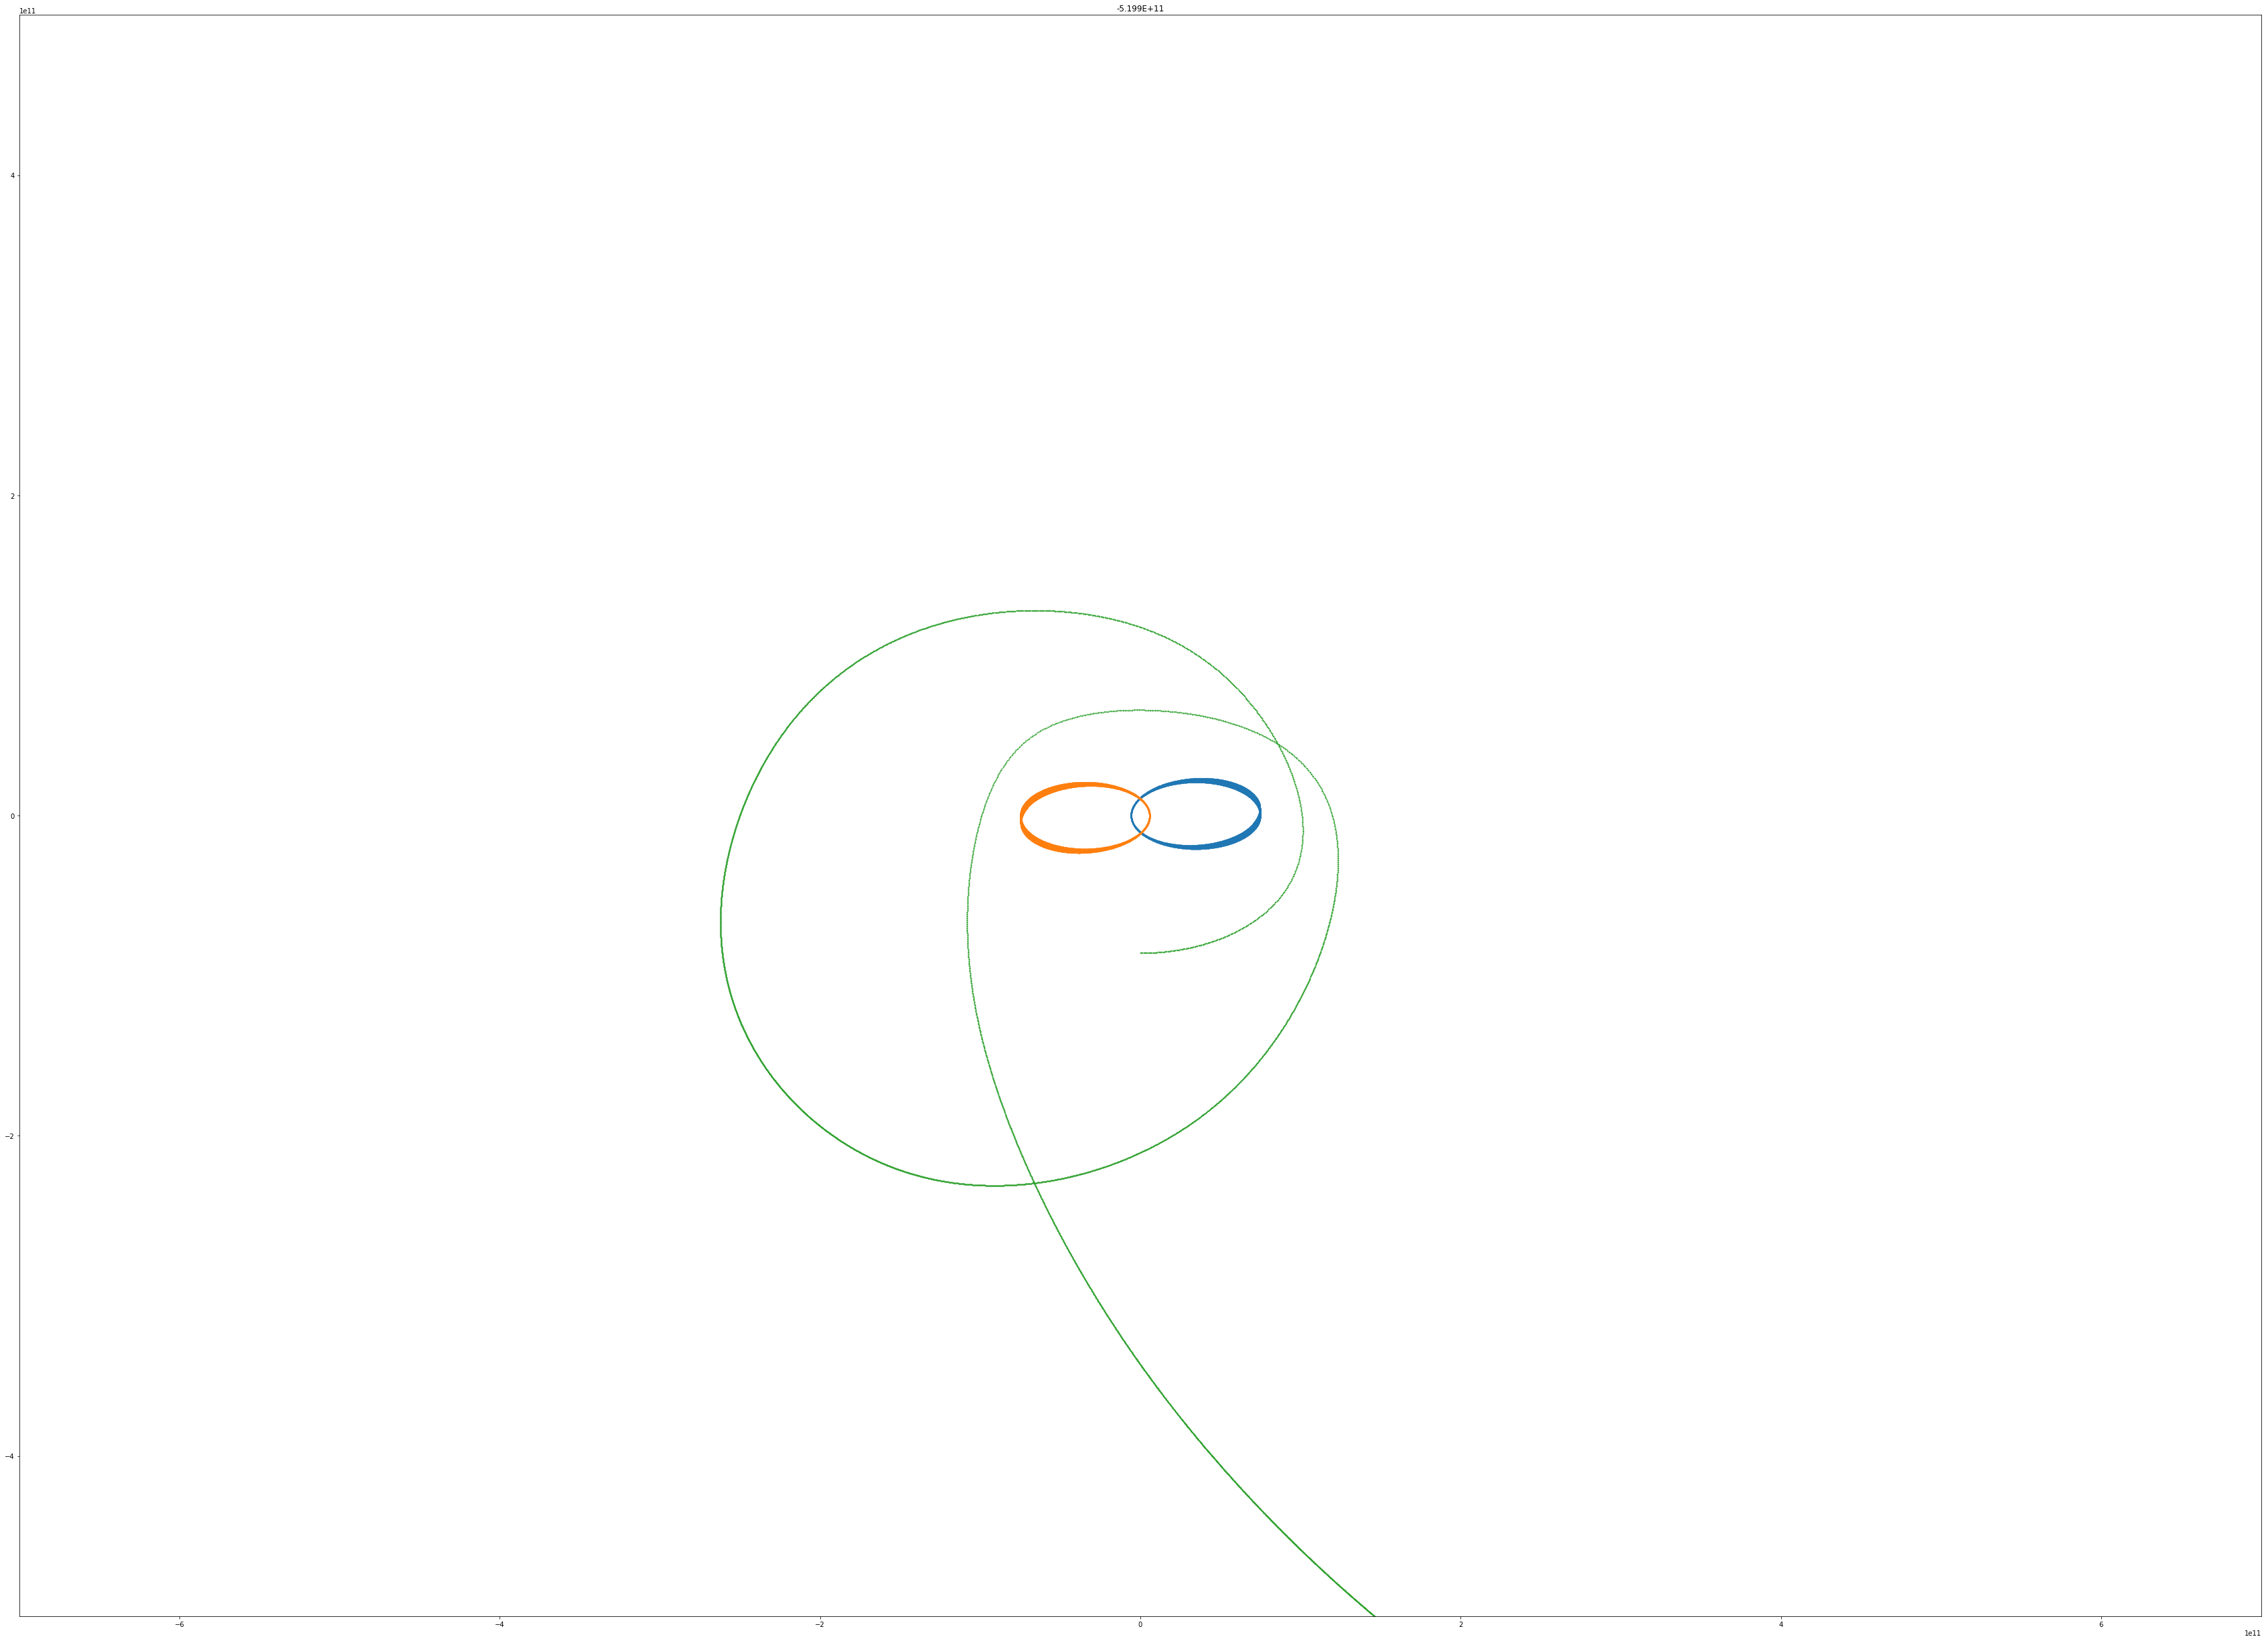

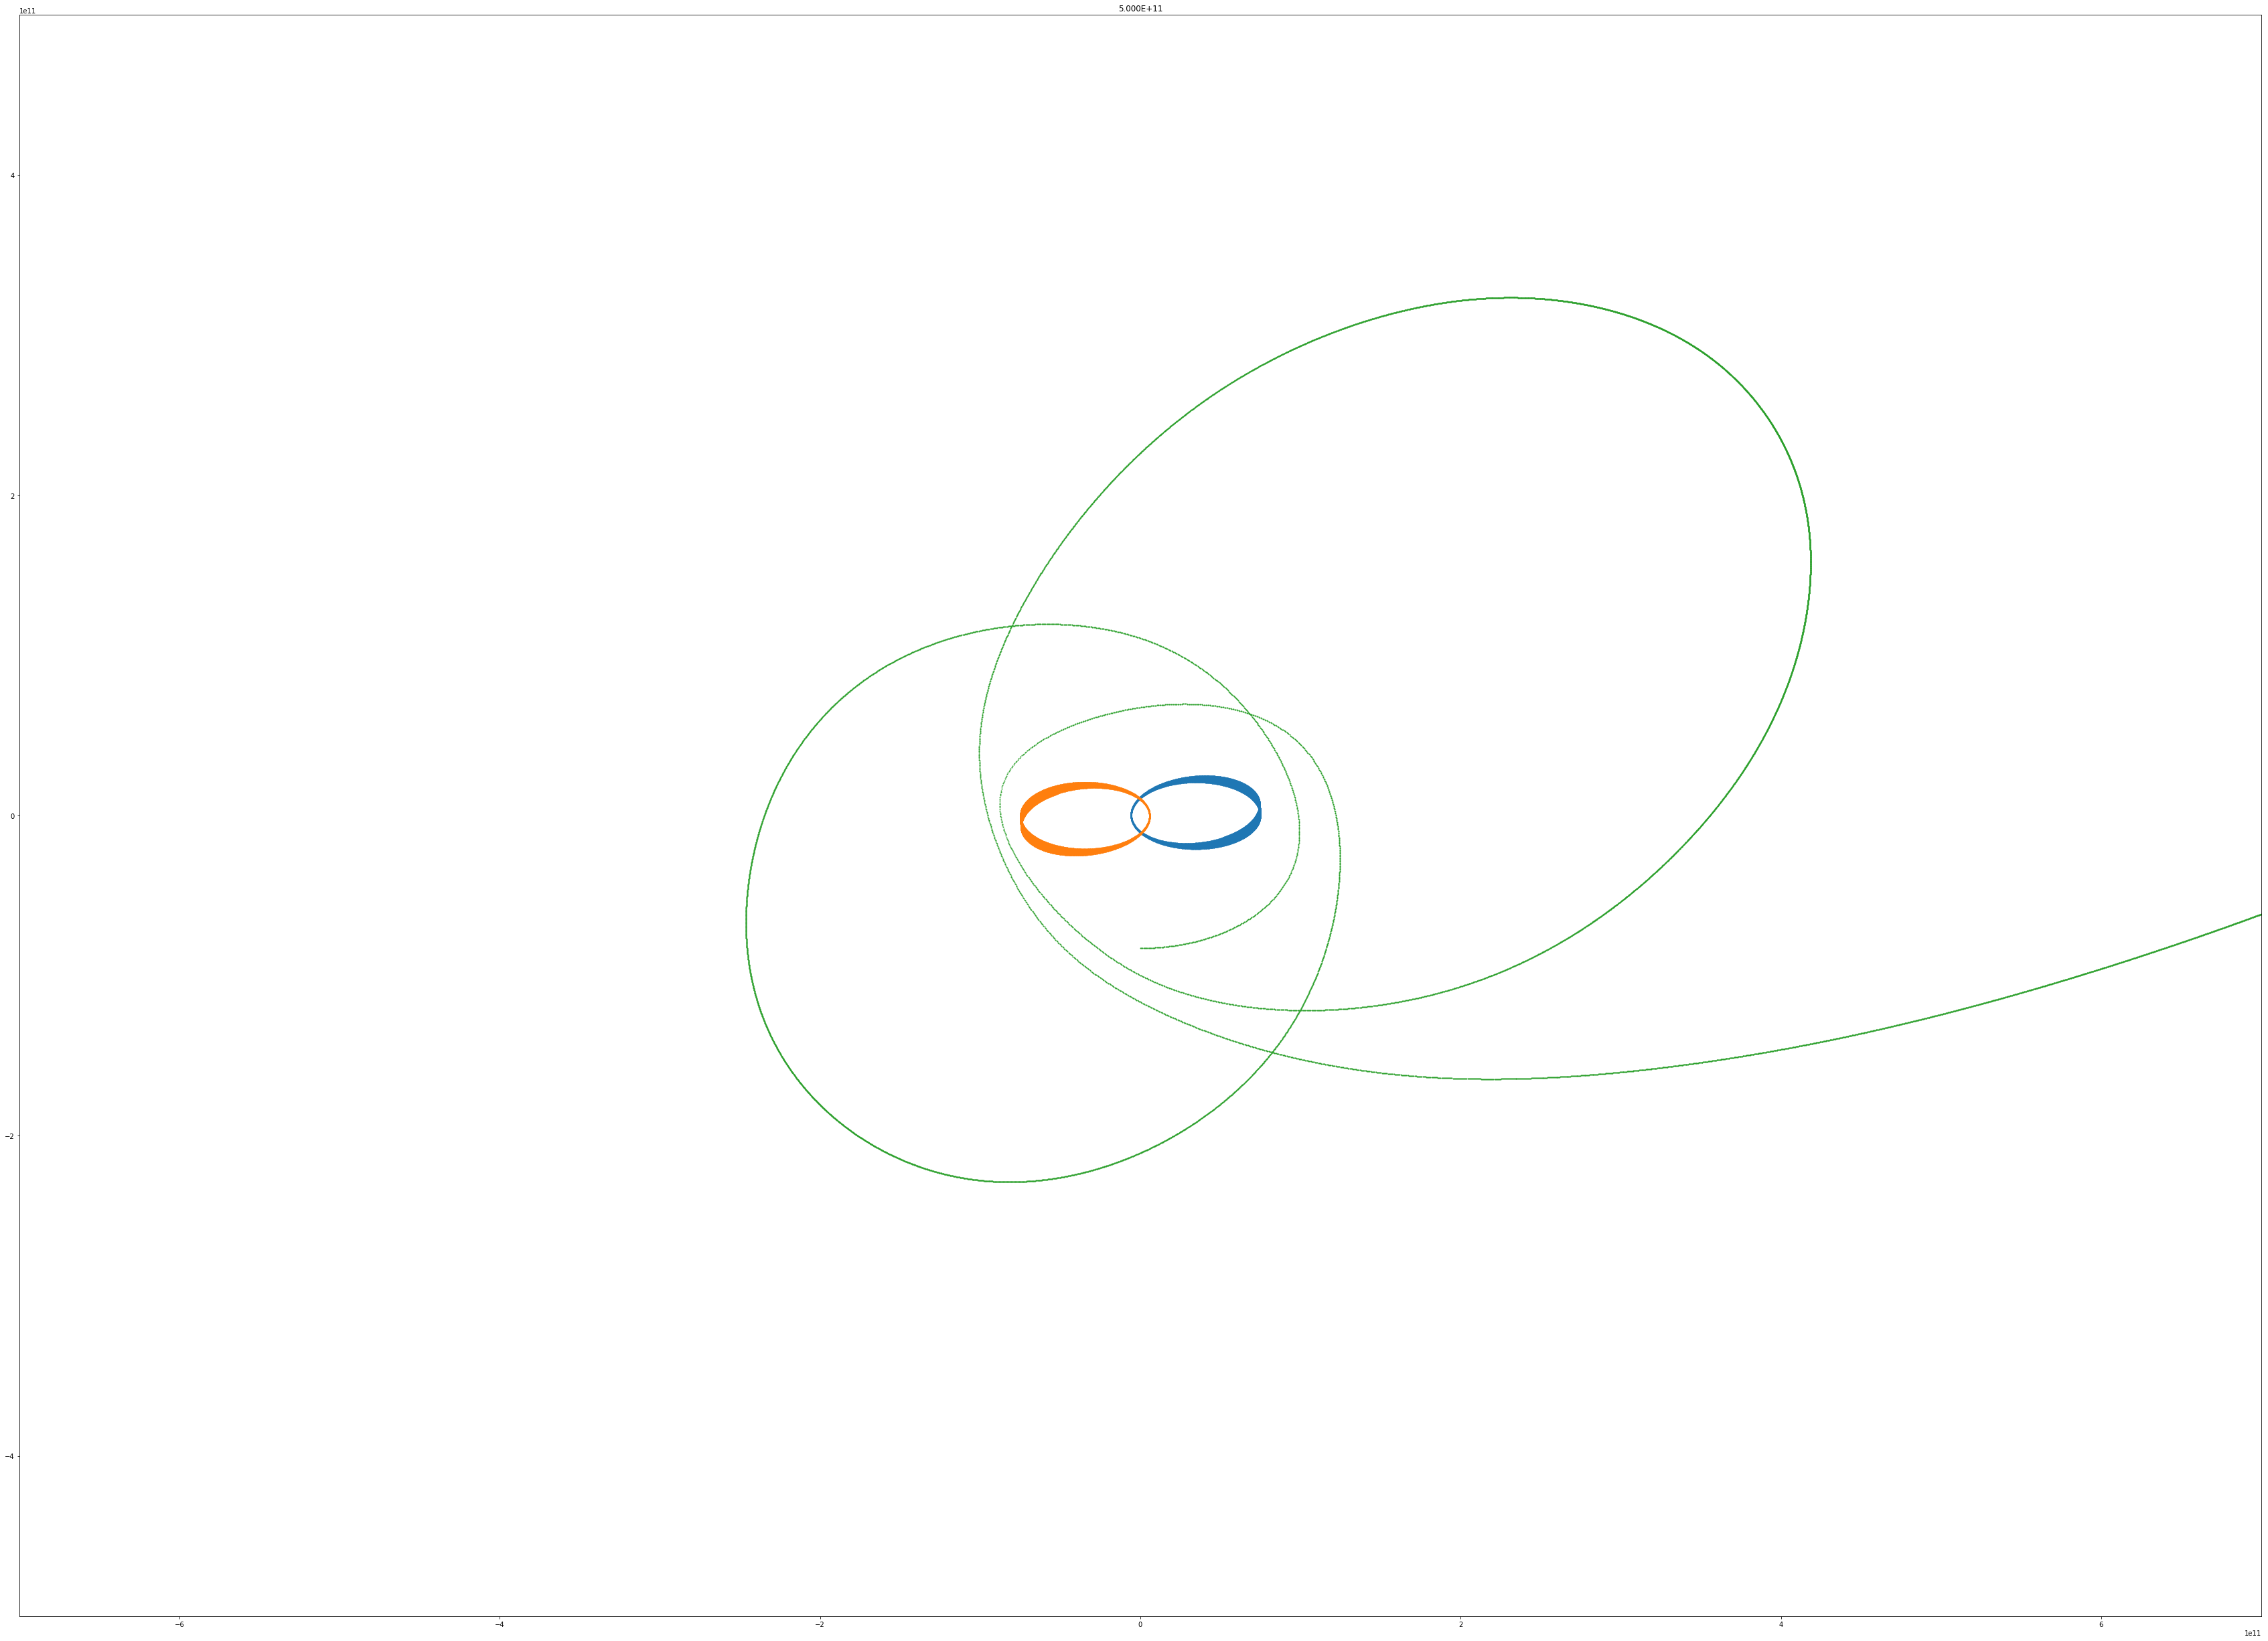

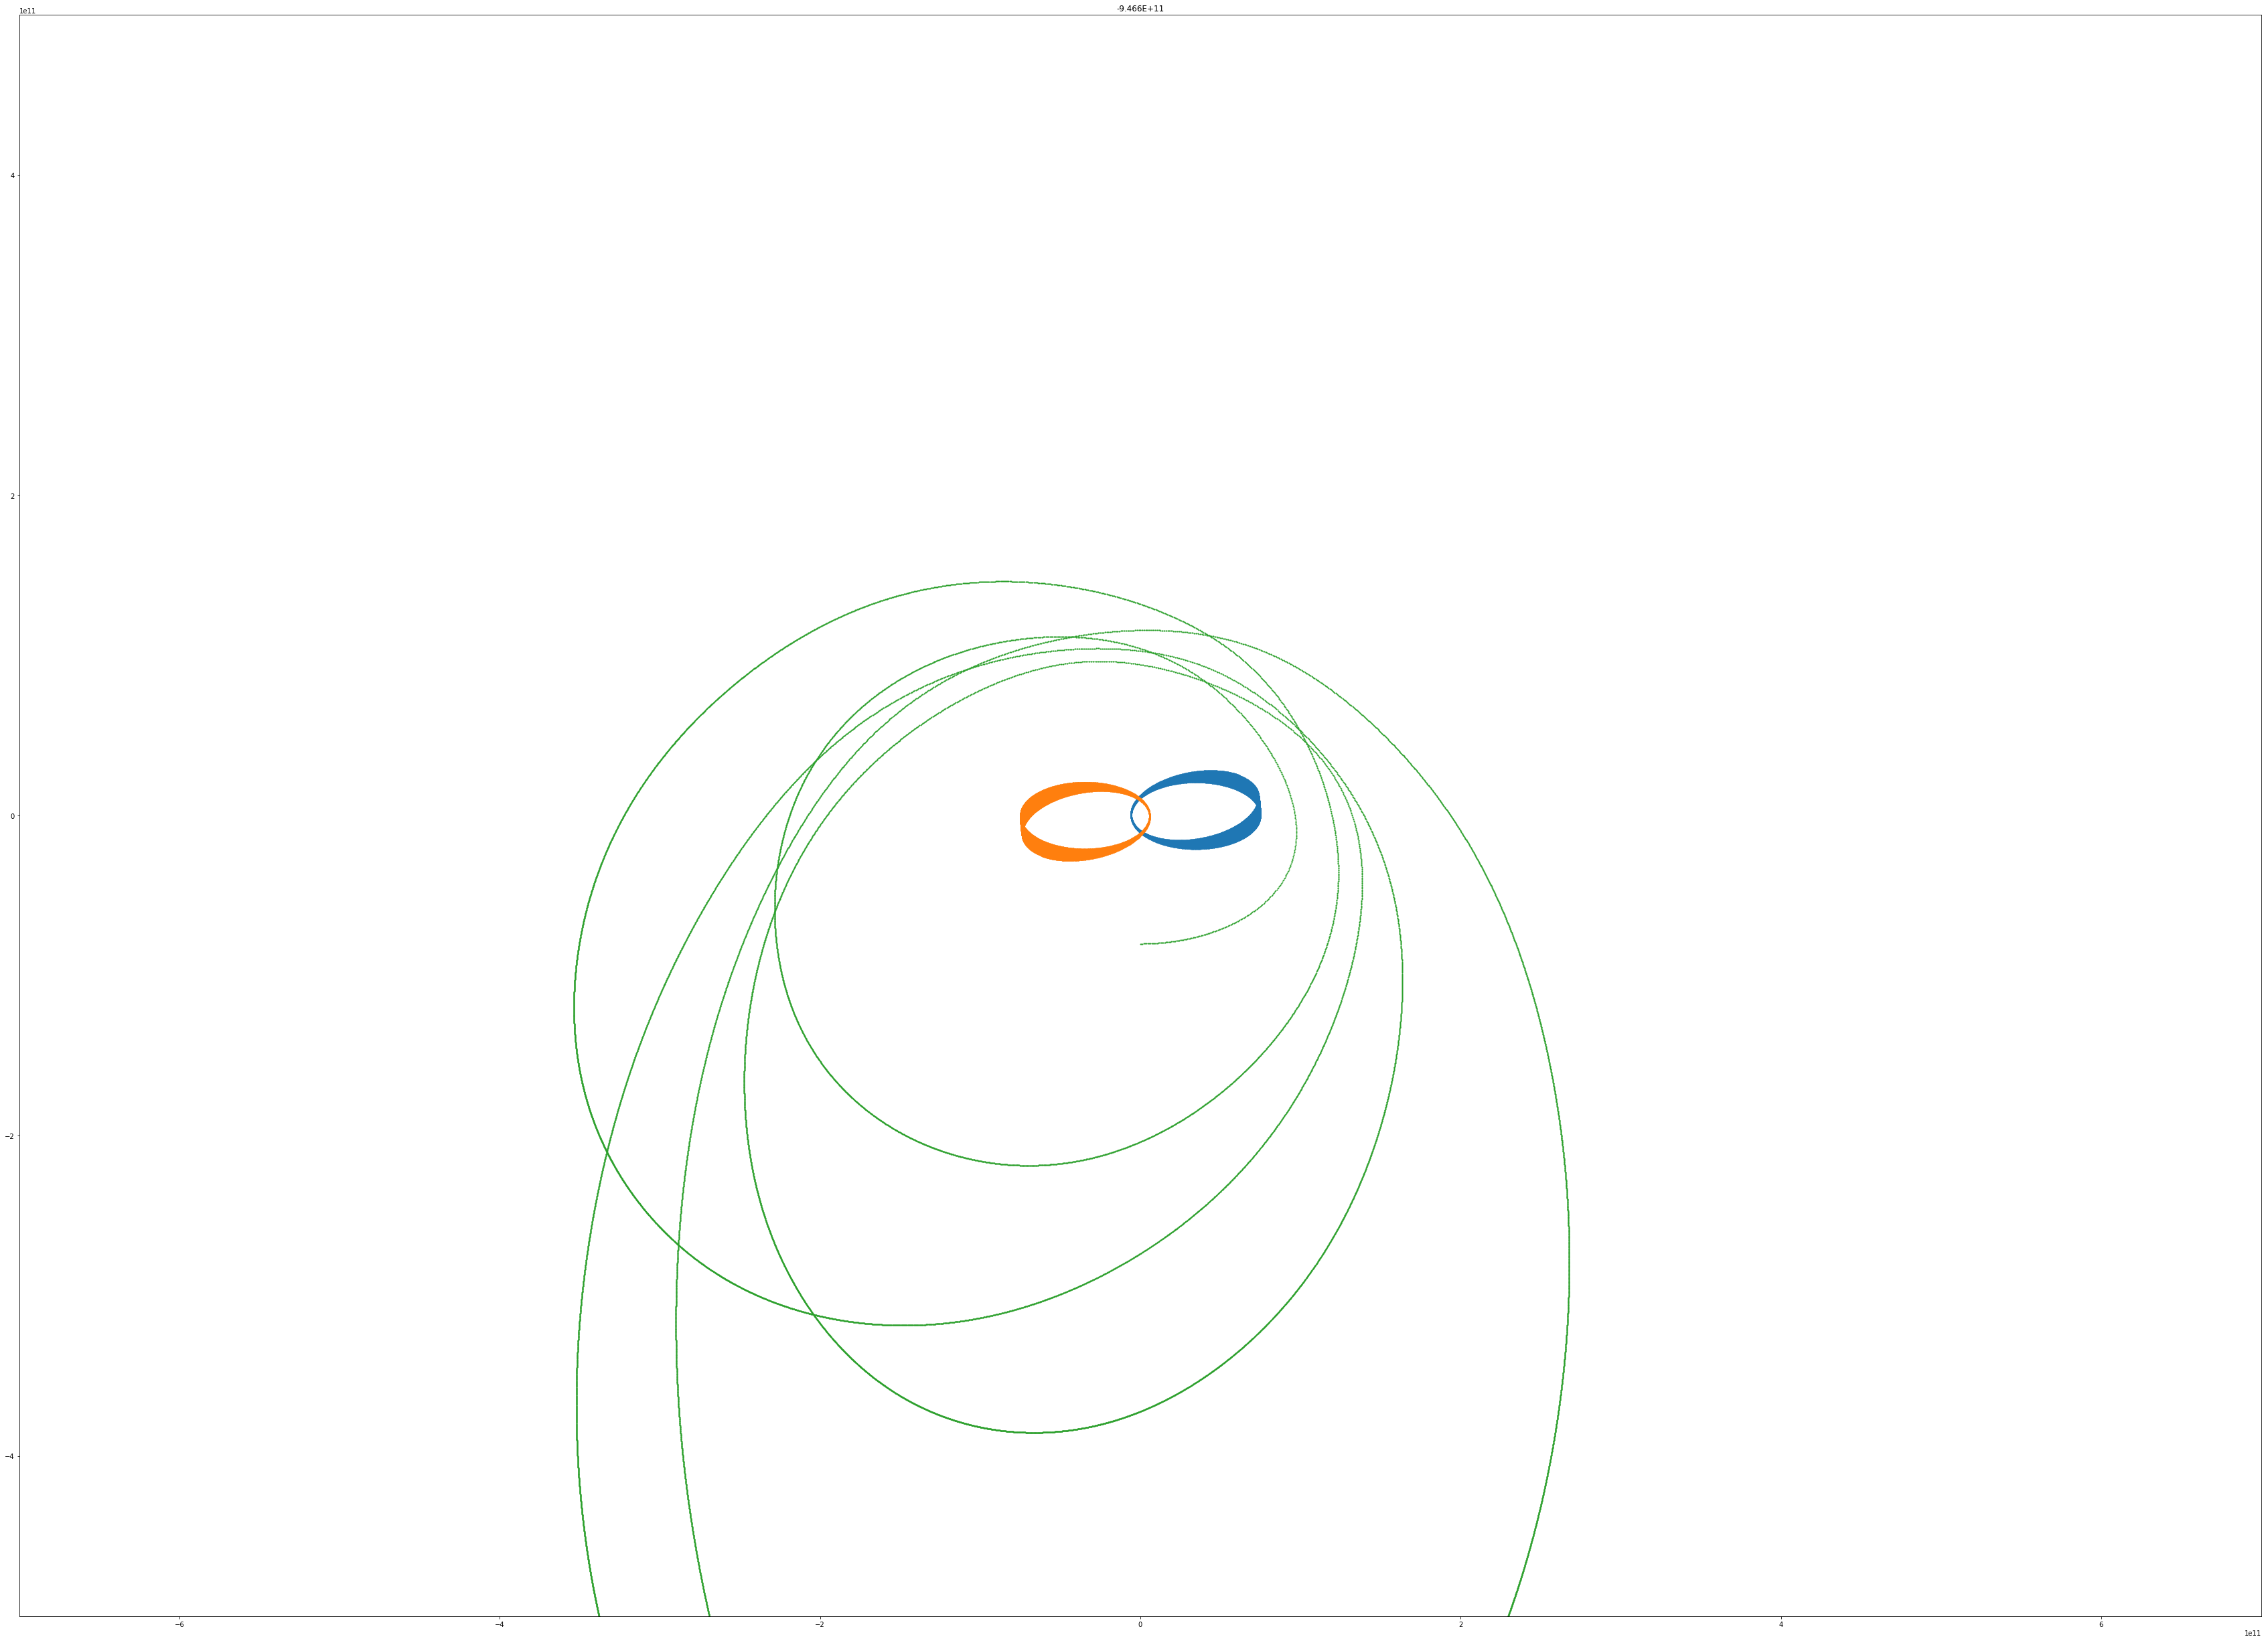

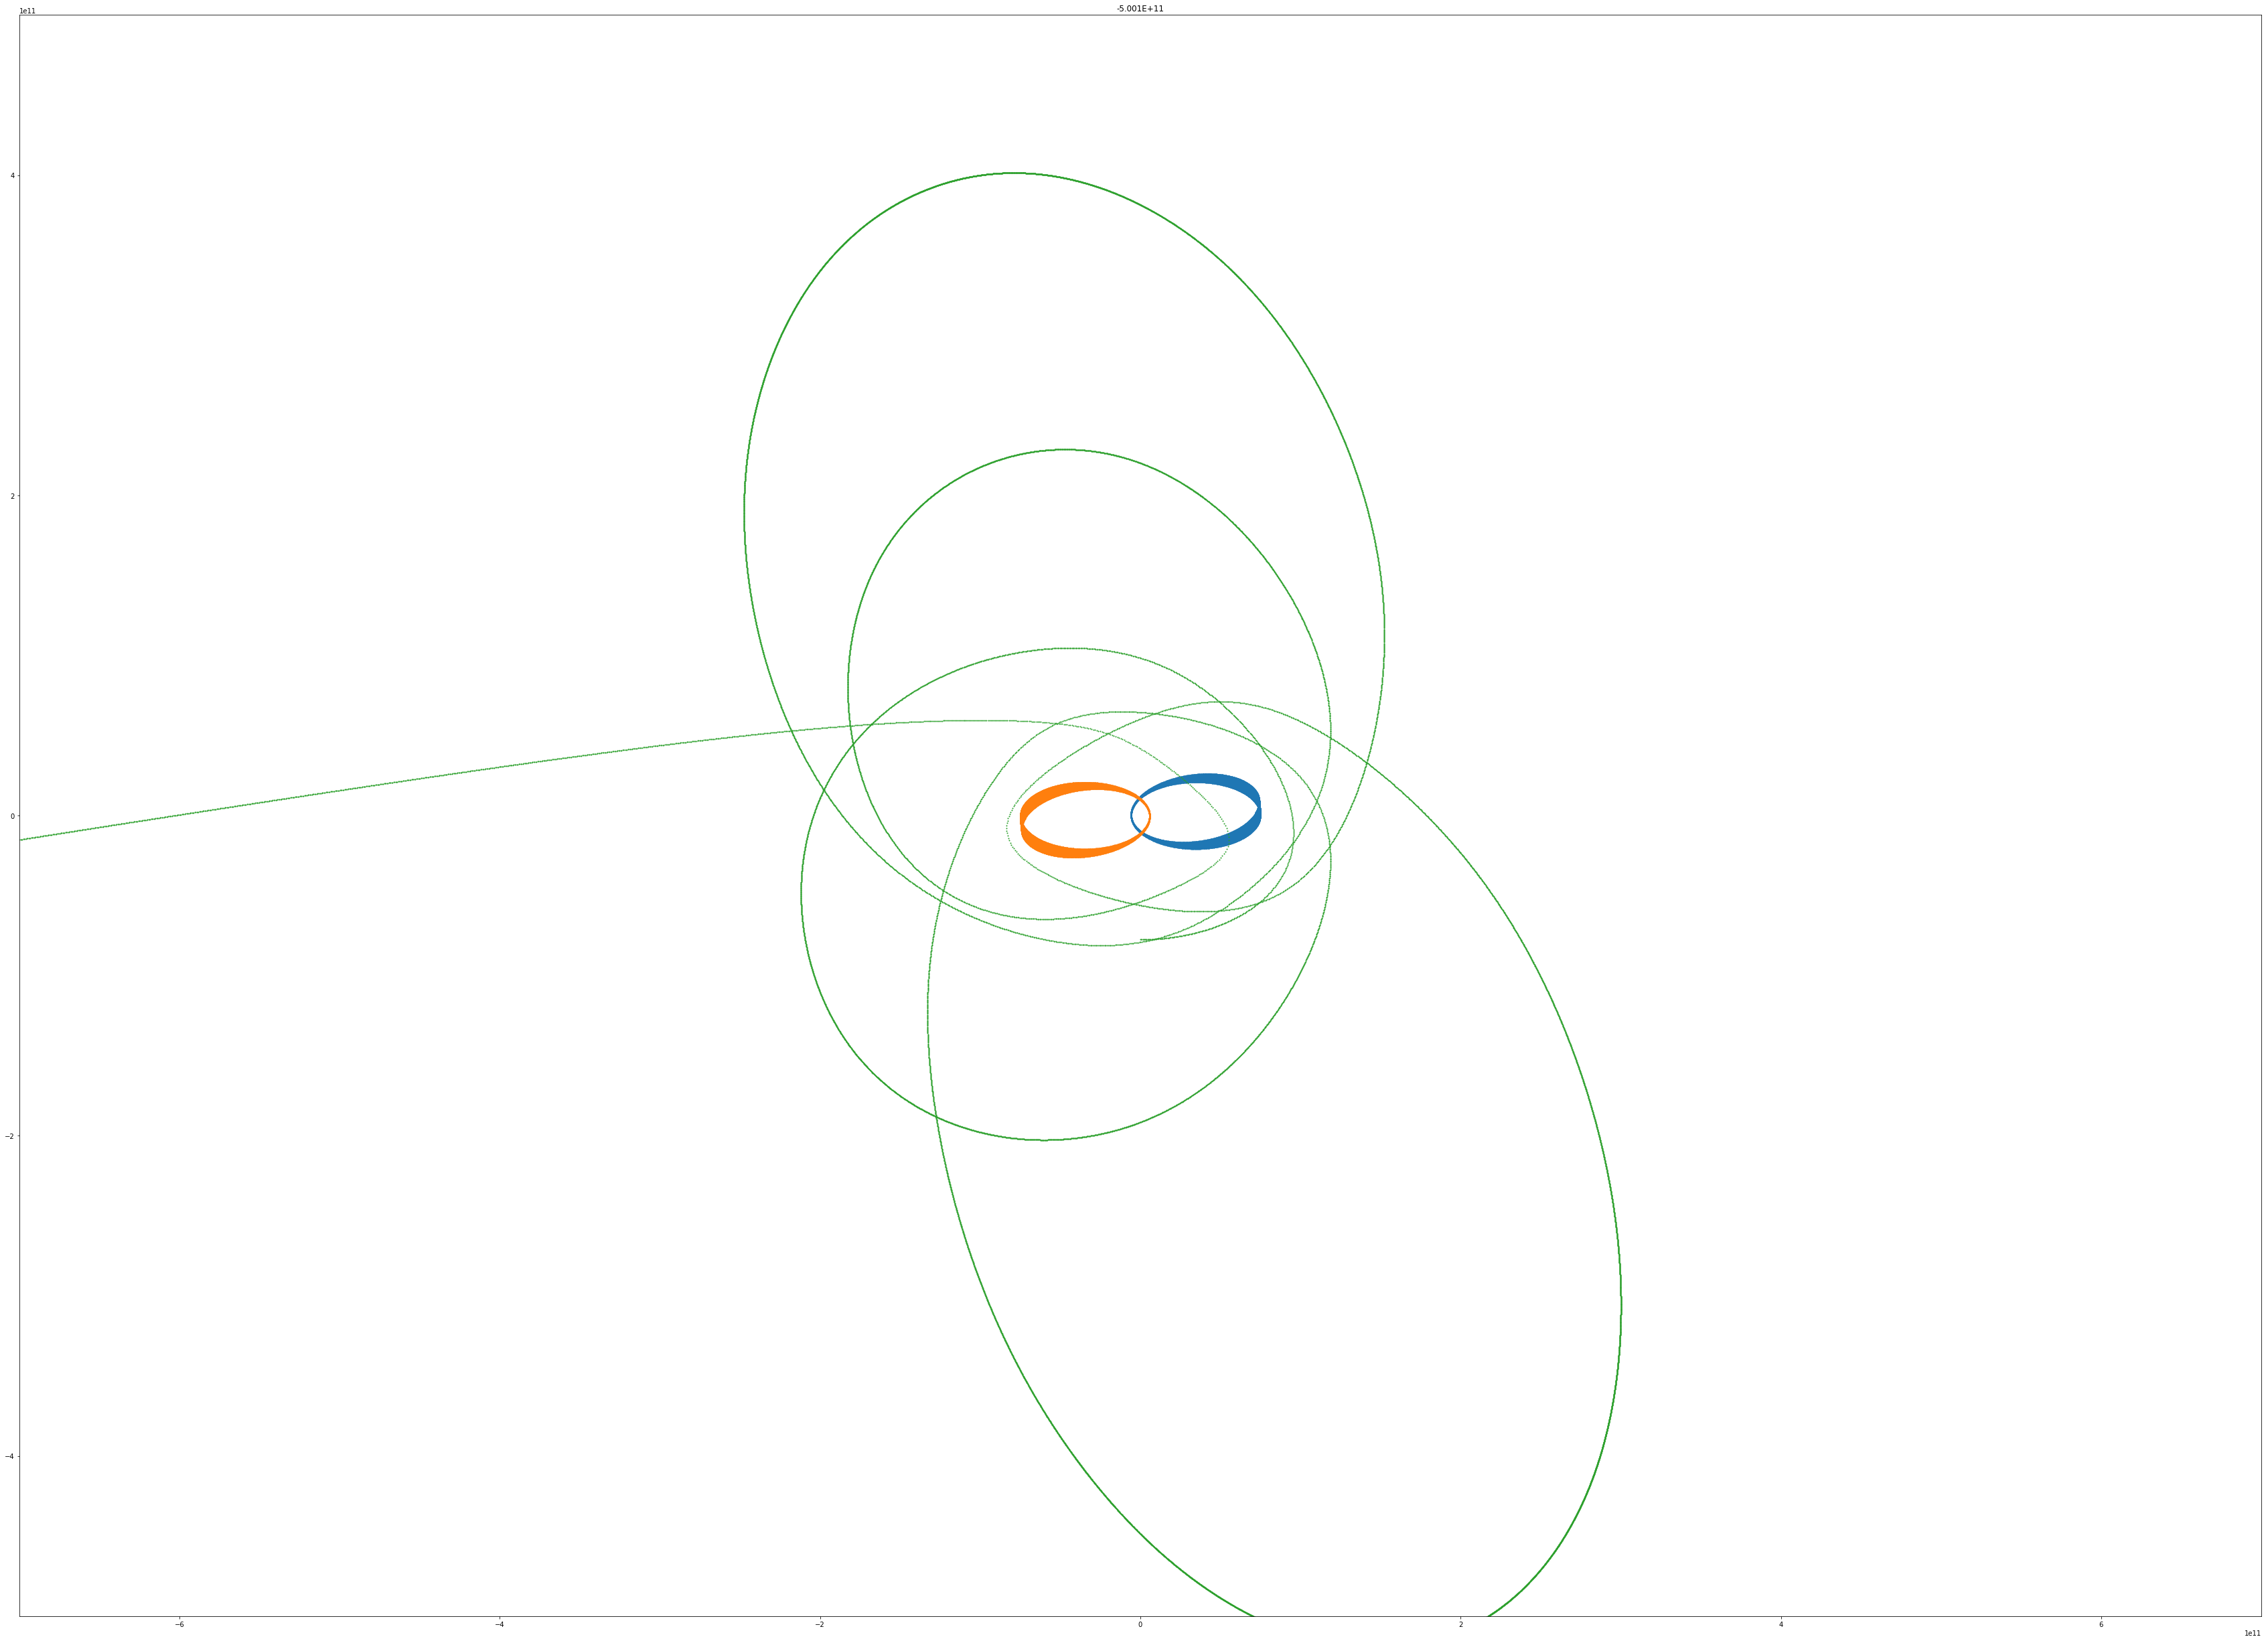

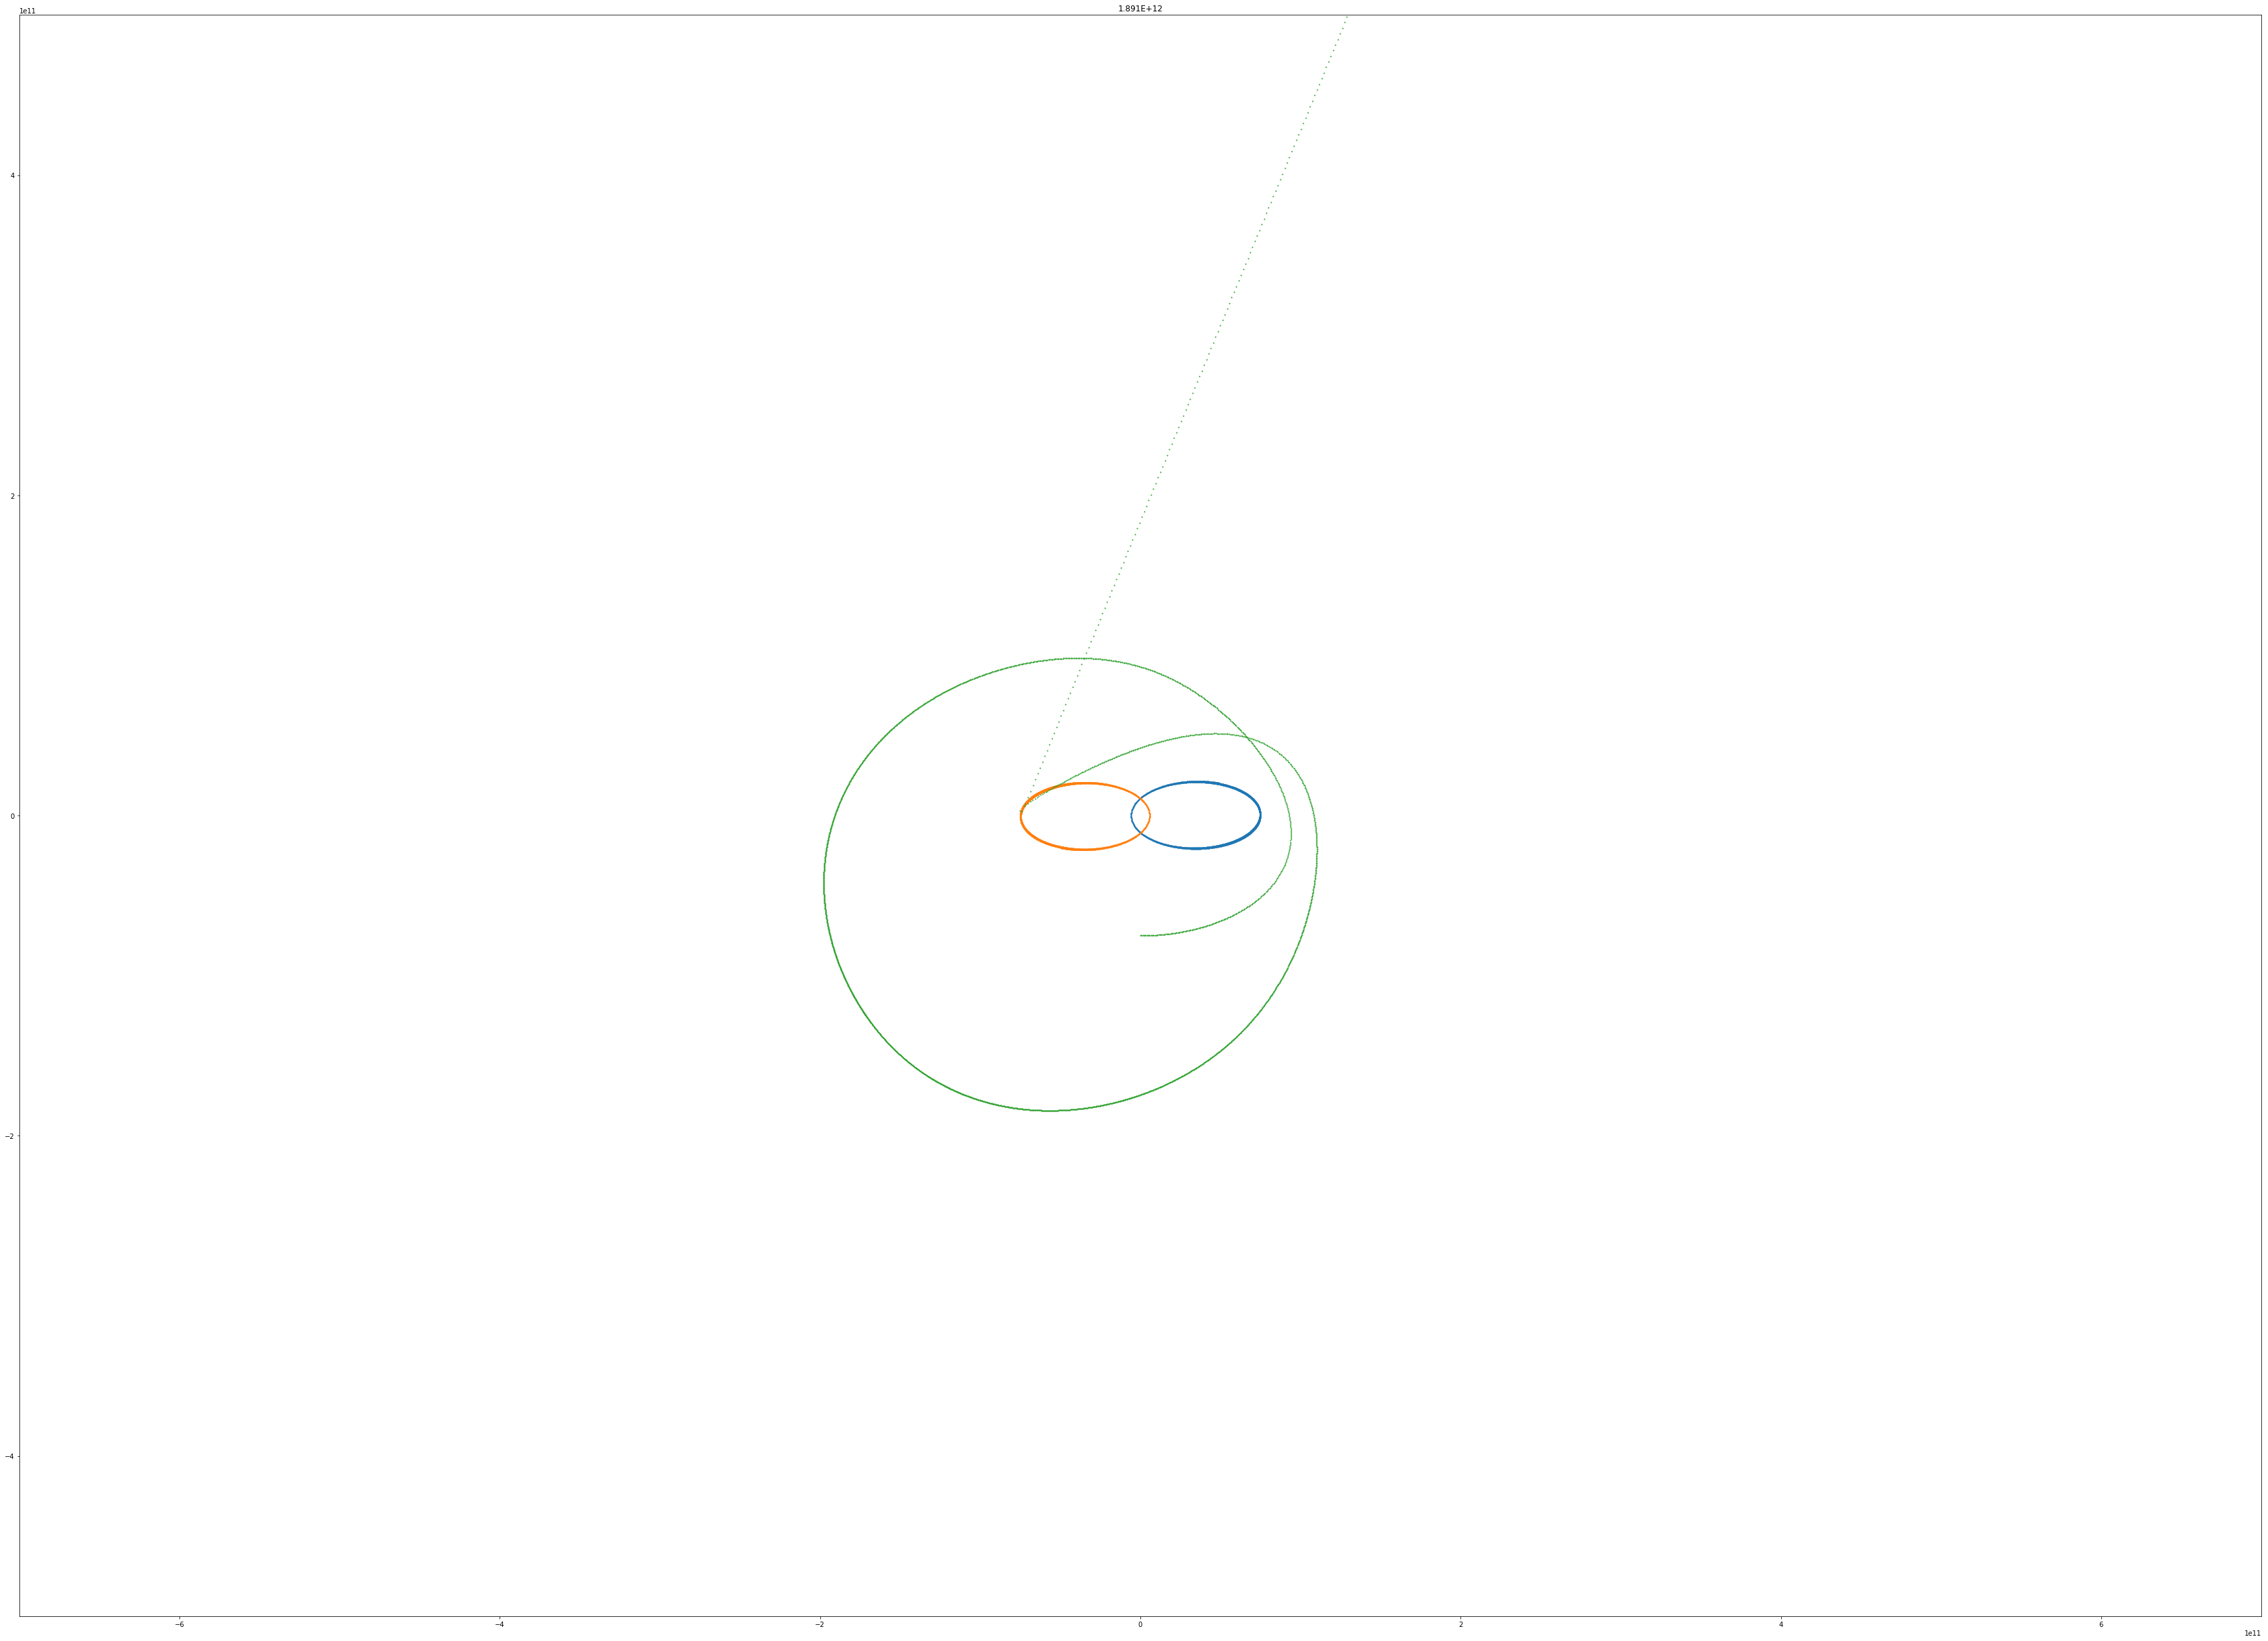

In [25]:
xbound = 0.7e12
ybound = 0.5e12

for i in np.linspace(4,10,20):

    #RESET INITIAL CONDITIONS
    initialVstar = -8e3
    initialVdark = -initialVstar #initial velocity of dark object in m/s
    #initialVplan = -0.45e5

    #cool ones: 9e3
    # 1e4
    # 2e4 no procession


    starPos = np.array([7.48e10,0,0]) #initial position array for star; x,y,z components
    starR = 7e8 #radius in meters
    starM = 2e30 #mass of sun in kg

    darkPos = np.array([-7.48e10,0,0]) #initial position array for dark object; x,y,z components
    darkR = 7e8 #radius of dark obect in meters
    darkM = 2e30 #mass of dark object in kg

    planPos = np.array([0,(5*(-150e9))/i,0]) #initial position array for star; x,y,z components
    planR = 6e6 #radius in meters
    planM = 2e24 #mass of planet in kg



    rds = darkPos - starPos
    rdp = darkPos - planPos
    rsp = starPos - planPos
    rdshat = rds/np.linalg.norm(rds)
    rdphat = rdp/np.linalg.norm(rdp)
    rsphat = rsp/np.linalg.norm(rsp)
    rdsmag = np.sqrt(sum([x**2 for x in rds]))
    rdpmag = np.sqrt(sum([x**2 for x in rdp]))
    rspmag = np.sqrt(sum([x**2 for x in rsp]))

    initialVplan = np.sqrt((G*(starM+darkM))/(rdpmag))

    planP = np.array([initialVplan,0,0])*planM
    darkP = np.array([0,initialVdark,0])*darkM
    starP = np.array([0,initialVstar,0])*starM
    
    
    starPosA = []
    starPA = []

    darkPosA = []
    darkPA = []

    planPosA = []
    planPA = []

    dt = 1e4
    t=0
    tA = []
    #for i in np.linspace(0,100,100):
    plt.figure(figsize=[60,50])
    runtime = 10*np.pi*1e7
    while t < runtime:

        starPosA.append(starPos)
        starPA.append(starP)
        darkPosA.append(darkPos)
        darkPA.append(darkPA)
        planPosA.append(planPos)
        planPA.append(planP)
        tA.append(t)

        #r = darkPos - starPos

        rds = darkPos - starPos
        rdp = darkPos - planPos
        rsp = planPos - starPos

        Fds = G * starM*darkM*(rds/np.linalg.norm(rds))/(np.linalg.norm(rds)**2)
        Fdp = G * planM*darkM*(rdp/np.linalg.norm(rdp))/(np.linalg.norm(rdp)**2)
        Fsp = G * planM*starM*(rsp/np.linalg.norm(rsp))/(np.linalg.norm(rsp)**2)

        starP = starP + Fds*dt + Fsp*dt
        darkP = darkP - Fds*dt - Fdp*dt
        planP = planP - Fsp*dt + Fdp*dt

        starPos = starPos + (starP/starM) * dt
        darkPos = darkPos + (darkP/darkM) * dt
        planPos = planPos + (planP/planM) * dt

        t = t+dt
        
        if (planPos[0] > xbound or planPos[0] < -xbound) and (planPos[1] > ybound or planPos[1] < -ybound):
            t = runtime

    starPlot = np.asarray(starPosA)
    darkPlot = np.asarray(darkPosA)
    planPlot = np.asarray(planPosA)
    #print(starPlot[:,0])
    #print(starPlot[:,1])

    #print(darkPlot[:,0])
    #print(darkPlot[:,1])
    plt.scatter(starPlot[:,0],starPlot[:,1],s=1)
    plt.scatter(darkPlot[:,0],darkPlot[:,1],s=1)
    plt.scatter(planPlot[:,0],planPlot[:,1],s=1)
    #plt.xlim(-1e12,0.7e12)
    #plt.ylim(-0.7e12,0.7e12)
    plt.xlim(-xbound,xbound)
    plt.ylim(-ybound,ybound)
    plt.title("{:0.3E}".format(planPos[1]))
    ax=plt.gca()
    ax.set_aspect(1)


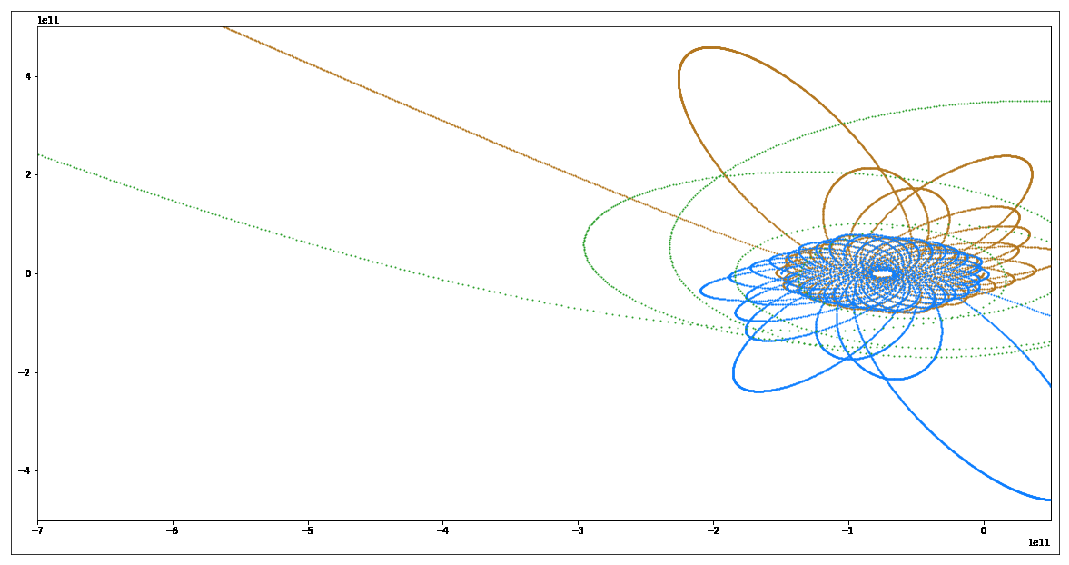

In [26]:
img = cv2.imread('cool1.png')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)

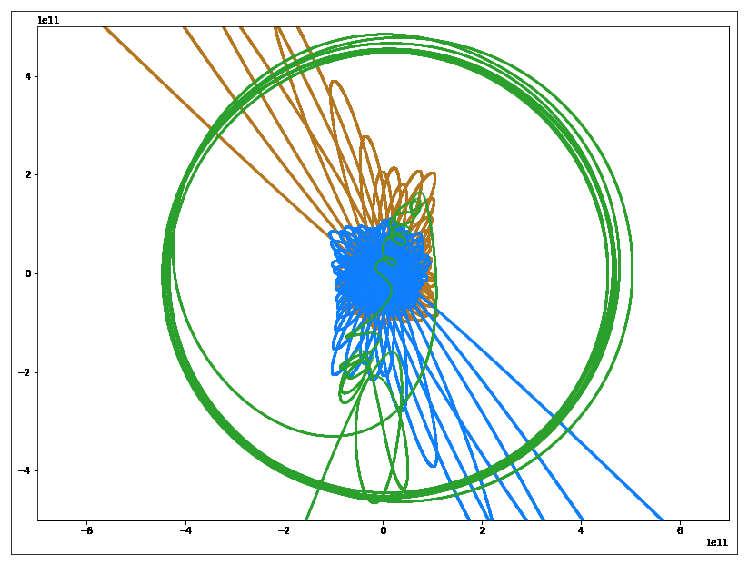

In [27]:
img = cv2.imread('cool2.png')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)

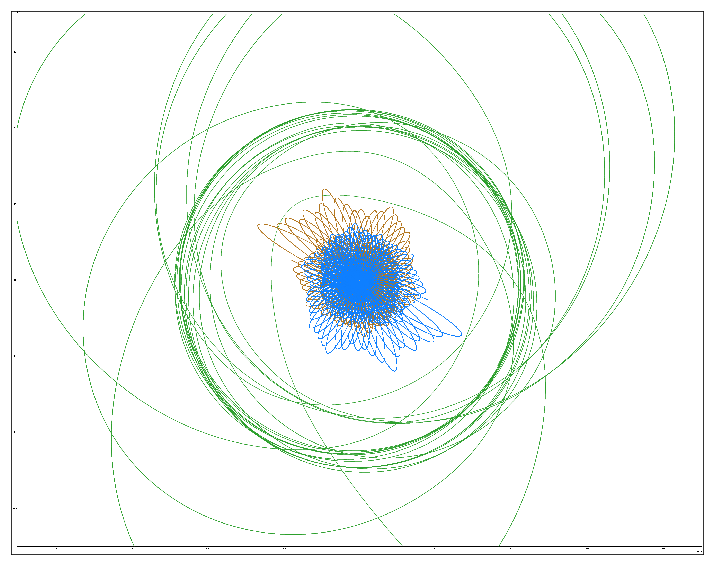

In [28]:
img = cv2.imread('cool3.png')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)

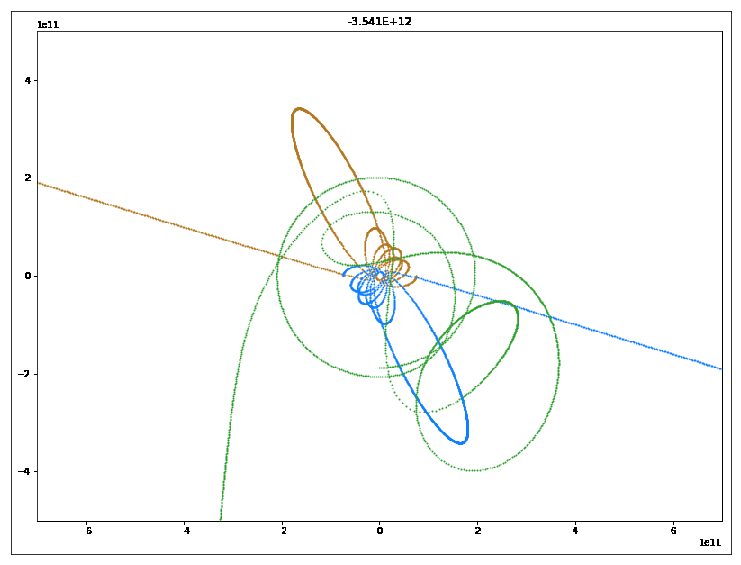

In [29]:
img = cv2.imread('cool4.png')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)

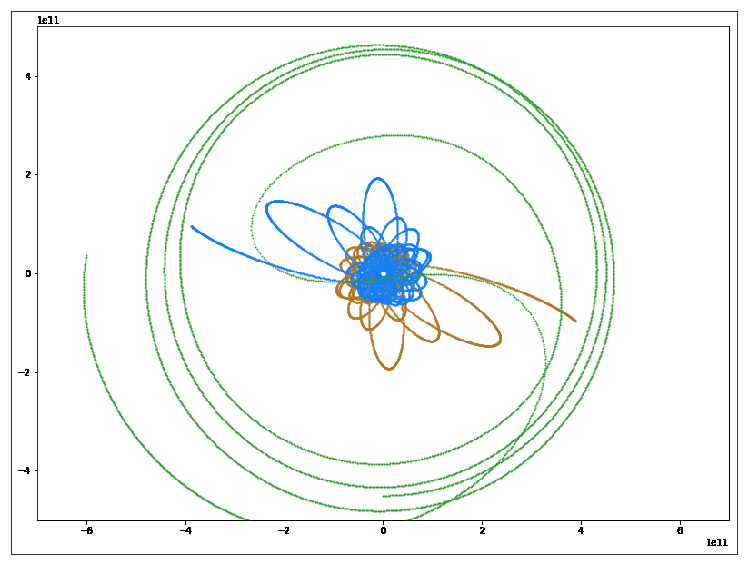

In [30]:
img = cv2.imread('cool5.png')
plt.figure(figsize=[20,10])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.imshow(img)